# **Melting Point LGBM w/Optuna+KFold**


In [1]:
!pip install /kaggle/input/rdkit-2025-3-3-cp311/rdkit-2025-3-3-cp311/rdkit-2025.3.3-cp311-cp311-manylinux_2_28_x86_64.whl

Processing /kaggle/input/rdkit-2025-3-3-cp311/rdkit-2025-3-3-cp311/rdkit-2025.3.3-cp311-cp311-manylinux_2_28_x86_64.whl


In [2]:
import os
import math
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from contextlib import contextmanager
from time import time
from tqdm import tqdm
import optuna
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold, train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
import lightgbm as lgb
import yaml
from rdkit import Chem
from rdkit.Chem import Descriptors, rdMolDescriptors
import warnings
warnings.filterwarnings('ignore')

# --- Data Loading ---
train0 = pd.read_csv("/kaggle/input/melting-point/train.csv")
print("Training data sample:")
print(train0.head(3))
print("Training data shape:", train0.shape)
print("Columns:", train0.columns.tolist())

# Load test data and submission file
test0 = pd.read_csv("/kaggle/input/melting-point/test.csv")
submit = pd.read_csv('/kaggle/input/melting-point/sample_submission.csv')

# Check the target variable
target = 'Tm'  # melting point for regression task
print(f"Target variable: {target}")
print(f"Target statistics:\n{train0[target].describe()}")

Training data sample:
     id                       SMILES      Tm  Group 1  Group 2  Group 3  \
0  2175        FC1=C(F)C(F)(F)C1(F)F  213.15        0        0        0   
1  1222  c1ccc2c(c1)ccc3Nc4ccccc4c23  407.15        0        0        0   
2  2994          CCN1C(C)=Nc2ccccc12  324.15        2        1        0   

   Group 4  Group 5  Group 6  Group 7  ...  Group 415  Group 416  Group 417  \
0        0        0        0        0  ...          0          0          0   
1        0        0        0        0  ...          0          0          0   
2        0        0        0        0  ...          0          0          0   

   Group 418  Group 419  Group 420  Group 421  Group 422  Group 423  Group 424  
0          0          0          0          0          0          0          0  
1          0          0          0          0          0          0          0  
2          0          0          0          0          0          0          0  

[3 rows x 427 columns]
Training dat

In [3]:
from rdkit import Chem
from rdkit.Chem import Descriptors, rdMolDescriptors
import pandas as pd
from tqdm import tqdm

# --- SMILES Feature Engineering (all descriptors) ---
def calculate_molecular_descriptors(smiles_series):
    """Calculate all RDKit molecular descriptors from SMILES strings."""
    
    # Collect all descriptor functions dynamically
    descriptor_funcs = [(name, func) for name, func in Descriptors.descList]
    
    descriptors = []
    
    for smiles in tqdm(smiles_series, desc="Processing SMILES"):
        if pd.isna(smiles):
            # Fill zeros if invalid SMILES
            descriptors.append([0] * (len(descriptor_funcs) + 3))  # +3 for extra SMILES features
            continue
        
        try:
            mol = Chem.MolFromSmiles(smiles)
            if mol is None:
                descriptors.append([0] * (len(descriptor_funcs) + 3))
                continue
            
            # Calculate all RDKit descriptors
            desc_values = [func(mol) for _, func in descriptor_funcs]
            
            # Add a few extra features
            desc_values += [
                len(smiles),       # SMILES length
                smiles.count('C'), # Carbon count
                smiles.count('N')  # Nitrogen count
            ]
            
            descriptors.append(desc_values)
            
        except Exception as e:
            print(f"Error processing SMILES {smiles}: {e}")
            descriptors.append([0] * (len(descriptor_funcs) + 3))
    
    # Create column names
    descriptor_names = [name for name, _ in descriptor_funcs]
    descriptor_names += ['smiles_length', 'carbon_count', 'nitrogen_count']
    
    return pd.DataFrame(descriptors, columns=descriptor_names)

    # --- SMILES Feature Engineering ---
    def calculate_molecular_descriptors(smiles_series):
        """Calculate molecular descriptors from SMILES strings."""
        descriptors = []
        
        for smiles in tqdm(smiles_series, desc="Processing SMILES"):
            if pd.isna(smiles):
                # Fill with zeros for invalid SMILES
                descriptors.append([0] * 15)
                continue
                
            try:
                mol = Chem.MolFromSmiles(smiles)
                if mol is None:
                    descriptors.append([0] * 15)
                    continue
                    
                # Calculate various molecular descriptors
                desc_values = [
                    Descriptors.MolWt(mol),                    # Molecular weight
                    Descriptors.MolLogP(mol),                  # LogP (lipophilicity)
                    Descriptors.NumHDonors(mol),               # Hydrogen bond donors
                    Descriptors.NumHAcceptors(mol),            # Hydrogen bond acceptors
                    Descriptors.TPSA(mol),                     # Topological polar surface area
                    Descriptors.NumRotatableBonds(mol),        # Rotatable bonds
                    Descriptors.NumAromaticRings(mol),         # Aromatic rings
                    Descriptors.NumSaturatedRings(mol),        # Saturated rings
                    Descriptors.NumHeteroatoms(mol),           # Heteroatoms
                    Descriptors.RingCount(mol),                # Ring count
                    Descriptors.FractionCsp3(mol),             # Fraction of sp3 carbons
                    rdMolDescriptors.BertzCT(mol),             # Bertz complexity index
                    len(smiles),                               # SMILES length
                    smiles.count('C'),                         # Carbon count in SMILES
                    smiles.count('N')                          # Nitrogen count in SMILES
                ]
                descriptors.append(desc_values)
                
            except Exception as e:
                print(f"Error processing SMILES {smiles}: {e}")
                descriptors.append([0] * 15)
        
        # Create DataFrame with descriptors
        descriptor_names = [
            'mol_weight', 'logp', 'h_donors', 'h_acceptors', 'tpsa',
            'rotatable_bonds', 'aromatic_rings', 'saturated_rings', 'heteroatoms',
            'ring_count', 'fraction_csp3', 'bertz_ct', 'smiles_length',
            'carbon_count', 'nitrogen_count'
        ]
        
        return pd.DataFrame(descriptors, columns=descriptor_names)

In [4]:
# --- Data Preprocessing ---
def labelencoder(df):
    """Encodes object columns using LabelEncoder, excluding SMILES."""
    df_encoded = df.copy()
    for c in df_encoded.columns:
        if df_encoded[c].dtype == 'object' and c != 'SMILES':
            df_encoded[c] = df_encoded[c].fillna('N')
            lbl = LabelEncoder()
            df_encoded[c] = lbl.transform(df_encoded[c].astype(str))
    return df_encoded

# Combine train and test for consistent encoding
data0 = pd.concat([train0, test0], axis=0, ignore_index=True)

# Extract SMILES column if it exists
smiles_column = None
for col in data0.columns:
    if 'smiles' in col.lower() or 'SMILES' in col:
        smiles_column = col
        break

print(f"SMILES column found: {smiles_column}")

# Process molecular descriptors if SMILES column exists
if smiles_column:
    print("Calculating molecular descriptors from SMILES...")
    molecular_features = calculate_molecular_descriptors(data0[smiles_column])
    
    # Remove SMILES column and add molecular descriptors
    data_processed = data0.drop(columns=[smiles_column])
    data_processed = pd.concat([data_processed, molecular_features], axis=1)
else:
    data_processed = data0.copy()
    print("No SMILES column found, proceeding without molecular descriptors")

# Encode categorical variables
data_encoded = labelencoder(data_processed)

# Split back into train and test
train_len = len(train0)
train = data_encoded.iloc[:train_len].copy()
test = data_encoded.iloc[train_len:].copy()

# Prepare features and target
if target in train.columns:
    trainY = train[target]
    trainX = train.drop(columns=[target])
else:
    print(f"Target column '{target}' not found in training data")
    print(f"Available columns: {train.columns.tolist()}")

testX = test.drop(columns=[target] if target in test.columns else [])

# Get feature columns (excluding target)
feature_columns = [col for col in trainX.columns if col != target]
print(f"Number of features: {len(feature_columns)}")

# --- Timer Class ---
class Timer:
    """A timer class for measuring execution time."""
    def __init__(self, logger=None, format_str='{:.3f}[s]', prefix=None, suffix=None, sep=' '):
        if prefix: format_str = str(prefix) + sep + format_str
        if suffix: format_str = format_str + sep + str(suffix)
        self.format_str = format_str
        self.logger = logger
        self.start = None
        self.end = None

    @property
    def duration(self):
        if self.end is None:
            return 0
        return self.end - self.start

    def __enter__(self):
        self.start = time()

    def __exit__(self, exc_type, exc_val, exc_tb):
        self.end = time()
        out_str = self.format_str.format(self.duration)
        if self.logger:
            self.logger.info(out_str)
        else:
            print(out_str)

SMILES column found: SMILES
Calculating molecular descriptors from SMILES...


Processing SMILES: 100%|██████████| 3328/3328 [00:19<00:00, 173.01it/s]


Number of features: 645


[I 2025-09-14 10:35:28,975] A new study created in memory with name: no-name-ab345bbb-4a25-4ffa-bdc6-e7b16d6e4ab8


Starting hyperparameter optimization...
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[546]	valid_0's rmse: 44.3546
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[268]	valid_0's rmse: 42.3379
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[126]	valid_0's rmse: 44.4534
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[544]	valid_0's rmse: 41.2285
Training until validation scores don't improve for 100 rounds


[I 2025-09-14 10:35:35,624] Trial 0 finished with value: 43.6962360523772 and parameters: {'lambda_l1': 0.0002618212972750145, 'lambda_l2': 5.016712904936765, 'num_leaves': 218, 'feature_fraction': 0.4957636373814154, 'bagging_fraction': 0.7509064213447953, 'bagging_freq': 7, 'min_child_samples': 41, 'learning_rate': 0.09592417975514976, 'max_depth': 9}. Best is trial 0 with value: 43.6962360523772.


Early stopping, best iteration is:
[186]	valid_0's rmse: 46.1067
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[101]	valid_0's rmse: 46.8626
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[208]	valid_0's rmse: 44.5115
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[78]	valid_0's rmse: 47.2919
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[90]	valid_0's rmse: 44.0081
Training until validation scores don't improve for 100 rounds


[I 2025-09-14 10:35:38,369] Trial 1 finished with value: 46.23145537159711 and parameters: {'lambda_l1': 7.855422939052649e-08, 'lambda_l2': 6.0152653131547126e-05, 'num_leaves': 117, 'feature_fraction': 0.46779254349386057, 'bagging_fraction': 0.7017181497179634, 'bagging_freq': 1, 'min_child_samples': 58, 'learning_rate': 0.2965713132215326, 'max_depth': 8}. Best is trial 0 with value: 43.6962360523772.


Early stopping, best iteration is:
[131]	valid_0's rmse: 48.4832
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[699]	valid_0's rmse: 45.1552
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[711]	valid_0's rmse: 43.1082
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[254]	valid_0's rmse: 45.4374
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[721]	valid_0's rmse: 42.1424
Training until validation scores don't improve for 100 rounds


[I 2025-09-14 10:35:44,249] Trial 2 finished with value: 44.39423741970328 and parameters: {'lambda_l1': 1.0370082887946315, 'lambda_l2': 4.860153723752757e-08, 'num_leaves': 258, 'feature_fraction': 0.4720772514611331, 'bagging_fraction': 0.43737425788357914, 'bagging_freq': 1, 'min_child_samples': 28, 'learning_rate': 0.08804875993851849, 'max_depth': 3}. Best is trial 0 with value: 43.6962360523772.


Early stopping, best iteration is:
[477]	valid_0's rmse: 46.128
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[145]	valid_0's rmse: 45.6425
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[234]	valid_0's rmse: 42.6564
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[92]	valid_0's rmse: 45.5098
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[236]	valid_0's rmse: 42.9634
Training until validation scores don't improve for 100 rounds


[I 2025-09-14 10:35:47,722] Trial 3 finished with value: 44.94130168878073 and parameters: {'lambda_l1': 1.809365697168505, 'lambda_l2': 3.757637796953694e-07, 'num_leaves': 143, 'feature_fraction': 0.836296700486448, 'bagging_fraction': 0.6902499466517962, 'bagging_freq': 7, 'min_child_samples': 64, 'learning_rate': 0.22842355875253148, 'max_depth': 6}. Best is trial 0 with value: 43.6962360523772.


Early stopping, best iteration is:
[221]	valid_0's rmse: 47.9344
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[355]	valid_0's rmse: 45.7154
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[360]	valid_0's rmse: 45.628
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[375]	valid_0's rmse: 45.2186
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[418]	valid_0's rmse: 44.0699
Training until validation scores don't improve for 100 rounds


[I 2025-09-14 10:35:50,619] Trial 4 finished with value: 45.83385895618478 and parameters: {'lambda_l1': 2.7851081769536366e-08, 'lambda_l2': 0.029408448890813337, 'num_leaves': 161, 'feature_fraction': 0.7679076349509992, 'bagging_fraction': 0.4958793392755078, 'bagging_freq': 4, 'min_child_samples': 88, 'learning_rate': 0.1409687799976187, 'max_depth': 3}. Best is trial 0 with value: 43.6962360523772.


Early stopping, best iteration is:
[556]	valid_0's rmse: 48.5374
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[215]	valid_0's rmse: 45.6726
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[360]	valid_0's rmse: 42.6833
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[120]	valid_0's rmse: 44.9108
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[574]	valid_0's rmse: 44.599
Training until validation scores don't improve for 100 rounds


[I 2025-09-14 10:35:54,531] Trial 5 finished with value: 45.349754386620646 and parameters: {'lambda_l1': 2.8885644545579692e-05, 'lambda_l2': 8.74798857961453e-06, 'num_leaves': 84, 'feature_fraction': 0.5028020920533097, 'bagging_fraction': 0.5300132219543799, 'bagging_freq': 1, 'min_child_samples': 61, 'learning_rate': 0.18878953388712993, 'max_depth': 7}. Best is trial 0 with value: 43.6962360523772.


Early stopping, best iteration is:
[121]	valid_0's rmse: 48.8831
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[218]	valid_0's rmse: 48.4949
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[71]	valid_0's rmse: 44.5955
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[88]	valid_0's rmse: 45.223
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[104]	valid_0's rmse: 45.3148
Training until validation scores don't improve for 100 rounds


[I 2025-09-14 10:35:57,676] Trial 6 finished with value: 46.78187119061819 and parameters: {'lambda_l1': 0.01333783382017611, 'lambda_l2': 3.308365735280553e-06, 'num_leaves': 283, 'feature_fraction': 0.6406920688987808, 'bagging_fraction': 0.45676405375720963, 'bagging_freq': 5, 'min_child_samples': 43, 'learning_rate': 0.27828824250101425, 'max_depth': 10}. Best is trial 0 with value: 43.6962360523772.


Early stopping, best iteration is:
[74]	valid_0's rmse: 50.281
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[218]	valid_0's rmse: 44.3751
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[804]	valid_0's rmse: 42.111
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[156]	valid_0's rmse: 45.0891
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[757]	valid_0's rmse: 41.6524
Training until validation scores don't improve for 100 rounds


[I 2025-09-14 10:36:05,468] Trial 7 finished with value: 43.665179614801815 and parameters: {'lambda_l1': 0.00040326058844869495, 'lambda_l2': 7.642622601367523e-07, 'num_leaves': 218, 'feature_fraction': 0.673293252130542, 'bagging_fraction': 0.9193450078684523, 'bagging_freq': 2, 'min_child_samples': 48, 'learning_rate': 0.09461857425139025, 'max_depth': 6}. Best is trial 7 with value: 43.665179614801815.


Early stopping, best iteration is:
[582]	valid_0's rmse: 45.0983
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[167]	valid_0's rmse: 45.9804
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[416]	valid_0's rmse: 43.5874
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[172]	valid_0's rmse: 44.5505
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[122]	valid_0's rmse: 44.574
Training until validation scores don't improve for 100 rounds


[I 2025-09-14 10:36:08,791] Trial 8 finished with value: 45.65333042584484 and parameters: {'lambda_l1': 2.3995917016571156e-06, 'lambda_l2': 6.306983552253378e-06, 'num_leaves': 280, 'feature_fraction': 0.5137551661687642, 'bagging_fraction': 0.6750213905065356, 'bagging_freq': 5, 'min_child_samples': 87, 'learning_rate': 0.25566345731701073, 'max_depth': 9}. Best is trial 7 with value: 43.665179614801815.


Early stopping, best iteration is:
[128]	valid_0's rmse: 49.5744
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[56]	valid_0's rmse: 45.1444
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[72]	valid_0's rmse: 44.1439
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[35]	valid_0's rmse: 46.4965
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[597]	valid_0's rmse: 41.77
Training until validation scores don't improve for 100 rounds


[I 2025-09-14 10:36:13,725] Trial 9 finished with value: 44.95525978439076 and parameters: {'lambda_l1': 1.0052313487153839, 'lambda_l2': 1.5286975931762908e-06, 'num_leaves': 33, 'feature_fraction': 0.5238258870165471, 'bagging_fraction': 0.7777034462768357, 'bagging_freq': 6, 'min_child_samples': 28, 'learning_rate': 0.25119755875573424, 'max_depth': 9}. Best is trial 7 with value: 43.665179614801815.


Early stopping, best iteration is:
[90]	valid_0's rmse: 47.2215
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[940]	valid_0's rmse: 45.5
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[975]	valid_0's rmse: 45.2792
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[170]	valid_0's rmse: 47.0564
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[467]	valid_0's rmse: 43.2154
Training until validation scores don't improve for 100 rounds


[I 2025-09-14 10:36:52,892] Trial 10 finished with value: 45.4703233013607 and parameters: {'lambda_l1': 0.009095511238402295, 'lambda_l2': 0.002790234485751356, 'num_leaves': 190, 'feature_fraction': 0.9036246436430067, 'bagging_fraction': 0.993007515069811, 'bagging_freq': 3, 'min_child_samples': 8, 'learning_rate': 0.02294214236977994, 'max_depth': 12}. Best is trial 7 with value: 43.665179614801815.


Early stopping, best iteration is:
[408]	valid_0's rmse: 46.3007
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[316]	valid_0's rmse: 43.9053
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[621]	valid_0's rmse: 42.4565
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[177]	valid_0's rmse: 45.0223
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[805]	valid_0's rmse: 41.5832
Training until validation scores don't improve for 100 rounds


[I 2025-09-14 10:36:59,563] Trial 11 finished with value: 43.63000462178763 and parameters: {'lambda_l1': 0.0011335886287167848, 'lambda_l2': 1.6411834094241358, 'num_leaves': 212, 'feature_fraction': 0.6510538885408769, 'bagging_fraction': 0.9361990763603795, 'bagging_freq': 3, 'min_child_samples': 36, 'learning_rate': 0.09553862081038414, 'max_depth': 5}. Best is trial 11 with value: 43.63000462178763.


Early stopping, best iteration is:
[502]	valid_0's rmse: 45.1828
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[760]	valid_0's rmse: 44.0961
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[998]	valid_0's rmse: 42.8143
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[363]	valid_0's rmse: 45.1405
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[996]	valid_0's rmse: 40.7977
Training until validation scores don't improve for 100 rounds


[I 2025-09-14 10:37:10,886] Trial 12 finished with value: 43.43696168796333 and parameters: {'lambda_l1': 0.005517338115502997, 'lambda_l2': 5.4769327420075555, 'num_leaves': 225, 'feature_fraction': 0.6555448665081858, 'bagging_fraction': 0.9843726091911222, 'bagging_freq': 3, 'min_child_samples': 18, 'learning_rate': 0.04028347615155462, 'max_depth': 5}. Best is trial 12 with value: 43.43696168796333.


Did not meet early stopping. Best iteration is:
[969]	valid_0's rmse: 44.3361
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[993]	valid_0's rmse: 43.4176
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[996]	valid_0's rmse: 42.1915
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[698]	valid_0's rmse: 45.3971
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's rmse: 41.1024
Training until validation scores don't improve for 100 rounds


[I 2025-09-14 10:37:27,837] Trial 13 finished with value: 43.30831140854373 and parameters: {'lambda_l1': 0.019627246904525827, 'lambda_l2': 8.950328195614313, 'num_leaves': 238, 'feature_fraction': 0.6125502393861973, 'bagging_fraction': 0.8993412569952425, 'bagging_freq': 3, 'min_child_samples': 6, 'learning_rate': 0.017639047306269473, 'max_depth': 5}. Best is trial 13 with value: 43.30831140854373.


Did not meet early stopping. Best iteration is:
[984]	valid_0's rmse: 44.4329
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's rmse: 45.0761
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[996]	valid_0's rmse: 43.0678
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[997]	valid_0's rmse: 45.9931
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's rmse: 42.2105
Training until validation scores don't improve for 100 rounds


[I 2025-09-14 10:37:41,014] Trial 14 finished with value: 44.32747316280687 and parameters: {'lambda_l1': 0.06970370979687289, 'lambda_l2': 0.32919341685971226, 'num_leaves': 242, 'feature_fraction': 0.5933580956040887, 'bagging_fraction': 0.8573013652644232, 'bagging_freq': 3, 'min_child_samples': 6, 'learning_rate': 0.0112254728729447, 'max_depth': 4}. Best is trial 13 with value: 43.30831140854373.


Did not meet early stopping. Best iteration is:
[991]	valid_0's rmse: 45.2898
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[672]	valid_0's rmse: 43.0429
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[836]	valid_0's rmse: 41.5966
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[224]	valid_0's rmse: 46.2974
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[526]	valid_0's rmse: 40.9308
Training until validation scores don't improve for 100 rounds


[I 2025-09-14 10:37:49,796] Trial 15 finished with value: 43.249135079098494 and parameters: {'lambda_l1': 0.06663282423571805, 'lambda_l2': 0.08555544648424766, 'num_leaves': 180, 'feature_fraction': 0.7519802535636423, 'bagging_fraction': 0.8443709649231967, 'bagging_freq': 4, 'min_child_samples': 17, 'learning_rate': 0.042632769356152844, 'max_depth': 5}. Best is trial 15 with value: 43.249135079098494.


Early stopping, best iteration is:
[524]	valid_0's rmse: 44.378
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[489]	valid_0's rmse: 43.8477
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[859]	valid_0's rmse: 41.7467
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[311]	valid_0's rmse: 45.9564
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[888]	valid_0's rmse: 40.1882
Training until validation scores don't improve for 100 rounds


[I 2025-09-14 10:37:59,427] Trial 16 finished with value: 43.024559461156755 and parameters: {'lambda_l1': 0.1158032396849754, 'lambda_l2': 0.09413197709994085, 'num_leaves': 175, 'feature_fraction': 0.7527611785702947, 'bagging_fraction': 0.8392469848005878, 'bagging_freq': 4, 'min_child_samples': 16, 'learning_rate': 0.06221192917897569, 'max_depth': 5}. Best is trial 16 with value: 43.024559461156755.


Early stopping, best iteration is:
[555]	valid_0's rmse: 43.3838
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[588]	valid_0's rmse: 43.9447
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[607]	valid_0's rmse: 42.8186
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[304]	valid_0's rmse: 44.6809
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[997]	valid_0's rmse: 40.0692
Training until validation scores don't improve for 100 rounds


[I 2025-09-14 10:38:13,264] Trial 17 finished with value: 43.174544701335854 and parameters: {'lambda_l1': 0.14152636060328, 'lambda_l2': 0.0028151842821311323, 'num_leaves': 170, 'feature_fraction': 0.9980550714865526, 'bagging_fraction': 0.8242135267183257, 'bagging_freq': 5, 'min_child_samples': 24, 'learning_rate': 0.05268088044292678, 'max_depth': 7}. Best is trial 16 with value: 43.024559461156755.


Early stopping, best iteration is:
[581]	valid_0's rmse: 44.3593
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[209]	valid_0's rmse: 45.7275
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[200]	valid_0's rmse: 42.7618
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[320]	valid_0's rmse: 44.674
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[232]	valid_0's rmse: 43.7532
Training until validation scores don't improve for 100 rounds


[I 2025-09-14 10:38:17,664] Trial 18 finished with value: 45.13929408783847 and parameters: {'lambda_l1': 0.2838606064972364, 'lambda_l2': 0.0014184257463716707, 'num_leaves': 87, 'feature_fraction': 0.9883123802311813, 'bagging_fraction': 0.6040515494145218, 'bagging_freq': 5, 'min_child_samples': 74, 'learning_rate': 0.14010981780282722, 'max_depth': 7}. Best is trial 16 with value: 43.024559461156755.


Early stopping, best iteration is:
[209]	valid_0's rmse: 48.78
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[281]	valid_0's rmse: 44.0243
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[137]	valid_0's rmse: 43.4264
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[185]	valid_0's rmse: 44.9852
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[948]	valid_0's rmse: 39.6096
Training until validation scores don't improve for 100 rounds


[I 2025-09-14 10:38:31,822] Trial 19 finished with value: 43.415517698714574 and parameters: {'lambda_l1': 6.753864561887861, 'lambda_l2': 0.008230252731067545, 'num_leaves': 137, 'feature_fraction': 0.9974407500401985, 'bagging_fraction': 0.8005064740221998, 'bagging_freq': 6, 'min_child_samples': 25, 'learning_rate': 0.06877920968368056, 'max_depth': 11}. Best is trial 16 with value: 43.024559461156755.


Early stopping, best iteration is:
[234]	valid_0's rmse: 45.0321
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[150]	valid_0's rmse: 42.4677
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[449]	valid_0's rmse: 42.9849
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[109]	valid_0's rmse: 45.7446
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[717]	valid_0's rmse: 40.9539
Training until validation scores don't improve for 100 rounds


[I 2025-09-14 10:38:38,405] Trial 20 finished with value: 43.636945591415 and parameters: {'lambda_l1': 1.2460675028070747e-05, 'lambda_l2': 0.00019513252745597445, 'num_leaves': 13, 'feature_fraction': 0.9013839151353968, 'bagging_fraction': 0.8421398939683278, 'bagging_freq': 6, 'min_child_samples': 34, 'learning_rate': 0.17071411389352198, 'max_depth': 8}. Best is trial 16 with value: 43.024559461156755.


Early stopping, best iteration is:
[150]	valid_0's rmse: 46.0337
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[531]	valid_0's rmse: 44.0414
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[592]	valid_0's rmse: 41.3797
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[123]	valid_0's rmse: 45.0072
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[640]	valid_0's rmse: 40.2044
Training until validation scores don't improve for 100 rounds


[I 2025-09-14 10:38:46,967] Trial 21 finished with value: 42.93204987522301 and parameters: {'lambda_l1': 0.1920427009743608, 'lambda_l2': 0.11050567949459564, 'num_leaves': 178, 'feature_fraction': 0.7426698235902871, 'bagging_fraction': 0.8240788880375003, 'bagging_freq': 4, 'min_child_samples': 17, 'learning_rate': 0.057201557105804275, 'max_depth': 6}. Best is trial 21 with value: 42.93204987522301.


Early stopping, best iteration is:
[230]	valid_0's rmse: 44.0275
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[362]	valid_0's rmse: 44.6529
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[565]	valid_0's rmse: 41.645
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[252]	valid_0's rmse: 45.76
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[993]	valid_0's rmse: 39.2869
Training until validation scores don't improve for 100 rounds


[I 2025-09-14 10:38:56,629] Trial 22 finished with value: 43.11180871184054 and parameters: {'lambda_l1': 0.15218185872860077, 'lambda_l2': 0.2680642794162923, 'num_leaves': 182, 'feature_fraction': 0.7417199764196961, 'bagging_fraction': 0.7443398027876125, 'bagging_freq': 4, 'min_child_samples': 17, 'learning_rate': 0.05924492634095864, 'max_depth': 6}. Best is trial 21 with value: 42.93204987522301.


Early stopping, best iteration is:
[480]	valid_0's rmse: 44.2142
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[160]	valid_0's rmse: 45.0611
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[250]	valid_0's rmse: 42.1092
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[54]	valid_0's rmse: 46.8196
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[314]	valid_0's rmse: 39.3631
Training until validation scores don't improve for 100 rounds


[I 2025-09-14 10:39:01,768] Trial 23 finished with value: 43.7673362459458 and parameters: {'lambda_l1': 5.3672216440946725, 'lambda_l2': 0.2589963867310231, 'num_leaves': 191, 'feature_fraction': 0.7423198268771684, 'bagging_fraction': 0.735760389335883, 'bagging_freq': 4, 'min_child_samples': 16, 'learning_rate': 0.12465815565433597, 'max_depth': 6}. Best is trial 21 with value: 42.93204987522301.


Early stopping, best iteration is:
[165]	valid_0's rmse: 45.4836
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[648]	valid_0's rmse: 43.8101
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[999]	valid_0's rmse: 43.2753
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[584]	valid_0's rmse: 45.2887
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[420]	valid_0's rmse: 44.1828
Training until validation scores don't improve for 100 rounds


[I 2025-09-14 10:39:06,919] Trial 24 finished with value: 44.90768632780243 and parameters: {'lambda_l1': 0.002394143477363885, 'lambda_l2': 0.5052029100000357, 'num_leaves': 118, 'feature_fraction': 0.8097447265905241, 'bagging_fraction': 0.6063841533713985, 'bagging_freq': 4, 'min_child_samples': 100, 'learning_rate': 0.06202529728467158, 'max_depth': 4}. Best is trial 21 with value: 42.93204987522301.


Early stopping, best iteration is:
[476]	valid_0's rmse: 47.9815
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[482]	valid_0's rmse: 44.8488
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[242]	valid_0's rmse: 42.7306
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[116]	valid_0's rmse: 46.6214
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[496]	valid_0's rmse: 41.6171
Training until validation scores don't improve for 100 rounds


[I 2025-09-14 10:39:12,620] Trial 25 finished with value: 44.11765051775402 and parameters: {'lambda_l1': 0.32396482252788944, 'lambda_l2': 0.03376944685184354, 'num_leaves': 198, 'feature_fraction': 0.7302722602820294, 'bagging_fraction': 0.6486578311469633, 'bagging_freq': 2, 'min_child_samples': 15, 'learning_rate': 0.11845879039140167, 'max_depth': 4}. Best is trial 21 with value: 42.93204987522301.


Early stopping, best iteration is:
[481]	valid_0's rmse: 44.7703
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[404]	valid_0's rmse: 43.933
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[904]	valid_0's rmse: 42.6753
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[312]	valid_0's rmse: 44.4047
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[555]	valid_0's rmse: 41.3934
Training until validation scores don't improve for 100 rounds


[I 2025-09-14 10:39:21,785] Trial 26 finished with value: 43.53833253372733 and parameters: {'lambda_l1': 0.04537567849987747, 'lambda_l2': 0.020399701040183266, 'num_leaves': 153, 'feature_fraction': 0.840419105618167, 'bagging_fraction': 0.8838855594672012, 'bagging_freq': 4, 'min_child_samples': 34, 'learning_rate': 0.07262256343156136, 'max_depth': 6}. Best is trial 21 with value: 42.93204987522301.


Early stopping, best iteration is:
[468]	valid_0's rmse: 45.2852
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[584]	valid_0's rmse: 43.8877
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[955]	valid_0's rmse: 41.2073
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[190]	valid_0's rmse: 45.3904
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[886]	valid_0's rmse: 39.9081
Training until validation scores don't improve for 100 rounds


[I 2025-09-14 10:39:37,099] Trial 27 finished with value: 42.87581977824267 and parameters: {'lambda_l1': 0.39692748320533744, 'lambda_l2': 0.7903427617706831, 'num_leaves': 124, 'feature_fraction': 0.6990107820095208, 'bagging_fraction': 0.7558533565415775, 'bagging_freq': 2, 'min_child_samples': 12, 'learning_rate': 0.03685358556692861, 'max_depth': 6}. Best is trial 27 with value: 42.87581977824267.


Did not meet early stopping. Best iteration is:
[968]	valid_0's rmse: 43.9856
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[811]	valid_0's rmse: 43.8479
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[972]	valid_0's rmse: 42.2165
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[314]	valid_0's rmse: 45.4731
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[993]	valid_0's rmse: 40.8611
Training until validation scores don't improve for 100 rounds


[I 2025-09-14 10:39:46,326] Trial 28 finished with value: 43.27289178859752 and parameters: {'lambda_l1': 9.24982071624906, 'lambda_l2': 1.3476353391519347, 'num_leaves': 88, 'feature_fraction': 0.41058066925900133, 'bagging_fraction': 0.7876107519513543, 'bagging_freq': 2, 'min_child_samples': 11, 'learning_rate': 0.03482986682110801, 'max_depth': 4}. Best is trial 27 with value: 42.87581977824267.


Did not meet early stopping. Best iteration is:
[995]	valid_0's rmse: 43.9659
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[326]	valid_0's rmse: 44.0183
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[560]	valid_0's rmse: 42.1499
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[158]	valid_0's rmse: 44.9158
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[464]	valid_0's rmse: 41.8824
Training until validation scores don't improve for 100 rounds


[I 2025-09-14 10:39:54,530] Trial 29 finished with value: 43.821819086651615 and parameters: {'lambda_l1': 7.023571611142415e-05, 'lambda_l2': 1.5265454635025384, 'num_leaves': 116, 'feature_fraction': 0.7870711961056698, 'bagging_fraction': 0.736423691818436, 'bagging_freq': 2, 'min_child_samples': 42, 'learning_rate': 0.08027642931742306, 'max_depth': 8}. Best is trial 27 with value: 42.87581977824267.


Early stopping, best iteration is:
[280]	valid_0's rmse: 46.1428
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[230]	valid_0's rmse: 44.4266
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[938]	valid_0's rmse: 43.4978
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[60]	valid_0's rmse: 45.8596
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[696]	valid_0's rmse: 40.1093
Training until validation scores don't improve for 100 rounds


[I 2025-09-14 10:40:02,995] Trial 30 finished with value: 43.95327132153171 and parameters: {'lambda_l1': 0.38274686493871307, 'lambda_l2': 0.0005764526669124413, 'num_leaves': 130, 'feature_fraction': 0.6897125868709203, 'bagging_fraction': 0.9339306744658842, 'bagging_freq': 7, 'min_child_samples': 23, 'learning_rate': 0.10743308177919605, 'max_depth': 7}. Best is trial 27 with value: 42.87581977824267.


Early stopping, best iteration is:
[185]	valid_0's rmse: 45.8732
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[423]	valid_0's rmse: 43.0215
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[512]	valid_0's rmse: 41.234
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[76]	valid_0's rmse: 45.3113
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[799]	valid_0's rmse: 40.2677
Training until validation scores don't improve for 100 rounds


[I 2025-09-14 10:40:12,967] Trial 31 finished with value: 42.851263408014304 and parameters: {'lambda_l1': 1.0062207525391056, 'lambda_l2': 0.12495963099379129, 'num_leaves': 168, 'feature_fraction': 0.715316368659541, 'bagging_fraction': 0.7635944636764367, 'bagging_freq': 4, 'min_child_samples': 12, 'learning_rate': 0.056216789973435384, 'max_depth': 6}. Best is trial 31 with value: 42.851263408014304.


Early stopping, best iteration is:
[326]	valid_0's rmse: 44.4218
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[595]	valid_0's rmse: 44.4543
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[585]	valid_0's rmse: 42.5352
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[319]	valid_0's rmse: 45.4565
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[470]	valid_0's rmse: 40.3153
Training until validation scores don't improve for 100 rounds


[I 2025-09-14 10:40:21,370] Trial 32 finished with value: 43.25393658184843 and parameters: {'lambda_l1': 1.2696021221373976, 'lambda_l2': 0.08965408880772298, 'num_leaves': 164, 'feature_fraction': 0.7071354192188615, 'bagging_fraction': 0.7746645117694049, 'bagging_freq': 5, 'min_child_samples': 11, 'learning_rate': 0.04488702053582172, 'max_depth': 5}. Best is trial 31 with value: 42.851263408014304.


Early stopping, best iteration is:
[492]	valid_0's rmse: 43.5084
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[822]	valid_0's rmse: 43.4684
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[987]	valid_0's rmse: 41.3889
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[324]	valid_0's rmse: 44.6384
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[992]	valid_0's rmse: 39.9752
Training until validation scores don't improve for 100 rounds


[I 2025-09-14 10:40:33,570] Trial 33 finished with value: 42.74492114635182 and parameters: {'lambda_l1': 0.8540562775193986, 'lambda_l2': 0.009973233334692655, 'num_leaves': 60, 'feature_fraction': 0.5936377496852365, 'bagging_fraction': 0.8079822118639866, 'bagging_freq': 3, 'min_child_samples': 22, 'learning_rate': 0.029750385002104834, 'max_depth': 6}. Best is trial 33 with value: 42.74492114635182.


Early stopping, best iteration is:
[851]	valid_0's rmse: 44.2536
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[973]	valid_0's rmse: 43.1483
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[975]	valid_0's rmse: 42.3206
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[666]	valid_0's rmse: 43.6681
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[979]	valid_0's rmse: 40.4072
Training until validation scores don't improve for 100 rounds


[I 2025-09-14 10:40:48,299] Trial 34 finished with value: 42.81486733892946 and parameters: {'lambda_l1': 2.371710451722053, 'lambda_l2': 0.008529241775976724, 'num_leaves': 36, 'feature_fraction': 0.579008650637097, 'bagging_fraction': 0.713837621846891, 'bagging_freq': 1, 'min_child_samples': 29, 'learning_rate': 0.022668514601769624, 'max_depth': 8}. Best is trial 33 with value: 42.74492114635182.


Did not meet early stopping. Best iteration is:
[999]	valid_0's rmse: 44.5301
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[998]	valid_0's rmse: 43.3537
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[945]	valid_0's rmse: 41.8276
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[562]	valid_0's rmse: 43.4656
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's rmse: 40.5356
Training until validation scores don't improve for 100 rounds


[I 2025-09-14 10:41:01,811] Trial 35 finished with value: 42.76550232663742 and parameters: {'lambda_l1': 1.9229450051265242, 'lambda_l2': 0.008748537381274343, 'num_leaves': 57, 'feature_fraction': 0.5611798773627108, 'bagging_fraction': 0.7131417920463018, 'bagging_freq': 1, 'min_child_samples': 33, 'learning_rate': 0.025485716221239636, 'max_depth': 8}. Best is trial 33 with value: 42.74492114635182.


Early stopping, best iteration is:
[827]	valid_0's rmse: 44.6451
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's rmse: 44.4172
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[999]	valid_0's rmse: 42.4367
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[802]	valid_0's rmse: 43.4967
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[996]	valid_0's rmse: 42.0507
Training until validation scores don't improve for 100 rounds


[I 2025-09-14 10:41:15,037] Trial 36 finished with value: 43.7633938944103 and parameters: {'lambda_l1': 2.3099399534927096, 'lambda_l2': 4.232578428645503e-05, 'num_leaves': 51, 'feature_fraction': 0.5696916841174516, 'bagging_fraction': 0.7099124046465287, 'bagging_freq': 1, 'min_child_samples': 50, 'learning_rate': 0.02162846874779846, 'max_depth': 8}. Best is trial 33 with value: 42.74492114635182.


Did not meet early stopping. Best iteration is:
[954]	valid_0's rmse: 46.4157
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[117]	valid_0's rmse: 46.1295
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[85]	valid_0's rmse: 43.3057
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[57]	valid_0's rmse: 46.8565
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[247]	valid_0's rmse: 41.6643
Training until validation scores don't improve for 100 rounds


[I 2025-09-14 10:41:19,341] Trial 37 finished with value: 45.0715267544219 and parameters: {'lambda_l1': 2.5173893086309556, 'lambda_l2': 0.009218033074234147, 'num_leaves': 39, 'feature_fraction': 0.553212897573717, 'bagging_fraction': 0.6629245313649343, 'bagging_freq': 1, 'min_child_samples': 30, 'learning_rate': 0.19871583523960049, 'max_depth': 10}. Best is trial 33 with value: 42.74492114635182.


Early stopping, best iteration is:
[114]	valid_0's rmse: 47.4016
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's rmse: 44.0377
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[995]	valid_0's rmse: 41.9873
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[901]	valid_0's rmse: 43.3736
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[956]	valid_0's rmse: 41.7926
Training until validation scores don't improve for 100 rounds


[I 2025-09-14 10:41:30,497] Trial 38 finished with value: 43.5102716561199 and parameters: {'lambda_l1': 0.9829670067350919, 'lambda_l2': 6.942475715550337e-05, 'num_leaves': 73, 'feature_fraction': 0.43942437137846735, 'bagging_fraction': 0.6270807177253085, 'bagging_freq': 1, 'min_child_samples': 55, 'learning_rate': 0.026719429129357482, 'max_depth': 8}. Best is trial 33 with value: 42.74492114635182.


Did not meet early stopping. Best iteration is:
[985]	valid_0's rmse: 46.3602
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[541]	valid_0's rmse: 44.258
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[572]	valid_0's rmse: 42.3565
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[121]	valid_0's rmse: 45.5884
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[590]	valid_0's rmse: 41.0618
Training until validation scores don't improve for 100 rounds


[I 2025-09-14 10:41:38,057] Trial 39 finished with value: 43.87211482403214 and parameters: {'lambda_l1': 5.019213573201812e-07, 'lambda_l2': 0.007976122320044628, 'num_leaves': 66, 'feature_fraction': 0.6186190267334088, 'bagging_fraction': 0.5614013255603805, 'bagging_freq': 1, 'min_child_samples': 37, 'learning_rate': 0.08510088942567959, 'max_depth': 9}. Best is trial 33 with value: 42.74492114635182.


Early stopping, best iteration is:
[309]	valid_0's rmse: 46.096
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's rmse: 44.1781
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's rmse: 42.6892
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[980]	valid_0's rmse: 44.1835
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's rmse: 41.8239
Training until validation scores don't improve for 100 rounds


[I 2025-09-14 10:41:49,469] Trial 40 finished with value: 43.666292959949786 and parameters: {'lambda_l1': 3.492852747086232, 'lambda_l2': 0.0004386112559108217, 'num_leaves': 10, 'feature_fraction': 0.475443097852041, 'bagging_fraction': 0.7076156502436256, 'bagging_freq': 2, 'min_child_samples': 30, 'learning_rate': 0.014894134452334399, 'max_depth': 10}. Best is trial 33 with value: 42.74492114635182.


Did not meet early stopping. Best iteration is:
[990]	valid_0's rmse: 45.4567
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[658]	valid_0's rmse: 43.669
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[969]	valid_0's rmse: 42.7615
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[394]	valid_0's rmse: 44.1625
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[994]	valid_0's rmse: 39.8484
Training until validation scores don't improve for 100 rounds


[I 2025-09-14 10:42:02,010] Trial 41 finished with value: 43.08663911436954 and parameters: {'lambda_l1': 0.6428912715520034, 'lambda_l2': 3.7753621186338245e-08, 'num_leaves': 103, 'feature_fraction': 0.5467001481028876, 'bagging_fraction': 0.7628755010739023, 'bagging_freq': 2, 'min_child_samples': 22, 'learning_rate': 0.03258813183666829, 'max_depth': 7}. Best is trial 33 with value: 42.74492114635182.


Early stopping, best iteration is:
[500]	valid_0's rmse: 44.9918
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's rmse: 43.9942
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[989]	valid_0's rmse: 41.7454
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[776]	valid_0's rmse: 44.3964
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's rmse: 40.1756
Training until validation scores don't improve for 100 rounds


[I 2025-09-14 10:42:22,388] Trial 42 finished with value: 42.82261475420479 and parameters: {'lambda_l1': 0.028414601755335077, 'lambda_l2': 0.030182486760170435, 'num_leaves': 52, 'feature_fraction': 0.5905439425480778, 'bagging_fraction': 0.6977278308973893, 'bagging_freq': 1, 'min_child_samples': 10, 'learning_rate': 0.01004117050224726, 'max_depth': 7}. Best is trial 33 with value: 42.74492114635182.


Did not meet early stopping. Best iteration is:
[1000]	valid_0's rmse: 43.8015
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[999]	valid_0's rmse: 44.8685
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[999]	valid_0's rmse: 43.0982
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's rmse: 43.803
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's rmse: 42.4618
Training until validation scores don't improve for 100 rounds


[I 2025-09-14 10:42:36,558] Trial 43 finished with value: 44.147909315594276 and parameters: {'lambda_l1': 0.018338310830262196, 'lambda_l2': 0.0017666262775521122, 'num_leaves': 29, 'feature_fraction': 0.5851273688089156, 'bagging_fraction': 0.6941949396020135, 'bagging_freq': 1, 'min_child_samples': 46, 'learning_rate': 0.012299114554193106, 'max_depth': 9}. Best is trial 33 with value: 42.74492114635182.


Did not meet early stopping. Best iteration is:
[999]	valid_0's rmse: 46.5081
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[515]	valid_0's rmse: 43.9169
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[717]	valid_0's rmse: 41.8772
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[246]	valid_0's rmse: 45.0187
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[964]	valid_0's rmse: 39.3827
Training until validation scores don't improve for 100 rounds


[I 2025-09-14 10:42:48,018] Trial 44 finished with value: 42.93598690597713 and parameters: {'lambda_l1': 1.7088516373992066, 'lambda_l2': 0.02338933302351441, 'num_leaves': 65, 'feature_fraction': 0.5261592160040396, 'bagging_fraction': 0.8025743171599469, 'bagging_freq': 1, 'min_child_samples': 21, 'learning_rate': 0.047420406930685916, 'max_depth': 7}. Best is trial 33 with value: 42.74492114635182.


Did not meet early stopping. Best iteration is:
[940]	valid_0's rmse: 44.4844
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[684]	valid_0's rmse: 44.1855
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[972]	valid_0's rmse: 41.9608
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[815]	valid_0's rmse: 43.1179
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[997]	valid_0's rmse: 41.5969
Training until validation scores don't improve for 100 rounds


[I 2025-09-14 10:42:58,818] Trial 45 finished with value: 43.373942251771226 and parameters: {'lambda_l1': 0.03357634280857833, 'lambda_l2': 0.004574897881553177, 'num_leaves': 55, 'feature_fraction': 0.6190287116884082, 'bagging_fraction': 0.7248951638898375, 'bagging_freq': 1, 'min_child_samples': 66, 'learning_rate': 0.030748292064312868, 'max_depth': 8}. Best is trial 33 with value: 42.74492114635182.


Did not meet early stopping. Best iteration is:
[975]	valid_0's rmse: 46.0086
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[994]	valid_0's rmse: 43.3288
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[840]	valid_0's rmse: 42.1476
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[603]	valid_0's rmse: 43.7848
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[993]	valid_0's rmse: 40.5834
Training until validation scores don't improve for 100 rounds


[I 2025-09-14 10:43:12,699] Trial 46 finished with value: 42.94163149781903 and parameters: {'lambda_l1': 9.110943709607652, 'lambda_l2': 0.039294400134506004, 'num_leaves': 25, 'feature_fraction': 0.4968902178770508, 'bagging_fraction': 0.6697531238206249, 'bagging_freq': 3, 'min_child_samples': 28, 'learning_rate': 0.025032710766997552, 'max_depth': 8}. Best is trial 33 with value: 42.74492114635182.


Early stopping, best iteration is:
[813]	valid_0's rmse: 44.8636
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's rmse: 44.5517
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's rmse: 42.862
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[960]	valid_0's rmse: 44.0761
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's rmse: 42.2812
Training until validation scores don't improve for 100 rounds


[I 2025-09-14 10:43:26,694] Trial 47 finished with value: 44.039959050098574 and parameters: {'lambda_l1': 0.0003580444794845755, 'lambda_l2': 0.0009706664824460228, 'num_leaves': 44, 'feature_fraction': 0.665575801352604, 'bagging_fraction': 0.6375473326055067, 'bagging_freq': 2, 'min_child_samples': 38, 'learning_rate': 0.012142461526454677, 'max_depth': 7}. Best is trial 33 with value: 42.74492114635182.


Did not meet early stopping. Best iteration is:
[996]	valid_0's rmse: 46.4288
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[244]	valid_0's rmse: 45.3133
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[342]	valid_0's rmse: 41.2885
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[100]	valid_0's rmse: 45.3557
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[331]	valid_0's rmse: 42.1779
Training until validation scores don't improve for 100 rounds


[I 2025-09-14 10:43:39,919] Trial 48 finished with value: 43.58944814783152 and parameters: {'lambda_l1': 0.7387808507290282, 'lambda_l2': 1.1485867992250263e-07, 'num_leaves': 103, 'feature_fraction': 0.6313703453772682, 'bagging_fraction': 0.5745686703115426, 'bagging_freq': 1, 'min_child_samples': 5, 'learning_rate': 0.04924786718552504, 'max_depth': 9}. Best is trial 33 with value: 42.74492114635182.


Early stopping, best iteration is:
[334]	valid_0's rmse: 43.8119
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[18]	valid_0's rmse: 48.2691
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[16]	valid_0's rmse: 47.33
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[53]	valid_0's rmse: 48.0196
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[40]	valid_0's rmse: 47.0648
Training until validation scores don't improve for 100 rounds


[I 2025-09-14 10:43:42,521] Trial 49 finished with value: 47.98162947402205 and parameters: {'lambda_l1': 0.00588767779961092, 'lambda_l2': 0.00015356393568108576, 'num_leaves': 79, 'feature_fraction': 0.5864951316258872, 'bagging_fraction': 0.40199825186963195, 'bagging_freq': 3, 'min_child_samples': 10, 'learning_rate': 0.2979799119232091, 'max_depth': 7}. Best is trial 33 with value: 42.74492114635182.


Early stopping, best iteration is:
[19]	valid_0's rmse: 49.2246
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[622]	valid_0's rmse: 43.1488
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[431]	valid_0's rmse: 42.6845
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[290]	valid_0's rmse: 43.8379
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[681]	valid_0's rmse: 40.8396
Training until validation scores don't improve for 100 rounds


[I 2025-09-14 10:43:49,465] Trial 50 finished with value: 43.20145509278781 and parameters: {'lambda_l1': 0.0017342774402773907, 'lambda_l2': 0.015805451541390087, 'num_leaves': 59, 'feature_fraction': 0.5400016129404612, 'bagging_fraction': 0.6855178882339286, 'bagging_freq': 2, 'min_child_samples': 32, 'learning_rate': 0.07450822243542385, 'max_depth': 6}. Best is trial 33 with value: 42.74492114635182.


Early stopping, best iteration is:
[300]	valid_0's rmse: 45.4964
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[714]	valid_0's rmse: 44.5816
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[961]	valid_0's rmse: 40.8649
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[194]	valid_0's rmse: 44.9866
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[881]	valid_0's rmse: 40.5231
Training until validation scores don't improve for 100 rounds


[I 2025-09-14 10:44:04,270] Trial 51 finished with value: 42.96579115698493 and parameters: {'lambda_l1': 0.5360988612099309, 'lambda_l2': 0.7029839054805413, 'num_leaves': 22, 'feature_fraction': 0.6990309982390779, 'bagging_fraction': 0.7651293955022196, 'bagging_freq': 2, 'min_child_samples': 13, 'learning_rate': 0.03638179853422571, 'max_depth': 6}. Best is trial 33 with value: 42.74492114635182.


Did not meet early stopping. Best iteration is:
[989]	valid_0's rmse: 43.8728
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[700]	valid_0's rmse: 43.3336
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[965]	valid_0's rmse: 41.3461
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[329]	valid_0's rmse: 44.3268
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[917]	valid_0's rmse: 39.7057
Training until validation scores don't improve for 100 rounds


[I 2025-09-14 10:44:15,950] Trial 52 finished with value: 42.65742406297378 and parameters: {'lambda_l1': 2.7247581489265587, 'lambda_l2': 3.561123210576881, 'num_leaves': 152, 'feature_fraction': 0.6449243319586888, 'bagging_fraction': 0.7221447499020698, 'bagging_freq': 1, 'min_child_samples': 20, 'learning_rate': 0.038970344281618975, 'max_depth': 6}. Best is trial 52 with value: 42.65742406297378.


Did not meet early stopping. Best iteration is:
[919]	valid_0's rmse: 44.5749
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[512]	valid_0's rmse: 43.3461
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[962]	valid_0's rmse: 41.457
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[316]	valid_0's rmse: 44.8401
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[997]	valid_0's rmse: 39.1359
Training until validation scores don't improve for 100 rounds


[I 2025-09-14 10:44:28,021] Trial 53 finished with value: 42.787240673265636 and parameters: {'lambda_l1': 3.350922950011921, 'lambda_l2': 3.355848760892976, 'num_leaves': 153, 'feature_fraction': 0.5978770635484683, 'bagging_fraction': 0.713586917366722, 'bagging_freq': 1, 'min_child_samples': 20, 'learning_rate': 0.04514471787327113, 'max_depth': 7}. Best is trial 52 with value: 42.65742406297378.


Early stopping, best iteration is:
[686]	valid_0's rmse: 45.1571
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[77]	valid_0's rmse: 45.8657
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[89]	valid_0's rmse: 45.091
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[52]	valid_0's rmse: 46.0306
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[290]	valid_0's rmse: 43.1008
Training until validation scores don't improve for 100 rounds


[I 2025-09-14 10:44:31,594] Trial 54 finished with value: 45.11038941681314 and parameters: {'lambda_l1': 3.304783489566768, 'lambda_l2': 3.2629295920257153, 'num_leaves': 149, 'feature_fraction': 0.56893969608343, 'bagging_fraction': 0.7173467151499836, 'bagging_freq': 1, 'min_child_samples': 26, 'learning_rate': 0.21884341770170823, 'max_depth': 7}. Best is trial 52 with value: 42.65742406297378.


Early stopping, best iteration is:
[118]	valid_0's rmse: 45.4639
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[528]	valid_0's rmse: 43.801
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[965]	valid_0's rmse: 41.9635
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[479]	valid_0's rmse: 43.8216
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's rmse: 39.8014
Training until validation scores don't improve for 100 rounds


[I 2025-09-14 10:44:46,296] Trial 55 finished with value: 42.736917114943274 and parameters: {'lambda_l1': 3.9652481395187116, 'lambda_l2': 0.0040142704992389405, 'num_leaves': 41, 'feature_fraction': 0.6046922989518366, 'bagging_fraction': 0.6748841605755893, 'bagging_freq': 1, 'min_child_samples': 20, 'learning_rate': 0.0224245474618525, 'max_depth': 8}. Best is trial 52 with value: 42.65742406297378.


Did not meet early stopping. Best iteration is:
[977]	valid_0's rmse: 44.2971
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[675]	valid_0's rmse: 43.47
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[776]	valid_0's rmse: 41.5894
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[655]	valid_0's rmse: 43.6603
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[998]	valid_0's rmse: 39.4636
Training until validation scores don't improve for 100 rounds


[I 2025-09-14 10:45:02,598] Trial 56 finished with value: 42.42697120155473 and parameters: {'lambda_l1': 4.222010085711352, 'lambda_l2': 5.580397205984291, 'num_leaves': 266, 'feature_fraction': 0.6451057058562782, 'bagging_fraction': 0.6547346103320263, 'bagging_freq': 1, 'min_child_samples': 19, 'learning_rate': 0.024633283367829356, 'max_depth': 8}. Best is trial 56 with value: 42.42697120155473.


Did not meet early stopping. Best iteration is:
[1000]	valid_0's rmse: 43.9515
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[158]	valid_0's rmse: 43.7875
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[386]	valid_0's rmse: 41.6698
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[103]	valid_0's rmse: 43.8703
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[734]	valid_0's rmse: 39.8112
Training until validation scores don't improve for 100 rounds


[I 2025-09-14 10:45:10,680] Trial 57 finished with value: 43.0513136330314 and parameters: {'lambda_l1': 3.732699794780489, 'lambda_l2': 9.44785463907808, 'num_leaves': 293, 'feature_fraction': 0.6465719140421015, 'bagging_fraction': 0.5033906766157634, 'bagging_freq': 1, 'min_child_samples': 22, 'learning_rate': 0.09529703050768934, 'max_depth': 9}. Best is trial 56 with value: 42.42697120155473.


Early stopping, best iteration is:
[272]	valid_0's rmse: 46.1177
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[770]	valid_0's rmse: 43.3638
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[509]	valid_0's rmse: 41.9742
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[231]	valid_0's rmse: 43.3394
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[708]	valid_0's rmse: 40.3435
Training until validation scores don't improve for 100 rounds


[I 2025-09-14 10:45:24,667] Trial 58 finished with value: 42.70233355982369 and parameters: {'lambda_l1': 1.9254166644170867e-08, 'lambda_l2': 3.786932087659595, 'num_leaves': 240, 'feature_fraction': 0.6733115796309905, 'bagging_fraction': 0.6078797438457192, 'bagging_freq': 1, 'min_child_samples': 20, 'learning_rate': 0.044871351230691255, 'max_depth': 10}. Best is trial 56 with value: 42.42697120155473.


Early stopping, best iteration is:
[464]	valid_0's rmse: 44.4907
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[428]	valid_0's rmse: 43.349
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[218]	valid_0's rmse: 42.6461
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[190]	valid_0's rmse: 44.3257
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[390]	valid_0's rmse: 40.6201
Training until validation scores don't improve for 100 rounds


[I 2025-09-14 10:45:33,442] Trial 59 finished with value: 43.2722381431497 and parameters: {'lambda_l1': 1.121752244680981e-06, 'lambda_l2': 1.1591386173076234e-08, 'num_leaves': 253, 'feature_fraction': 0.6797536806916397, 'bagging_fraction': 0.6092133361450305, 'bagging_freq': 2, 'min_child_samples': 26, 'learning_rate': 0.06939601512871442, 'max_depth': 11}. Best is trial 56 with value: 42.42697120155473.


Early stopping, best iteration is:
[236]	valid_0's rmse: 45.4204
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[845]	valid_0's rmse: 43.2023
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[708]	valid_0's rmse: 41.5498
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[380]	valid_0's rmse: 43.1132
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[871]	valid_0's rmse: 40.5096
Training until validation scores don't improve for 100 rounds


[I 2025-09-14 10:45:49,975] Trial 60 finished with value: 42.72502617211587 and parameters: {'lambda_l1': 7.622392377834336e-06, 'lambda_l2': 5.565947180648385, 'num_leaves': 271, 'feature_fraction': 0.6387504519734821, 'bagging_fraction': 0.5709042243381357, 'bagging_freq': 1, 'min_child_samples': 20, 'learning_rate': 0.02722534470378137, 'max_depth': 10}. Best is trial 56 with value: 42.42697120155473.


Early stopping, best iteration is:
[603]	valid_0's rmse: 45.2502
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[519]	valid_0's rmse: 42.9836
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[615]	valid_0's rmse: 41.5196
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[490]	valid_0's rmse: 43.2753
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[941]	valid_0's rmse: 39.9586
Training until validation scores don't improve for 100 rounds


[I 2025-09-14 10:46:07,216] Trial 61 finished with value: 42.403457658330616 and parameters: {'lambda_l1': 3.275221395767398e-08, 'lambda_l2': 4.544826726116212, 'num_leaves': 270, 'feature_fraction': 0.6327462563880448, 'bagging_fraction': 0.569369361822475, 'bagging_freq': 1, 'min_child_samples': 18, 'learning_rate': 0.02894817861166379, 'max_depth': 10}. Best is trial 61 with value: 42.403457658330616.


Early stopping, best iteration is:
[889]	valid_0's rmse: 44.2802
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[665]	valid_0's rmse: 42.9061
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[541]	valid_0's rmse: 41.9874
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[231]	valid_0's rmse: 43.4978
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[746]	valid_0's rmse: 40.7414
Training until validation scores don't improve for 100 rounds


[I 2025-09-14 10:46:21,102] Trial 62 finished with value: 42.74978378961053 and parameters: {'lambda_l1': 1.2448427088174476e-08, 'lambda_l2': 3.426868870876422, 'num_leaves': 271, 'feature_fraction': 0.637561086821597, 'bagging_fraction': 0.5410583917804715, 'bagging_freq': 1, 'min_child_samples': 19, 'learning_rate': 0.03973827131094008, 'max_depth': 10}. Best is trial 61 with value: 42.403457658330616.


Early stopping, best iteration is:
[585]	valid_0's rmse: 44.6162
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[237]	valid_0's rmse: 43.3478
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[366]	valid_0's rmse: 42.2598
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[231]	valid_0's rmse: 43.9524
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[998]	valid_0's rmse: 39.4523
Training until validation scores don't improve for 100 rounds


[I 2025-09-14 10:46:34,877] Trial 63 finished with value: 42.6501999231596 and parameters: {'lambda_l1': 6.692834187581552e-08, 'lambda_l2': 5.229201572925485, 'num_leaves': 268, 'feature_fraction': 0.6612999504906442, 'bagging_fraction': 0.5802398856908111, 'bagging_freq': 1, 'min_child_samples': 15, 'learning_rate': 0.052604805127940024, 'max_depth': 11}. Best is trial 61 with value: 42.403457658330616.


Early stopping, best iteration is:
[338]	valid_0's rmse: 44.2386
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[164]	valid_0's rmse: 43.8807
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[386]	valid_0's rmse: 41.6715
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[131]	valid_0's rmse: 43.6612
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[498]	valid_0's rmse: 41.1078
Training until validation scores don't improve for 100 rounds


[I 2025-09-14 10:46:49,354] Trial 64 finished with value: 42.80980836358613 and parameters: {'lambda_l1': 1.6162838033461052e-07, 'lambda_l2': 4.54112996342979, 'num_leaves': 266, 'feature_fraction': 0.6640240438086192, 'bagging_fraction': 0.5150977551907199, 'bagging_freq': 1, 'min_child_samples': 8, 'learning_rate': 0.05671968379337403, 'max_depth': 11}. Best is trial 61 with value: 42.403457658330616.


Early stopping, best iteration is:
[284]	valid_0's rmse: 43.7279
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[47]	valid_0's rmse: 44.7055
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[32]	valid_0's rmse: 44.9834
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[21]	valid_0's rmse: 47.4866
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[406]	valid_0's rmse: 43.9303
Training until validation scores don't improve for 100 rounds


[I 2025-09-14 10:46:55,525] Trial 65 finished with value: 45.672597252432 and parameters: {'lambda_l1': 2.5005763273235206e-08, 'lambda_l2': 1.7315509906810285, 'num_leaves': 235, 'feature_fraction': 0.676442770597169, 'bagging_fraction': 0.5886042883445118, 'bagging_freq': 1, 'min_child_samples': 15, 'learning_rate': 0.278637313398468, 'max_depth': 12}. Best is trial 61 with value: 42.403457658330616.


Early stopping, best iteration is:
[59]	valid_0's rmse: 47.2572
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[272]	valid_0's rmse: 43.7634
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[272]	valid_0's rmse: 41.2373
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[254]	valid_0's rmse: 43.3797
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[574]	valid_0's rmse: 40.5621
Training until validation scores don't improve for 100 rounds


[I 2025-09-14 10:47:05,965] Trial 66 finished with value: 42.987185675082394 and parameters: {'lambda_l1': 8.102633351501705e-08, 'lambda_l2': 6.179386632259005, 'num_leaves': 294, 'feature_fraction': 0.6117402389115145, 'bagging_fraction': 0.4583497710173239, 'bagging_freq': 1, 'min_child_samples': 19, 'learning_rate': 0.06522864831172007, 'max_depth': 10}. Best is trial 61 with value: 42.403457658330616.


Early stopping, best iteration is:
[246]	valid_0's rmse: 45.9936
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[39]	valid_0's rmse: 45.1134
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[80]	valid_0's rmse: 44.0329
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[51]	valid_0's rmse: 45.2533
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[990]	valid_0's rmse: 41.5733
Training until validation scores don't improve for 100 rounds


[I 2025-09-14 10:47:15,187] Trial 67 finished with value: 44.674568571466004 and parameters: {'lambda_l1': 5.83063171836009e-06, 'lambda_l2': 1.9104031393199625, 'num_leaves': 254, 'feature_fraction': 0.722404799989587, 'bagging_fraction': 0.5493717611327126, 'bagging_freq': 2, 'min_child_samples': 15, 'learning_rate': 0.16154110718855585, 'max_depth': 11}. Best is trial 61 with value: 42.403457658330616.


Early stopping, best iteration is:
[105]	valid_0's rmse: 47.3999
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[474]	valid_0's rmse: 42.8401
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[393]	valid_0's rmse: 41.6221
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[303]	valid_0's rmse: 43.9782
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[860]	valid_0's rmse: 40.5324
Training until validation scores don't improve for 100 rounds


[I 2025-09-14 10:47:28,863] Trial 68 finished with value: 42.74802972532962 and parameters: {'lambda_l1': 1.1787885988509205e-07, 'lambda_l2': 9.951746002886152, 'num_leaves': 279, 'feature_fraction': 0.6516844815047808, 'bagging_fraction': 0.6194223749291441, 'bagging_freq': 2, 'min_child_samples': 26, 'learning_rate': 0.05110006668425092, 'max_depth': 10}. Best is trial 61 with value: 42.403457658330616.


Early stopping, best iteration is:
[639]	valid_0's rmse: 44.7673
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[233]	valid_0's rmse: 44.7791
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[179]	valid_0's rmse: 42.7382
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[72]	valid_0's rmse: 44.6645
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[132]	valid_0's rmse: 41.8415
Training until validation scores don't improve for 100 rounds


[I 2025-09-14 10:47:39,083] Trial 69 finished with value: 43.8090977734853 and parameters: {'lambda_l1': 2.868121812724813e-07, 'lambda_l2': 0.4077137829386261, 'num_leaves': 215, 'feature_fraction': 0.6298902085623119, 'bagging_fraction': 0.6535999024096715, 'bagging_freq': 1, 'min_child_samples': 8, 'learning_rate': 0.07714991379774461, 'max_depth': 12}. Best is trial 61 with value: 42.403457658330616.


Early stopping, best iteration is:
[131]	valid_0's rmse: 45.0222
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[993]	valid_0's rmse: 44.1695
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's rmse: 42.7422
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[812]	valid_0's rmse: 43.9068
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's rmse: 42.9469
Training until validation scores don't improve for 100 rounds


[I 2025-09-14 10:47:48,764] Trial 70 finished with value: 44.06541807002414 and parameters: {'lambda_l1': 3.345164543621502e-08, 'lambda_l2': 0.9142697576249933, 'num_leaves': 244, 'feature_fraction': 0.6837845799750244, 'bagging_fraction': 0.57709753639462, 'bagging_freq': 1, 'min_child_samples': 83, 'learning_rate': 0.03585867023790448, 'max_depth': 11}. Best is trial 61 with value: 42.403457658330616.


Did not meet early stopping. Best iteration is:
[979]	valid_0's rmse: 46.5617
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's rmse: 43.2257
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[955]	valid_0's rmse: 41.491
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[740]	valid_0's rmse: 42.8756
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[904]	valid_0's rmse: 40.5097
Training until validation scores don't improve for 100 rounds


[I 2025-09-14 10:48:07,062] Trial 71 finished with value: 42.59670224895168 and parameters: {'lambda_l1': 4.7822927643857166e-05, 'lambda_l2': 2.5066974324489144, 'num_leaves': 265, 'feature_fraction': 0.604727522598103, 'bagging_fraction': 0.5936967722103392, 'bagging_freq': 1, 'min_child_samples': 24, 'learning_rate': 0.023051427222243917, 'max_depth': 10}. Best is trial 61 with value: 42.403457658330616.


Early stopping, best iteration is:
[826]	valid_0's rmse: 44.8816
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[961]	valid_0's rmse: 43.2593
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[946]	valid_0's rmse: 41.471
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[479]	valid_0's rmse: 43.2777
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[941]	valid_0's rmse: 39.8015
Training until validation scores don't improve for 100 rounds


[I 2025-09-14 10:48:27,233] Trial 72 finished with value: 42.43698092013655 and parameters: {'lambda_l1': 4.3864117298722776e-05, 'lambda_l2': 2.528750779252337, 'num_leaves': 261, 'feature_fraction': 0.6077740289012986, 'bagging_fraction': 0.5951408174424133, 'bagging_freq': 1, 'min_child_samples': 18, 'learning_rate': 0.019859138530678968, 'max_depth': 10}. Best is trial 61 with value: 42.403457658330616.


Did not meet early stopping. Best iteration is:
[975]	valid_0's rmse: 44.3754
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's rmse: 42.5821
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[715]	valid_0's rmse: 42.2162
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[652]	valid_0's rmse: 43.0607
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's rmse: 40.8617
Training until validation scores don't improve for 100 rounds


[I 2025-09-14 10:48:44,950] Trial 73 finished with value: 42.743978476522955 and parameters: {'lambda_l1': 0.00013906823448813898, 'lambda_l2': 2.23975741764016, 'num_leaves': 265, 'feature_fraction': 0.6571518377466326, 'bagging_fraction': 0.5931125952505668, 'bagging_freq': 1, 'min_child_samples': 24, 'learning_rate': 0.019494945921623257, 'max_depth': 10}. Best is trial 61 with value: 42.403457658330616.


Early stopping, best iteration is:
[826]	valid_0's rmse: 44.9992
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[572]	valid_0's rmse: 43.3327
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[233]	valid_0's rmse: 42.2717
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[140]	valid_0's rmse: 44.2335
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[998]	valid_0's rmse: 39.6522
Training until validation scores don't improve for 100 rounds


[I 2025-09-14 10:48:58,374] Trial 74 finished with value: 42.76171445599413 and parameters: {'lambda_l1': 4.16442949271457e-05, 'lambda_l2': 0.18471466634493397, 'num_leaves': 283, 'feature_fraction': 0.6313145593754425, 'bagging_fraction': 0.5303511826980286, 'bagging_freq': 1, 'min_child_samples': 14, 'learning_rate': 0.041786805948598106, 'max_depth': 11}. Best is trial 61 with value: 42.403457658330616.


Early stopping, best iteration is:
[316]	valid_0's rmse: 44.3183
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[237]	valid_0's rmse: 43.7061
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[212]	valid_0's rmse: 42.6944
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[234]	valid_0's rmse: 43.8172
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[854]	valid_0's rmse: 38.816
Training until validation scores don't improve for 100 rounds


[I 2025-09-14 10:49:08,766] Trial 75 finished with value: 42.82023374650929 and parameters: {'lambda_l1': 5.2605056950134575e-06, 'lambda_l2': 0.9365464933154534, 'num_leaves': 229, 'feature_fraction': 0.6167545101054518, 'bagging_fraction': 0.6261601529279132, 'bagging_freq': 1, 'min_child_samples': 18, 'learning_rate': 0.05348129200145044, 'max_depth': 10}. Best is trial 61 with value: 42.403457658330616.


Early stopping, best iteration is:
[366]	valid_0's rmse: 45.0675
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[94]	valid_0's rmse: 44.4945
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[159]	valid_0's rmse: 42.5858
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[140]	valid_0's rmse: 44.0758
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[333]	valid_0's rmse: 41.1002
Training until validation scores don't improve for 100 rounds


[I 2025-09-14 10:49:15,789] Trial 76 finished with value: 43.529047338807416 and parameters: {'lambda_l1': 1.1529781311286057e-05, 'lambda_l2': 5.400475075468629, 'num_leaves': 300, 'feature_fraction': 0.7645532675472655, 'bagging_fraction': 0.5576602915687101, 'bagging_freq': 2, 'min_child_samples': 17, 'learning_rate': 0.10675770378836187, 'max_depth': 9}. Best is trial 61 with value: 42.403457658330616.


Early stopping, best iteration is:
[146]	valid_0's rmse: 45.389
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[644]	valid_0's rmse: 43.5833
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[541]	valid_0's rmse: 42.276
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[470]	valid_0's rmse: 43.5837
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[949]	valid_0's rmse: 40.6309
Training until validation scores don't improve for 100 rounds


[I 2025-09-14 10:49:32,624] Trial 77 finished with value: 43.017710103920386 and parameters: {'lambda_l1': 1.0237608635653504e-08, 'lambda_l2': 2.5005444373455608, 'num_leaves': 247, 'feature_fraction': 0.6956129801289197, 'bagging_fraction': 0.643139803265051, 'bagging_freq': 1, 'min_child_samples': 28, 'learning_rate': 0.030044270908599346, 'max_depth': 11}. Best is trial 61 with value: 42.403457658330616.


Did not meet early stopping. Best iteration is:
[989]	valid_0's rmse: 45.0146
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[989]	valid_0's rmse: 43.0897
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[994]	valid_0's rmse: 42.2315
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[716]	valid_0's rmse: 43.1583
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[983]	valid_0's rmse: 41.0997
Training until validation scores don't improve for 100 rounds


[I 2025-09-14 10:49:51,229] Trial 78 finished with value: 42.95169764663139 and parameters: {'lambda_l1': 0.0008118168455948427, 'lambda_l2': 0.5629194119980375, 'num_leaves': 274, 'feature_fraction': 0.6441238445418919, 'bagging_fraction': 0.5745547528540096, 'bagging_freq': 1, 'min_child_samples': 24, 'learning_rate': 0.017993822173190566, 'max_depth': 10}. Best is trial 61 with value: 42.403457658330616.


Did not meet early stopping. Best iteration is:
[976]	valid_0's rmse: 45.1792
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[166]	valid_0's rmse: 44.2432
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[401]	valid_0's rmse: 40.1524
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[133]	valid_0's rmse: 44.7778
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[400]	valid_0's rmse: 41.1171
Training until validation scores don't improve for 100 rounds


[I 2025-09-14 10:50:03,847] Trial 79 finished with value: 42.94221181957666 and parameters: {'lambda_l1': 0.0001109347387990066, 'lambda_l2': 1.1971308392417523, 'num_leaves': 262, 'feature_fraction': 0.6697304475750233, 'bagging_fraction': 0.4864652774912357, 'bagging_freq': 1, 'min_child_samples': 7, 'learning_rate': 0.0656386041984694, 'max_depth': 9}. Best is trial 61 with value: 42.403457658330616.


Early stopping, best iteration is:
[201]	valid_0's rmse: 44.4204
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[368]	valid_0's rmse: 43.0399
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[319]	valid_0's rmse: 42.0183
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[209]	valid_0's rmse: 43.8141
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[671]	valid_0's rmse: 40.2555
Training until validation scores don't improve for 100 rounds


[I 2025-09-14 10:50:20,268] Trial 80 finished with value: 42.90545780729842 and parameters: {'lambda_l1': 1.6600293018976803e-05, 'lambda_l2': 5.44929229761704, 'num_leaves': 205, 'feature_fraction': 0.714585737380693, 'bagging_fraction': 0.5987196635122882, 'bagging_freq': 2, 'min_child_samples': 13, 'learning_rate': 0.04438567943760502, 'max_depth': 12}. Best is trial 61 with value: 42.403457658330616.


Early stopping, best iteration is:
[269]	valid_0's rmse: 45.3995
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[994]	valid_0's rmse: 43.28
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[801]	valid_0's rmse: 41.8538
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[660]	valid_0's rmse: 43.426
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's rmse: 40.1467
Training until validation scores don't improve for 100 rounds


[I 2025-09-14 10:50:38,940] Trial 81 finished with value: 42.67963165257433 and parameters: {'lambda_l1': 3.804159750074787e-08, 'lambda_l2': 7.718061120894763, 'num_leaves': 249, 'feature_fraction': 0.6080179660332761, 'bagging_fraction': 0.6775141238905238, 'bagging_freq': 1, 'min_child_samples': 20, 'learning_rate': 0.020513652395577307, 'max_depth': 9}. Best is trial 61 with value: 42.403457658330616.


Did not meet early stopping. Best iteration is:
[995]	valid_0's rmse: 44.6917
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[768]	valid_0's rmse: 43.3154
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[633]	valid_0's rmse: 41.7234
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[333]	valid_0's rmse: 43.1629
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[945]	valid_0's rmse: 39.6556
Training until validation scores don't improve for 100 rounds


[I 2025-09-14 10:50:57,068] Trial 82 finished with value: 42.378015751940964 and parameters: {'lambda_l1': 4.236179753695151e-08, 'lambda_l2': 6.410772331346815, 'num_leaves': 257, 'feature_fraction': 0.6292168851039589, 'bagging_fraction': 0.617094491259644, 'bagging_freq': 1, 'min_child_samples': 18, 'learning_rate': 0.030625981448698894, 'max_depth': 10}. Best is trial 82 with value: 42.378015751940964.


Early stopping, best iteration is:
[818]	valid_0's rmse: 44.0328
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[587]	valid_0's rmse: 43.6916
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[623]	valid_0's rmse: 41.0252
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[234]	valid_0's rmse: 43.3124
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[757]	valid_0's rmse: 40.1004
Training until validation scores don't improve for 100 rounds


[I 2025-09-14 10:51:15,237] Trial 83 finished with value: 42.397124381385 and parameters: {'lambda_l1': 5.027067490720075e-08, 'lambda_l2': 8.576204322026731, 'num_leaves': 224, 'feature_fraction': 0.5749797462361038, 'bagging_fraction': 0.614904044180208, 'bagging_freq': 1, 'min_child_samples': 17, 'learning_rate': 0.036158884969933434, 'max_depth': 11}. Best is trial 82 with value: 42.378015751940964.


Early stopping, best iteration is:
[683]	valid_0's rmse: 43.8561
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[993]	valid_0's rmse: 43.092
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[995]	valid_0's rmse: 41.1704
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[480]	valid_0's rmse: 43.562
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's rmse: 40.4304
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[987]	valid_0's rmse: 44.1079


[I 2025-09-14 10:51:45,111] Trial 84 finished with value: 42.472558075320485 and parameters: {'lambda_l1': 4.809839435301998e-08, 'lambda_l2': 8.574222375660591, 'num_leaves': 254, 'feature_fraction': 0.5242142882740983, 'bagging_fraction': 0.6348677370416201, 'bagging_freq': 1, 'min_child_samples': 10, 'learning_rate': 0.016103700059625397, 'max_depth': 11}. Best is trial 82 with value: 42.378015751940964.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[989]	valid_0's rmse: 43.7705
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[997]	valid_0's rmse: 41.2947
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[708]	valid_0's rmse: 43.4392
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[956]	valid_0's rmse: 40.3814
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[992]	valid_0's rmse: 43.9583


[I 2025-09-14 10:52:16,764] Trial 85 finished with value: 42.568810277226554 and parameters: {'lambda_l1': 5.970106468714413e-08, 'lambda_l2': 2.154542811954603, 'num_leaves': 289, 'feature_fraction': 0.5420079648896214, 'bagging_fraction': 0.6163505324831382, 'bagging_freq': 1, 'min_child_samples': 10, 'learning_rate': 0.010903462668583337, 'max_depth': 11}. Best is trial 82 with value: 42.378015751940964.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's rmse: 43.9222
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[588]	valid_0's rmse: 40.8565
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[504]	valid_0's rmse: 44.058
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[700]	valid_0's rmse: 40.8284
Training until validation scores don't improve for 100 rounds


[I 2025-09-14 10:52:41,060] Trial 86 finished with value: 42.71666530385441 and parameters: {'lambda_l1': 6.197449662768884e-07, 'lambda_l2': 1.3821430523094587, 'num_leaves': 288, 'feature_fraction': 0.5201813790235683, 'bagging_fraction': 0.6348847273429429, 'bagging_freq': 7, 'min_child_samples': 10, 'learning_rate': 0.015662856729493344, 'max_depth': 11}. Best is trial 82 with value: 42.378015751940964.


Early stopping, best iteration is:
[510]	valid_0's rmse: 43.9183
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[664]	valid_0's rmse: 44.7546
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[973]	valid_0's rmse: 41.4552
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[412]	valid_0's rmse: 44.9013
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[996]	valid_0's rmse: 41.626
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[929]	valid_0's rmse: 43.8461


[I 2025-09-14 10:53:30,037] Trial 87 finished with value: 43.316640445178656 and parameters: {'lambda_l1': 4.528843351547651e-08, 'lambda_l2': 0.4155845362342931, 'num_leaves': 257, 'feature_fraction': 0.5360439440428711, 'bagging_fraction': 0.6612260762712094, 'bagging_freq': 2, 'min_child_samples': 5, 'learning_rate': 0.010721642658242509, 'max_depth': 12}. Best is trial 82 with value: 42.378015751940964.


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[597]	valid_0's rmse: 43.1193
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[714]	valid_0's rmse: 41.4156
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[457]	valid_0's rmse: 43.5732
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[998]	valid_0's rmse: 40.3714
Training until validation scores don't improve for 100 rounds


[I 2025-09-14 10:53:48,975] Trial 88 finished with value: 42.499955178194945 and parameters: {'lambda_l1': 2.0440133728957355e-07, 'lambda_l2': 9.86620553293751, 'num_leaves': 228, 'feature_fraction': 0.4782801653615608, 'bagging_fraction': 0.6182099211316512, 'bagging_freq': 1, 'min_child_samples': 16, 'learning_rate': 0.03068539380016822, 'max_depth': 11}. Best is trial 82 with value: 42.378015751940964.


Early stopping, best iteration is:
[750]	valid_0's rmse: 44.0203
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[242]	valid_0's rmse: 43.5018
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[458]	valid_0's rmse: 41.2995
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[206]	valid_0's rmse: 43.7131
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[647]	valid_0's rmse: 39.7301
Training until validation scores don't improve for 100 rounds


[I 2025-09-14 10:54:03,651] Trial 89 finished with value: 42.47239059197183 and parameters: {'lambda_l1': 1.555041277205963e-07, 'lambda_l2': 2.158323878030667, 'num_leaves': 231, 'feature_fraction': 0.4758115142687757, 'bagging_fraction': 0.614364479612264, 'bagging_freq': 1, 'min_child_samples': 12, 'learning_rate': 0.031780031017897864, 'max_depth': 11}. Best is trial 82 with value: 42.378015751940964.


Early stopping, best iteration is:
[686]	valid_0's rmse: 44.1174
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[418]	valid_0's rmse: 43.3944
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[668]	valid_0's rmse: 41.734
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[294]	valid_0's rmse: 43.4554
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[670]	valid_0's rmse: 40.2602
Training until validation scores don't improve for 100 rounds


[I 2025-09-14 10:54:22,625] Trial 90 finished with value: 42.67907018591028 and parameters: {'lambda_l1': 1.8119884351271362e-07, 'lambda_l2': 9.744584755830925, 'num_leaves': 226, 'feature_fraction': 0.4637742206914421, 'bagging_fraction': 0.6218370347134734, 'bagging_freq': 2, 'min_child_samples': 11, 'learning_rate': 0.033954336562100014, 'max_depth': 11}. Best is trial 82 with value: 42.378015751940964.


Early stopping, best iteration is:
[677]	valid_0's rmse: 44.5513
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[575]	valid_0's rmse: 43.2167
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[528]	valid_0's rmse: 41.6264
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[349]	valid_0's rmse: 43.6137
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[996]	valid_0's rmse: 40.1533
Training until validation scores don't improve for 100 rounds


[I 2025-09-14 10:54:38,243] Trial 91 finished with value: 42.63785442675537 and parameters: {'lambda_l1': 3.637453886956578e-07, 'lambda_l2': 2.8534429439560207, 'num_leaves': 231, 'feature_fraction': 0.48268383917988805, 'bagging_fraction': 0.609900728082745, 'bagging_freq': 1, 'min_child_samples': 16, 'learning_rate': 0.028122454549730513, 'max_depth': 11}. Best is trial 82 with value: 42.378015751940964.


Early stopping, best iteration is:
[525]	valid_0's rmse: 44.5792
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[418]	valid_0's rmse: 43.4062
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[581]	valid_0's rmse: 41.0923
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[291]	valid_0's rmse: 43.7526
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[556]	valid_0's rmse: 41.612
Training until validation scores don't improve for 100 rounds


[I 2025-09-14 10:54:58,511] Trial 92 finished with value: 42.913470989434174 and parameters: {'lambda_l1': 1.0395896509965147e-06, 'lambda_l2': 1.812608821649668, 'num_leaves': 278, 'feature_fraction': 0.452014112588381, 'bagging_fraction': 0.5873489141131465, 'bagging_freq': 1, 'min_child_samples': 8, 'learning_rate': 0.022437204343089885, 'max_depth': 12}. Best is trial 82 with value: 42.378015751940964.


Early stopping, best iteration is:
[613]	valid_0's rmse: 44.7043
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[523]	valid_0's rmse: 43.6028
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[923]	valid_0's rmse: 41.5695
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[378]	valid_0's rmse: 43.903
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's rmse: 40.0805
Training until validation scores don't improve for 100 rounds


[I 2025-09-14 10:55:21,683] Trial 93 finished with value: 42.59734838733084 and parameters: {'lambda_l1': 8.736198798660664e-08, 'lambda_l2': 0.24793878929642402, 'num_leaves': 219, 'feature_fraction': 0.5032708668774448, 'bagging_fraction': 0.6480051373075385, 'bagging_freq': 1, 'min_child_samples': 12, 'learning_rate': 0.015654429464764696, 'max_depth': 11}. Best is trial 82 with value: 42.378015751940964.


Did not meet early stopping. Best iteration is:
[992]	valid_0's rmse: 43.831
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[338]	valid_0's rmse: 43.3736
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[706]	valid_0's rmse: 42.2457
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[321]	valid_0's rmse: 44.295
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[656]	valid_0's rmse: 40.4658
Training until validation scores don't improve for 100 rounds


[I 2025-09-14 10:55:34,524] Trial 94 finished with value: 43.0111950639545 and parameters: {'lambda_l1': 2.628519582209168e-06, 'lambda_l2': 0.8025296798207096, 'num_leaves': 261, 'feature_fraction': 0.4855082594951302, 'bagging_fraction': 0.560586556930271, 'bagging_freq': 1, 'min_child_samples': 17, 'learning_rate': 0.03306167176956984, 'max_depth': 10}. Best is trial 82 with value: 42.378015751940964.


Early stopping, best iteration is:
[522]	valid_0's rmse: 44.6759
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[673]	valid_0's rmse: 44.0249
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[999]	valid_0's rmse: 41.1866
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[814]	valid_0's rmse: 43.5132
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[953]	valid_0's rmse: 40.2227
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[992]	valid_0's rmse: 44.1337


[I 2025-09-14 10:56:04,885] Trial 95 finished with value: 42.616199000817886 and parameters: {'lambda_l1': 1.9200310771705274e-08, 'lambda_l2': 2.481654766557761, 'num_leaves': 237, 'feature_fraction': 0.510274505637171, 'bagging_fraction': 0.6328108477313168, 'bagging_freq': 1, 'min_child_samples': 10, 'learning_rate': 0.010873940648574004, 'max_depth': 11}. Best is trial 82 with value: 42.378015751940964.


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[252]	valid_0's rmse: 44.5246
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[119]	valid_0's rmse: 42.951
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[51]	valid_0's rmse: 45.5627
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[109]	valid_0's rmse: 41.3719
Training until validation scores don't improve for 100 rounds


[I 2025-09-14 10:56:15,137] Trial 96 finished with value: 43.8511039056918 and parameters: {'lambda_l1': 5.884358133541396e-08, 'lambda_l2': 7.278530715405572, 'num_leaves': 222, 'feature_fraction': 0.5630431984317872, 'bagging_fraction': 0.6171063884685993, 'bagging_freq': 1, 'min_child_samples': 7, 'learning_rate': 0.14002019010540054, 'max_depth': 12}. Best is trial 82 with value: 42.378015751940964.


Early stopping, best iteration is:
[139]	valid_0's rmse: 44.8453
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[600]	valid_0's rmse: 43.4052
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[591]	valid_0's rmse: 41.5831
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[378]	valid_0's rmse: 43.8223
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's rmse: 39.6051
Training until validation scores don't improve for 100 rounds


[I 2025-09-14 10:56:29,909] Trial 97 finished with value: 42.42977304906593 and parameters: {'lambda_l1': 2.0289919331368145e-07, 'lambda_l2': 1.4730571480086645, 'num_leaves': 285, 'feature_fraction': 0.42722680262282603, 'bagging_fraction': 0.6551724737909995, 'bagging_freq': 1, 'min_child_samples': 14, 'learning_rate': 0.026719205487291425, 'max_depth': 10}. Best is trial 82 with value: 42.378015751940964.


Early stopping, best iteration is:
[503]	valid_0's rmse: 43.7333
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[388]	valid_0's rmse: 43.6631
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[375]	valid_0's rmse: 41.8535
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[234]	valid_0's rmse: 44.1373
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[747]	valid_0's rmse: 40.3644
Training until validation scores don't improve for 100 rounds


[I 2025-09-14 10:56:42,131] Trial 98 finished with value: 42.86347508804822 and parameters: {'lambda_l1': 1.480999260315014e-07, 'lambda_l2': 1.2413829084393406, 'num_leaves': 288, 'feature_fraction': 0.4013893064964503, 'bagging_fraction': 0.6557345102684066, 'bagging_freq': 1, 'min_child_samples': 13, 'learning_rate': 0.037248382679417505, 'max_depth': 11}. Best is trial 82 with value: 42.378015751940964.


Early stopping, best iteration is:
[345]	valid_0's rmse: 44.2991
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[184]	valid_0's rmse: 43.7013
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[301]	valid_0's rmse: 42.5532
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[133]	valid_0's rmse: 44.4321
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[402]	valid_0's rmse: 40.9333
Training until validation scores don't improve for 100 rounds


[I 2025-09-14 10:56:51,779] Trial 99 finished with value: 43.16626408455344 and parameters: {'lambda_l1': 2.3796263979504745e-07, 'lambda_l2': 3.941227194599043, 'num_leaves': 251, 'feature_fraction': 0.425721837416184, 'bagging_fraction': 0.6457884945363077, 'bagging_freq': 1, 'min_child_samples': 9, 'learning_rate': 0.060000301617518285, 'max_depth': 10}. Best is trial 82 with value: 42.378015751940964.


Early stopping, best iteration is:
[273]	valid_0's rmse: 44.2114
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[978]	valid_0's rmse: 43.5443
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[975]	valid_0's rmse: 42.0991
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[598]	valid_0's rmse: 43.0987
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's rmse: 41.8771
Training until validation scores don't improve for 100 rounds


[I 2025-09-14 10:57:05,614] Trial 100 finished with value: 43.33199044957094 and parameters: {'lambda_l1': 4.700586175639736e-07, 'lambda_l2': 0.05472323365375811, 'num_leaves': 275, 'feature_fraction': 0.5279790520059582, 'bagging_fraction': 0.6835797793318917, 'bagging_freq': 2, 'min_child_samples': 60, 'learning_rate': 0.028811555156224515, 'max_depth': 11}. Best is trial 82 with value: 42.378015751940964.


Did not meet early stopping. Best iteration is:
[942]	valid_0's rmse: 46.0407
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[929]	valid_0's rmse: 42.8059
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[725]	valid_0's rmse: 41.8054
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[471]	valid_0's rmse: 43.5975
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[998]	valid_0's rmse: 40.325
Training until validation scores don't improve for 100 rounds


[I 2025-09-14 10:57:25,747] Trial 101 finished with value: 42.447312340552045 and parameters: {'lambda_l1': 1.0319995345966485e-07, 'lambda_l2': 2.297312087973821, 'num_leaves': 210, 'feature_fraction': 0.4413477330897736, 'bagging_fraction': 0.5968973988042467, 'bagging_freq': 1, 'min_child_samples': 13, 'learning_rate': 0.01895947116074026, 'max_depth': 10}. Best is trial 82 with value: 42.378015751940964.


Did not meet early stopping. Best iteration is:
[979]	valid_0's rmse: 43.7029
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[673]	valid_0's rmse: 42.9454
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[726]	valid_0's rmse: 41.469
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[474]	valid_0's rmse: 43.7588
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[998]	valid_0's rmse: 40.2458
Training until validation scores don't improve for 100 rounds


[I 2025-09-14 10:57:43,552] Trial 102 finished with value: 42.391920533457345 and parameters: {'lambda_l1': 1.0829930546581071e-07, 'lambda_l2': 0.651979353674948, 'num_leaves': 208, 'feature_fraction': 0.4333997676594091, 'bagging_fraction': 0.60352656629639, 'bagging_freq': 1, 'min_child_samples': 13, 'learning_rate': 0.017940163793184603, 'max_depth': 10}. Best is trial 82 with value: 42.378015751940964.


Did not meet early stopping. Best iteration is:
[990]	valid_0's rmse: 43.5405
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[308]	valid_0's rmse: 43.5111
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[377]	valid_0's rmse: 41.7754
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[269]	valid_0's rmse: 44.1027
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[739]	valid_0's rmse: 39.6881
Training until validation scores don't improve for 100 rounds


[I 2025-09-14 10:57:54,533] Trial 103 finished with value: 42.64691846202318 and parameters: {'lambda_l1': 1.0931518582041039e-07, 'lambda_l2': 0.7256058789472721, 'num_leaves': 209, 'feature_fraction': 0.42922024864872077, 'bagging_fraction': 0.598087331772334, 'bagging_freq': 1, 'min_child_samples': 14, 'learning_rate': 0.03933954685529883, 'max_depth': 10}. Best is trial 82 with value: 42.378015751940964.


Early stopping, best iteration is:
[448]	valid_0's rmse: 44.1572
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[978]	valid_0's rmse: 43.1571
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's rmse: 41.676
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[479]	valid_0's rmse: 43.6211
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[941]	valid_0's rmse: 39.8852
Training until validation scores don't improve for 100 rounds


[I 2025-09-14 10:58:13,579] Trial 104 finished with value: 42.540438892114445 and parameters: {'lambda_l1': 2.12999354216419e-08, 'lambda_l2': 6.741578344780008, 'num_leaves': 204, 'feature_fraction': 0.45472697894235586, 'bagging_fraction': 0.6328153202806391, 'bagging_freq': 1, 'min_child_samples': 18, 'learning_rate': 0.016892130268362945, 'max_depth': 10}. Best is trial 82 with value: 42.378015751940964.


Did not meet early stopping. Best iteration is:
[999]	valid_0's rmse: 44.3628
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[535]	valid_0's rmse: 43.4549
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[776]	valid_0's rmse: 42.4067
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[377]	valid_0's rmse: 43.8605
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[914]	valid_0's rmse: 40.3134
Training until validation scores don't improve for 100 rounds


[I 2025-09-14 10:58:25,922] Trial 105 finished with value: 42.93921779262589 and parameters: {'lambda_l1': 1.447000697111711e-06, 'lambda_l2': 0.15872226195690967, 'num_leaves': 197, 'feature_fraction': 0.43887312488320135, 'bagging_fraction': 0.6653532835897862, 'bagging_freq': 1, 'min_child_samples': 22, 'learning_rate': 0.02657523647506827, 'max_depth': 9}. Best is trial 82 with value: 42.378015751940964.


Early stopping, best iteration is:
[687]	valid_0's rmse: 44.6606
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[515]	valid_0's rmse: 45.327
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[717]	valid_0's rmse: 43.4043
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[860]	valid_0's rmse: 45.0969
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[957]	valid_0's rmse: 41.2904
Training until validation scores don't improve for 100 rounds


[I 2025-09-14 10:58:31,246] Trial 106 finished with value: 44.11246279098799 and parameters: {'lambda_l1': 7.780372394829604e-07, 'lambda_l2': 1.1365729344341893, 'num_leaves': 242, 'feature_fraction': 0.4166989267561019, 'bagging_fraction': 0.5664120406746701, 'bagging_freq': 1, 'min_child_samples': 16, 'learning_rate': 0.032596023327312866, 'max_depth': 3}. Best is trial 82 with value: 42.378015751940964.


Did not meet early stopping. Best iteration is:
[1000]	valid_0's rmse: 45.4437
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[242]	valid_0's rmse: 43.9142
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[366]	valid_0's rmse: 41.6992
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[157]	valid_0's rmse: 43.9578
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[464]	valid_0's rmse: 40.021
Training until validation scores don't improve for 100 rounds


[I 2025-09-14 10:58:39,678] Trial 107 finished with value: 42.741096972005415 and parameters: {'lambda_l1': 2.0280407739922514e-07, 'lambda_l2': 8.216457101650178e-06, 'num_leaves': 189, 'feature_fraction': 0.46705529280306846, 'bagging_fraction': 0.5461434007933699, 'bagging_freq': 1, 'min_child_samples': 12, 'learning_rate': 0.046370249492548796, 'max_depth': 9}. Best is trial 82 with value: 42.378015751940964.


Early stopping, best iteration is:
[347]	valid_0's rmse: 44.1134
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[510]	valid_0's rmse: 44.5535
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[962]	valid_0's rmse: 41.4209
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[330]	valid_0's rmse: 43.439
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[705]	valid_0's rmse: 41.1304
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[799]	valid_0's rmse: 44.287


[I 2025-09-14 10:59:08,231] Trial 108 finished with value: 42.966154917748156 and parameters: {'lambda_l1': 4.816070653361895e-08, 'lambda_l2': 4.470967602923328, 'num_leaves': 235, 'feature_fraction': 0.48514430017848614, 'bagging_fraction': 0.6024982071033582, 'bagging_freq': 1, 'min_child_samples': 5, 'learning_rate': 0.01907946145902497, 'max_depth': 10}. Best is trial 82 with value: 42.378015751940964.


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[521]	valid_0's rmse: 43.7821
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[695]	valid_0's rmse: 41.6613
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[387]	valid_0's rmse: 43.6812
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[952]	valid_0's rmse: 39.7323
Training until validation scores don't improve for 100 rounds


[I 2025-09-14 10:59:24,219] Trial 109 finished with value: 42.601409846231974 and parameters: {'lambda_l1': 1.526496781603662e-08, 'lambda_l2': 0.301400362850303, 'num_leaves': 257, 'feature_fraction': 0.44724974824404057, 'bagging_fraction': 0.58500755755661, 'bagging_freq': 1, 'min_child_samples': 14, 'learning_rate': 0.024424269218615104, 'max_depth': 10}. Best is trial 82 with value: 42.378015751940964.


Did not meet early stopping. Best iteration is:
[989]	valid_0's rmse: 44.1502
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[240]	valid_0's rmse: 44.4686
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[226]	valid_0's rmse: 41.2766
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[180]	valid_0's rmse: 44.616
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[391]	valid_0's rmse: 40.3371
Training until validation scores don't improve for 100 rounds


[I 2025-09-14 10:59:31,729] Trial 110 finished with value: 43.152741467656874 and parameters: {'lambda_l1': 2.731311975388162e-08, 'lambda_l2': 1.716384886805263e-05, 'num_leaves': 212, 'feature_fraction': 0.5776175593644901, 'bagging_fraction': 0.6388999703596194, 'bagging_freq': 6, 'min_child_samples': 22, 'learning_rate': 0.05009398167692573, 'max_depth': 10}. Best is trial 82 with value: 42.378015751940964.


Early stopping, best iteration is:
[366]	valid_0's rmse: 45.0654
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[955]	valid_0's rmse: 43.1763
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's rmse: 41.6656
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[798]	valid_0's rmse: 43.4561
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[998]	valid_0's rmse: 39.9461
Training until validation scores don't improve for 100 rounds


[I 2025-09-14 10:59:51,969] Trial 111 finished with value: 42.535067395896476 and parameters: {'lambda_l1': 1.0849432320227271e-07, 'lambda_l2': 6.694851482265303, 'num_leaves': 201, 'feature_fraction': 0.46160496702407694, 'bagging_fraction': 0.6270978798059917, 'bagging_freq': 1, 'min_child_samples': 18, 'learning_rate': 0.01875031037793001, 'max_depth': 10}. Best is trial 82 with value: 42.378015751940964.


Did not meet early stopping. Best iteration is:
[999]	valid_0's rmse: 44.4312
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[572]	valid_0's rmse: 43.086
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[311]	valid_0's rmse: 41.7169
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[294]	valid_0's rmse: 43.3808
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[905]	valid_0's rmse: 40.0493
Training until validation scores don't improve for 100 rounds


[I 2025-09-14 11:00:05,503] Trial 112 finished with value: 42.47217922748332 and parameters: {'lambda_l1': 3.590884118292531e-07, 'lambda_l2': 9.614231865928561, 'num_leaves': 222, 'feature_fraction': 0.46309715219619907, 'bagging_fraction': 0.6272805817168459, 'bagging_freq': 1, 'min_child_samples': 18, 'learning_rate': 0.04072667983924035, 'max_depth': 10}. Best is trial 82 with value: 42.378015751940964.


Early stopping, best iteration is:
[690]	valid_0's rmse: 44.1279
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[520]	valid_0's rmse: 43.3441
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[721]	valid_0's rmse: 42.1079
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[349]	valid_0's rmse: 43.6169
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[738]	valid_0's rmse: 40.0118
Training until validation scores don't improve for 100 rounds


[I 2025-09-14 11:00:20,618] Trial 113 finished with value: 42.633702241222394 and parameters: {'lambda_l1': 3.436582633026877e-08, 'lambda_l2': 9.85830554484415, 'num_leaves': 223, 'feature_fraction': 0.4333382848029365, 'bagging_fraction': 0.6124092956589376, 'bagging_freq': 1, 'min_child_samples': 16, 'learning_rate': 0.04047706831863136, 'max_depth': 10}. Best is trial 82 with value: 42.378015751940964.


Early stopping, best iteration is:
[807]	valid_0's rmse: 44.0877
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[577]	valid_0's rmse: 43.4451
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[368]	valid_0's rmse: 41.5679
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[349]	valid_0's rmse: 43.9464
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's rmse: 40.3385
Training until validation scores don't improve for 100 rounds


[I 2025-09-14 11:00:37,407] Trial 114 finished with value: 42.59032357471382 and parameters: {'lambda_l1': 2.7606732397239736e-07, 'lambda_l2': 3.3925094457970206, 'num_leaves': 232, 'feature_fraction': 0.4152404300265991, 'bagging_fraction': 0.532694297714814, 'bagging_freq': 1, 'min_child_samples': 12, 'learning_rate': 0.030094192267204577, 'max_depth': 11}. Best is trial 82 with value: 42.378015751940964.


Did not meet early stopping. Best iteration is:
[941]	valid_0's rmse: 43.6538
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[970]	valid_0's rmse: 43.7254
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[994]	valid_0's rmse: 41.6539
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[802]	valid_0's rmse: 42.5198
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[732]	valid_0's rmse: 42.1734
Training until validation scores don't improve for 100 rounds


[I 2025-09-14 11:00:48,583] Trial 115 finished with value: 43.37771058644341 and parameters: {'lambda_l1': 3.6970325821279865e-07, 'lambda_l2': 1.6310024953295328, 'num_leaves': 215, 'feature_fraction': 0.47522915024008106, 'bagging_fraction': 0.6930045401258178, 'bagging_freq': 1, 'min_child_samples': 67, 'learning_rate': 0.03712115528198166, 'max_depth': 10}. Best is trial 82 with value: 42.378015751940964.


Early stopping, best iteration is:
[760]	valid_0's rmse: 46.8161
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[722]	valid_0's rmse: 43.4938
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[420]	valid_0's rmse: 41.055
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[395]	valid_0's rmse: 43.8983
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's rmse: 40.2313
Training until validation scores don't improve for 100 rounds


[I 2025-09-14 11:01:02,698] Trial 116 finished with value: 42.57634076798633 and parameters: {'lambda_l1': 6.889934900887507e-08, 'lambda_l2': 0.5772886376772922, 'num_leaves': 185, 'feature_fraction': 0.44473078158032103, 'bagging_fraction': 0.6512900857998795, 'bagging_freq': 5, 'min_child_samples': 14, 'learning_rate': 0.025386000496110447, 'max_depth': 9}. Best is trial 82 with value: 42.378015751940964.


Early stopping, best iteration is:
[655]	valid_0's rmse: 44.2034
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[91]	valid_0's rmse: 45.331
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[70]	valid_0's rmse: 44.847
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[39]	valid_0's rmse: 44.6643
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[918]	valid_0's rmse: 42.1877
Training until validation scores don't improve for 100 rounds


[I 2025-09-14 11:01:10,845] Trial 117 finished with value: 44.76029953279018 and parameters: {'lambda_l1': 1.3942700353776823e-07, 'lambda_l2': 4.989300156909192, 'num_leaves': 245, 'feature_fraction': 0.49181963195445355, 'bagging_fraction': 0.6685486705576988, 'bagging_freq': 2, 'min_child_samples': 18, 'learning_rate': 0.23101150901549572, 'max_depth': 11}. Best is trial 82 with value: 42.378015751940964.


Early stopping, best iteration is:
[74]	valid_0's rmse: 46.7715
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[576]	valid_0's rmse: 43.3936
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[479]	valid_0's rmse: 42.5378
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[249]	valid_0's rmse: 43.6323
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[670]	valid_0's rmse: 40.8353
Training until validation scores don't improve for 100 rounds


[I 2025-09-14 11:01:20,571] Trial 118 finished with value: 43.10768019524197 and parameters: {'lambda_l1': 8.66989907526844e-08, 'lambda_l2': 7.670716267165263e-07, 'num_leaves': 226, 'feature_fraction': 0.4065783257546238, 'bagging_fraction': 0.6050635082513158, 'bagging_freq': 1, 'min_child_samples': 26, 'learning_rate': 0.04443627841548632, 'max_depth': 10}. Best is trial 82 with value: 42.378015751940964.


Early stopping, best iteration is:
[554]	valid_0's rmse: 45.1393
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[28]	valid_0's rmse: 46.8313
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[46]	valid_0's rmse: 45.3986
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[26]	valid_0's rmse: 44.916
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[90]	valid_0's rmse: 42.5227
Training until validation scores don't improve for 100 rounds


[I 2025-09-14 11:01:26,462] Trial 119 finished with value: 45.32608568365177 and parameters: {'lambda_l1': 1.9717205464870182e-07, 'lambda_l2': 2.8253617446497756, 'num_leaves': 270, 'feature_fraction': 0.45945527222673765, 'bagging_fraction': 0.5831763541656051, 'bagging_freq': 1, 'min_child_samples': 7, 'learning_rate': 0.1766546770295217, 'max_depth': 11}. Best is trial 82 with value: 42.378015751940964.


Early stopping, best iteration is:
[105]	valid_0's rmse: 46.9618
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[510]	valid_0's rmse: 42.7843
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[213]	valid_0's rmse: 42.8259
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[231]	valid_0's rmse: 44.132
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[871]	valid_0's rmse: 40.2202
Training until validation scores don't improve for 100 rounds


[I 2025-09-14 11:01:37,635] Trial 120 finished with value: 43.00657396650292 and parameters: {'lambda_l1': 2.117845760779506e-06, 'lambda_l2': 4.108824453313288, 'num_leaves': 250, 'feature_fraction': 0.5038155730204422, 'bagging_fraction': 0.6211351463482456, 'bagging_freq': 1, 'min_child_samples': 21, 'learning_rate': 0.056716011358851, 'max_depth': 10}. Best is trial 82 with value: 42.378015751940964.


Early stopping, best iteration is:
[507]	valid_0's rmse: 45.0705
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[998]	valid_0's rmse: 42.8222
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's rmse: 42.0418
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[708]	valid_0's rmse: 43.2772
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[940]	valid_0's rmse: 40.0505
Training until validation scores don't improve for 100 rounds


[I 2025-09-14 11:01:57,431] Trial 121 finished with value: 42.516720964894816 and parameters: {'lambda_l1': 1.0073703215419346e-07, 'lambda_l2': 7.0080335325623215, 'num_leaves': 208, 'feature_fraction': 0.47247603326475784, 'bagging_fraction': 0.6279058297930918, 'bagging_freq': 1, 'min_child_samples': 18, 'learning_rate': 0.018193957770386474, 'max_depth': 10}. Best is trial 82 with value: 42.378015751940964.


Did not meet early stopping. Best iteration is:
[999]	valid_0's rmse: 44.392
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[970]	valid_0's rmse: 43.1116
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[993]	valid_0's rmse: 41.3515
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[814]	valid_0's rmse: 43.116
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's rmse: 40.5211
Training until validation scores don't improve for 100 rounds


[I 2025-09-14 11:02:17,447] Trial 122 finished with value: 42.47536555675748 and parameters: {'lambda_l1': 3.360424486608303e-08, 'lambda_l2': 5.958993073415341, 'num_leaves': 193, 'feature_fraction': 0.4747870936233859, 'bagging_fraction': 0.6408310519388275, 'bagging_freq': 1, 'min_child_samples': 16, 'learning_rate': 0.016551999441587136, 'max_depth': 9}. Best is trial 82 with value: 42.378015751940964.


Did not meet early stopping. Best iteration is:
[999]	valid_0's rmse: 44.2766
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[577]	valid_0's rmse: 43.1953
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[403]	valid_0's rmse: 42.5906
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[234]	valid_0's rmse: 43.541
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[934]	valid_0's rmse: 39.6215
Training until validation scores don't improve for 100 rounds


[I 2025-09-14 11:02:31,082] Trial 123 finished with value: 42.633882677788044 and parameters: {'lambda_l1': 4.359258325367615e-08, 'lambda_l2': 1.6898874371319637, 'num_leaves': 220, 'feature_fraction': 0.5527391752976603, 'bagging_fraction': 0.6448430516549986, 'bagging_freq': 1, 'min_child_samples': 16, 'learning_rate': 0.03335485613718353, 'max_depth': 9}. Best is trial 82 with value: 42.378015751940964.


Early stopping, best iteration is:
[688]	valid_0's rmse: 44.221
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[680]	valid_0's rmse: 43.9713
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's rmse: 42.4538
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[260]	valid_0's rmse: 44.7902
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[998]	valid_0's rmse: 40.0205
Training until validation scores don't improve for 100 rounds


[I 2025-09-14 11:02:49,645] Trial 124 finished with value: 43.05167491528118 and parameters: {'lambda_l1': 2.7643051825836233e-08, 'lambda_l2': 4.608347090620976, 'num_leaves': 195, 'feature_fraction': 0.496716863492738, 'bagging_fraction': 0.9640869956803844, 'bagging_freq': 1, 'min_child_samples': 13, 'learning_rate': 0.02394869126017111, 'max_depth': 9}. Best is trial 82 with value: 42.378015751940964.


Early stopping, best iteration is:
[759]	valid_0's rmse: 44.0226
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[846]	valid_0's rmse: 43.2505
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[998]	valid_0's rmse: 41.4016
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[710]	valid_0's rmse: 43.512
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[976]	valid_0's rmse: 40.8233
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's rmse: 44.2078


[I 2025-09-14 11:03:13,314] Trial 125 finished with value: 42.639056629337475 and parameters: {'lambda_l1': 1.3195485065643277e-08, 'lambda_l2': 8.092878928937768, 'num_leaves': 259, 'feature_fraction': 0.44419706676200316, 'bagging_fraction': 0.5963847027169528, 'bagging_freq': 1, 'min_child_samples': 9, 'learning_rate': 0.015723899869364427, 'max_depth': 9}. Best is trial 82 with value: 42.378015751940964.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's rmse: 43.6904
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's rmse: 42.1821
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[997]	valid_0's rmse: 43.5363
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's rmse: 41.0224
Training until validation scores don't improve for 100 rounds


[I 2025-09-14 11:03:32,944] Trial 126 finished with value: 43.10512284269389 and parameters: {'lambda_l1': 3.419090958770946e-07, 'lambda_l2': 2.4248831840693015, 'num_leaves': 171, 'feature_fraction': 0.430865551341989, 'bagging_fraction': 0.6600013495605502, 'bagging_freq': 1, 'min_child_samples': 23, 'learning_rate': 0.01001983134638873, 'max_depth': 11}. Best is trial 82 with value: 42.378015751940964.


Did not meet early stopping. Best iteration is:
[995]	valid_0's rmse: 45.0944
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[405]	valid_0's rmse: 43.6435
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[397]	valid_0's rmse: 41.6569
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[347]	valid_0's rmse: 43.9135
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[739]	valid_0's rmse: 39.9894
Training until validation scores don't improve for 100 rounds


[I 2025-09-14 11:03:45,831] Trial 127 finished with value: 42.721328883252625 and parameters: {'lambda_l1': 4.7522287589534014e-08, 'lambda_l2': 1.1128951985376978, 'num_leaves': 282, 'feature_fraction': 0.4190141498718734, 'bagging_fraction': 0.5592339816229104, 'bagging_freq': 1, 'min_child_samples': 15, 'learning_rate': 0.03034993976629838, 'max_depth': 10}. Best is trial 82 with value: 42.378015751940964.


Early stopping, best iteration is:
[693]	valid_0's rmse: 44.4034
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[343]	valid_0's rmse: 43.382
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[284]	valid_0's rmse: 42.0909
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[304]	valid_0's rmse: 42.8489
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[671]	valid_0's rmse: 40.4189
Training until validation scores don't improve for 100 rounds


[I 2025-09-14 11:04:03,028] Trial 128 finished with value: 42.63126288907493 and parameters: {'lambda_l1': 7.073237759748921e-08, 'lambda_l2': 9.922969344990568, 'num_leaves': 239, 'feature_fraction': 0.4737520498013227, 'bagging_fraction': 0.610917431662293, 'bagging_freq': 2, 'min_child_samples': 11, 'learning_rate': 0.04132174494135525, 'max_depth': 11}. Best is trial 82 with value: 42.378015751940964.


Early stopping, best iteration is:
[674]	valid_0's rmse: 44.4156
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[999]	valid_0's rmse: 44.6948
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's rmse: 43.4352
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[991]	valid_0's rmse: 44.0679
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[991]	valid_0's rmse: 43.4181
Training until validation scores don't improve for 100 rounds


[I 2025-09-14 11:04:12,852] Trial 129 finished with value: 44.62090270255729 and parameters: {'lambda_l1': 5.977210063701328e-07, 'lambda_l2': 3.3861833798599994, 'num_leaves': 230, 'feature_fraction': 0.6225108108111729, 'bagging_fraction': 0.6371096586071272, 'bagging_freq': 1, 'min_child_samples': 93, 'learning_rate': 0.02104386554380359, 'max_depth': 8}. Best is trial 82 with value: 42.378015751940964.


Did not meet early stopping. Best iteration is:
[999]	valid_0's rmse: 47.4885
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[419]	valid_0's rmse: 43.4386
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[535]	valid_0's rmse: 42.8232
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[299]	valid_0's rmse: 43.1389
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[982]	valid_0's rmse: 39.855
Training until validation scores don't improve for 100 rounds


[I 2025-09-14 11:04:32,260] Trial 130 finished with value: 42.88955994589243 and parameters: {'lambda_l1': 1.8501130856571693e-08, 'lambda_l2': 1.9259958415235794, 'num_leaves': 212, 'feature_fraction': 0.9759522991207215, 'bagging_fraction': 0.5757437038416595, 'bagging_freq': 1, 'min_child_samples': 19, 'learning_rate': 0.03478355812250733, 'max_depth': 10}. Best is trial 82 with value: 42.378015751940964.


Early stopping, best iteration is:
[757]	valid_0's rmse: 45.1921
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[996]	valid_0's rmse: 43.1571
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[994]	valid_0's rmse: 41.8419
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[799]	valid_0's rmse: 43.3837
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's rmse: 40.1429
Training until validation scores don't improve for 100 rounds


[I 2025-09-14 11:04:54,752] Trial 131 finished with value: 42.551949549805 and parameters: {'lambda_l1': 1.3345396353635582e-07, 'lambda_l2': 6.632879882738544, 'num_leaves': 210, 'feature_fraction': 0.5173282173541219, 'bagging_fraction': 0.6288249332009347, 'bagging_freq': 1, 'min_child_samples': 17, 'learning_rate': 0.016600751268124186, 'max_depth': 10}. Best is trial 82 with value: 42.378015751940964.


Did not meet early stopping. Best iteration is:
[993]	valid_0's rmse: 44.2341
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[625]	valid_0's rmse: 43.3246
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[871]	valid_0's rmse: 41.0915
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[480]	valid_0's rmse: 43.2483
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[873]	valid_0's rmse: 39.9832
Training until validation scores don't improve for 100 rounds


[I 2025-09-14 11:05:11,450] Trial 132 finished with value: 42.49444808846635 and parameters: {'lambda_l1': 0.000601083613581415, 'lambda_l2': 5.823799448542471, 'num_leaves': 205, 'feature_fraction': 0.47376427564557255, 'bagging_fraction': 0.6208984006054337, 'bagging_freq': 1, 'min_child_samples': 19, 'learning_rate': 0.02683985716653621, 'max_depth': 10}. Best is trial 82 with value: 42.378015751940964.


Early stopping, best iteration is:
[826]	valid_0's rmse: 44.8247
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[877]	valid_0's rmse: 42.6302
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[656]	valid_0's rmse: 41.9797
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[509]	valid_0's rmse: 43.3062
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's rmse: 40.1961
Training until validation scores don't improve for 100 rounds


[I 2025-09-14 11:05:26,867] Trial 133 finished with value: 42.5002052241603 and parameters: {'lambda_l1': 0.0022099721163814606, 'lambda_l2': 4.9159345117556885, 'num_leaves': 193, 'feature_fraction': 0.4552569994767166, 'bagging_fraction': 0.5954335898830354, 'bagging_freq': 1, 'min_child_samples': 20, 'learning_rate': 0.025521372828358712, 'max_depth': 9}. Best is trial 82 with value: 42.378015751940964.


Did not meet early stopping. Best iteration is:
[959]	valid_0's rmse: 44.3888
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[355]	valid_0's rmse: 43.0492
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[402]	valid_0's rmse: 42.4344
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[299]	valid_0's rmse: 44.0726
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[854]	valid_0's rmse: 39.4907
Training until validation scores don't improve for 100 rounds


[I 2025-09-14 11:05:41,976] Trial 134 finished with value: 42.71048402058428 and parameters: {'lambda_l1': 3.059872674986909e-08, 'lambda_l2': 3.4349009271715336, 'num_leaves': 219, 'feature_fraction': 0.4865604105114034, 'bagging_fraction': 0.6155341617533654, 'bagging_freq': 1, 'min_child_samples': 15, 'learning_rate': 0.02974044307178627, 'max_depth': 11}. Best is trial 82 with value: 42.378015751940964.


Early stopping, best iteration is:
[693]	valid_0's rmse: 44.5055
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[357]	valid_0's rmse: 43.5162
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[612]	valid_0's rmse: 41.9134
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[333]	valid_0's rmse: 43.6352
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[709]	valid_0's rmse: 40.8039
Training until validation scores don't improve for 100 rounds


[I 2025-09-14 11:06:00,901] Trial 135 finished with value: 42.789284927855235 and parameters: {'lambda_l1': 1.9170069115461884e-07, 'lambda_l2': 9.964202384092788, 'num_leaves': 177, 'feature_fraction': 0.5941429214923034, 'bagging_fraction': 0.6784984692743915, 'bagging_freq': 1, 'min_child_samples': 12, 'learning_rate': 0.03640618766063065, 'max_depth': 10}. Best is trial 82 with value: 42.378015751940964.


Early stopping, best iteration is:
[696]	valid_0's rmse: 44.0778
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[666]	valid_0's rmse: 43.8613
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[508]	valid_0's rmse: 42.1156
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[309]	valid_0's rmse: 43.1043
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[675]	valid_0's rmse: 41.3293
Training until validation scores don't improve for 100 rounds


[I 2025-09-14 11:06:10,821] Trial 136 finished with value: 43.29031620163745 and parameters: {'lambda_l1': 0.005361973774599075, 'lambda_l2': 1.4750947838130262, 'num_leaves': 254, 'feature_fraction': 0.510533301527027, 'bagging_fraction': 0.654037941612466, 'bagging_freq': 1, 'min_child_samples': 39, 'learning_rate': 0.04813246433852362, 'max_depth': 10}. Best is trial 82 with value: 42.378015751940964.


Early stopping, best iteration is:
[485]	valid_0's rmse: 46.0411
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[970]	valid_0's rmse: 43.0613
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[983]	valid_0's rmse: 41.705
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[490]	valid_0's rmse: 42.9516
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[926]	valid_0's rmse: 40.6374
Training until validation scores don't improve for 100 rounds


[I 2025-09-14 11:06:27,794] Trial 137 finished with value: 42.577323139285866 and parameters: {'lambda_l1': 0.05933638782788437, 'lambda_l2': 2.2662772090013164, 'num_leaves': 264, 'feature_fraction': 0.4389451918150146, 'bagging_fraction': 0.5873762784866444, 'bagging_freq': 1, 'min_child_samples': 23, 'learning_rate': 0.022526120953957646, 'max_depth': 11}. Best is trial 82 with value: 42.378015751940964.


Did not meet early stopping. Best iteration is:
[989]	valid_0's rmse: 44.5313
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[986]	valid_0's rmse: 43.0898
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[964]	valid_0's rmse: 41.5089
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[642]	valid_0's rmse: 43.2875
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[992]	valid_0's rmse: 40.1752
Training until validation scores don't improve for 100 rounds


[I 2025-09-14 11:06:55,759] Trial 138 finished with value: 42.46806288965017 and parameters: {'lambda_l1': 1.0244910466606545e-08, 'lambda_l2': 5.342289475905075, 'num_leaves': 274, 'feature_fraction': 0.533116102148494, 'bagging_fraction': 0.6047376274111079, 'bagging_freq': 1, 'min_child_samples': 14, 'learning_rate': 0.015659942577851166, 'max_depth': 12}. Best is trial 82 with value: 42.378015751940964.


Did not meet early stopping. Best iteration is:
[990]	valid_0's rmse: 44.279
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[885]	valid_0's rmse: 43.7692
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[965]	valid_0's rmse: 41.4537
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[347]	valid_0's rmse: 43.956
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[871]	valid_0's rmse: 40.7655
Training until validation scores don't improve for 100 rounds


[I 2025-09-14 11:07:27,184] Trial 139 finished with value: 42.70980090453474 and parameters: {'lambda_l1': 1.3977535626053893e-08, 'lambda_l2': 0.9378255380822397, 'num_leaves': 300, 'feature_fraction': 0.5345698427440458, 'bagging_fraction': 0.6048499613071441, 'bagging_freq': 1, 'min_child_samples': 9, 'learning_rate': 0.0143352981312114, 'max_depth': 12}. Best is trial 82 with value: 42.378015751940964.


Early stopping, best iteration is:
[807]	valid_0's rmse: 43.6046
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[992]	valid_0's rmse: 43.3241
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[988]	valid_0's rmse: 41.48
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[653]	valid_0's rmse: 43.7362
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's rmse: 39.8591
Training until validation scores don't improve for 100 rounds


[I 2025-09-14 11:07:48,618] Trial 140 finished with value: 42.47471537320695 and parameters: {'lambda_l1': 0.00016912796594091713, 'lambda_l2': 0.5107173041007518, 'num_leaves': 275, 'feature_fraction': 0.5727623592784357, 'bagging_fraction': 0.5736580020647037, 'bagging_freq': 1, 'min_child_samples': 13, 'learning_rate': 0.01472622807636947, 'max_depth': 9}. Best is trial 82 with value: 42.378015751940964.


Did not meet early stopping. Best iteration is:
[958]	valid_0's rmse: 43.9741
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[484]	valid_0's rmse: 43.3902
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[945]	valid_0's rmse: 41.1181
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[473]	valid_0's rmse: 43.2551
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's rmse: 40.1496
Training until validation scores don't improve for 100 rounds


[I 2025-09-14 11:08:07,733] Trial 141 finished with value: 42.271597632734014 and parameters: {'lambda_l1': 0.0002650475613217542, 'lambda_l2': 4.148190666776342, 'num_leaves': 272, 'feature_fraction': 0.5633389755128462, 'bagging_fraction': 0.5721086322830612, 'bagging_freq': 1, 'min_child_samples': 13, 'learning_rate': 0.020142958027772585, 'max_depth': 9}. Best is trial 141 with value: 42.271597632734014.


Did not meet early stopping. Best iteration is:
[974]	valid_0's rmse: 43.4449
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's rmse: 43.8475
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[999]	valid_0's rmse: 42.1853
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[982]	valid_0's rmse: 43.4744
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[993]	valid_0's rmse: 40.1174
Training until validation scores don't improve for 100 rounds


[I 2025-09-14 11:08:30,987] Trial 142 finished with value: 42.75921059893225 and parameters: {'lambda_l1': 0.0001689992066938507, 'lambda_l2': 0.6667096774903842, 'num_leaves': 276, 'feature_fraction': 0.5735708287964445, 'bagging_fraction': 0.5698167466391636, 'bagging_freq': 1, 'min_child_samples': 14, 'learning_rate': 0.010227137874970007, 'max_depth': 9}. Best is trial 141 with value: 42.271597632734014.


Did not meet early stopping. Best iteration is:
[997]	valid_0's rmse: 44.1715
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[635]	valid_0's rmse: 43.7104
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[990]	valid_0's rmse: 40.4201
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[718]	valid_0's rmse: 43.3338
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's rmse: 40.2689
Training until validation scores don't improve for 100 rounds


[I 2025-09-14 11:08:51,164] Trial 143 finished with value: 42.369698243915806 and parameters: {'lambda_l1': 0.0005087283855613363, 'lambda_l2': 2.791807379427239, 'num_leaves': 272, 'feature_fraction': 0.5843274023905877, 'bagging_fraction': 0.5499736433602155, 'bagging_freq': 1, 'min_child_samples': 11, 'learning_rate': 0.01709972978651315, 'max_depth': 8}. Best is trial 141 with value: 42.271597632734014.


Did not meet early stopping. Best iteration is:
[941]	valid_0's rmse: 44.1154
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[517]	valid_0's rmse: 44.0123
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[489]	valid_0's rmse: 41.4663
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[411]	valid_0's rmse: 42.9425
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[743]	valid_0's rmse: 40.6527
Training until validation scores don't improve for 100 rounds


[I 2025-09-14 11:09:12,709] Trial 144 finished with value: 42.695272950487656 and parameters: {'lambda_l1': 0.00020319823878469563, 'lambda_l2': 2.8338144017336844, 'num_leaves': 271, 'feature_fraction': 0.5570195873775606, 'bagging_fraction': 0.5510568967189352, 'bagging_freq': 1, 'min_child_samples': 11, 'learning_rate': 0.02231552352577743, 'max_depth': 12}. Best is trial 141 with value: 42.271597632734014.


Early stopping, best iteration is:
[592]	valid_0's rmse: 44.4027
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[593]	valid_0's rmse: 44.0935
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[867]	valid_0's rmse: 41.407
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[328]	valid_0's rmse: 44.2277
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[611]	valid_0's rmse: 40.4317
Training until validation scores don't improve for 100 rounds


[I 2025-09-14 11:09:31,932] Trial 145 finished with value: 42.69739274836995 and parameters: {'lambda_l1': 0.0002889700301195539, 'lambda_l2': 1.2380923611589305, 'num_leaves': 282, 'feature_fraction': 0.5781242716419681, 'bagging_fraction': 0.5076086903533314, 'bagging_freq': 1, 'min_child_samples': 7, 'learning_rate': 0.01991142836914648, 'max_depth': 8}. Best is trial 141 with value: 42.271597632734014.


Early stopping, best iteration is:
[806]	valid_0's rmse: 43.3271
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[978]	valid_0's rmse: 43.8855
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[994]	valid_0's rmse: 41.6098
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[812]	valid_0's rmse: 43.3978
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[998]	valid_0's rmse: 40.7304
Training until validation scores don't improve for 100 rounds


[I 2025-09-14 11:09:52,319] Trial 146 finished with value: 42.82419253061296 and parameters: {'lambda_l1': 0.00010952132901037458, 'lambda_l2': 1.9107555205915532, 'num_leaves': 285, 'feature_fraction': 0.6031633180706134, 'bagging_fraction': 0.5387920470687548, 'bagging_freq': 1, 'min_child_samples': 13, 'learning_rate': 0.010219098128767255, 'max_depth': 8}. Best is trial 141 with value: 42.271597632734014.


Did not meet early stopping. Best iteration is:
[994]	valid_0's rmse: 44.4976
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[347]	valid_0's rmse: 44.0079
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[385]	valid_0's rmse: 42.1578
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[254]	valid_0's rmse: 44.0979
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[674]	valid_0's rmse: 39.5687
Training until validation scores don't improve for 100 rounds


[I 2025-09-14 11:10:04,384] Trial 147 finished with value: 42.75194190582513 and parameters: {'lambda_l1': 0.0005464004494603535, 'lambda_l2': 0.45030117681610543, 'num_leaves': 294, 'feature_fraction': 0.5659936032354711, 'bagging_fraction': 0.5699209572120175, 'bagging_freq': 1, 'min_child_samples': 10, 'learning_rate': 0.03980838777912931, 'max_depth': 8}. Best is trial 141 with value: 42.271597632734014.


Early stopping, best iteration is:
[468]	valid_0's rmse: 43.9274
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[978]	valid_0's rmse: 43.9131
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[976]	valid_0's rmse: 42.1362
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[598]	valid_0's rmse: 43.7019
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[981]	valid_0's rmse: 41.4149
Training until validation scores don't improve for 100 rounds


[I 2025-09-14 11:10:20,059] Trial 148 finished with value: 43.49718005885063 and parameters: {'lambda_l1': 9.28273197894856e-05, 'lambda_l2': 4.0202996290338735, 'num_leaves': 268, 'feature_fraction': 0.586510597680335, 'bagging_fraction': 0.5844158551323001, 'bagging_freq': 2, 'min_child_samples': 45, 'learning_rate': 0.028323973943819684, 'max_depth': 12}. Best is trial 141 with value: 42.271597632734014.


Early stopping, best iteration is:
[736]	valid_0's rmse: 46.3199
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[332]	valid_0's rmse: 44.0152
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[996]	valid_0's rmse: 39.9191
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[133]	valid_0's rmse: 44.3998
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[365]	valid_0's rmse: 42.3524
Training until validation scores don't improve for 100 rounds


[I 2025-09-14 11:10:35,152] Trial 149 finished with value: 42.98315178044986 and parameters: {'lambda_l1': 3.952840505333079e-05, 'lambda_l2': 0.909103981178867, 'num_leaves': 261, 'feature_fraction': 0.54464018358617, 'bagging_fraction': 0.5521740062691775, 'bagging_freq': 1, 'min_child_samples': 5, 'learning_rate': 0.033583752208661735, 'max_depth': 8}. Best is trial 141 with value: 42.271597632734014.


Early stopping, best iteration is:
[356]	valid_0's rmse: 44.2292
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[953]	valid_0's rmse: 43.5228
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's rmse: 41.4982
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[660]	valid_0's rmse: 43.2703
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's rmse: 40.0127
Training until validation scores don't improve for 100 rounds


[I 2025-09-14 11:10:57,708] Trial 150 finished with value: 42.43770039985757 and parameters: {'lambda_l1': 2.1954889359584604e-05, 'lambda_l2': 2.5354019651946182, 'num_leaves': 278, 'feature_fraction': 0.6251267706277084, 'bagging_fraction': 0.5951451189980956, 'bagging_freq': 1, 'min_child_samples': 13, 'learning_rate': 0.015048237547447694, 'max_depth': 9}. Best is trial 141 with value: 42.271597632734014.


Did not meet early stopping. Best iteration is:
[994]	valid_0's rmse: 43.8845
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[612]	valid_0's rmse: 43.5539
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[999]	valid_0's rmse: 41.2645
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[473]	valid_0's rmse: 43.6492
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[993]	valid_0's rmse: 39.8826
Training until validation scores don't improve for 100 rounds


[I 2025-09-14 11:11:18,721] Trial 151 finished with value: 42.475688963442984 and parameters: {'lambda_l1': 5.1879492562720675e-05, 'lambda_l2': 2.5620187830570655, 'num_leaves': 277, 'feature_fraction': 0.6248613853140748, 'bagging_fraction': 0.52496516760865, 'bagging_freq': 1, 'min_child_samples': 12, 'learning_rate': 0.016269900379658392, 'max_depth': 9}. Best is trial 141 with value: 42.271597632734014.


Did not meet early stopping. Best iteration is:
[985]	valid_0's rmse: 44.0281
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[732]	valid_0's rmse: 44.2063
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[711]	valid_0's rmse: 41.2714
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[417]	valid_0's rmse: 43.671
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's rmse: 39.5881
Training until validation scores don't improve for 100 rounds


[I 2025-09-14 11:11:37,585] Trial 152 finished with value: 42.44984127278517 and parameters: {'lambda_l1': 1.7982503415408638e-05, 'lambda_l2': 3.978615645985519, 'num_leaves': 273, 'feature_fraction': 0.5933383275903737, 'bagging_fraction': 0.6018266719058026, 'bagging_freq': 1, 'min_child_samples': 14, 'learning_rate': 0.022590231619536223, 'max_depth': 9}. Best is trial 141 with value: 42.271597632734014.


Did not meet early stopping. Best iteration is:
[966]	valid_0's rmse: 43.5123
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[576]	valid_0's rmse: 43.5336
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[615]	valid_0's rmse: 41.3898
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[347]	valid_0's rmse: 43.7136
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[489]	valid_0's rmse: 40.8086
Training until validation scores don't improve for 100 rounds


[I 2025-09-14 11:11:59,802] Trial 153 finished with value: 42.680326257399926 and parameters: {'lambda_l1': 2.30919596968222e-05, 'lambda_l2': 3.702351228894694, 'num_leaves': 264, 'feature_fraction': 0.6132456915866723, 'bagging_fraction': 0.5983517644848689, 'bagging_freq': 1, 'min_child_samples': 9, 'learning_rate': 0.022518403547460396, 'max_depth': 10}. Best is trial 141 with value: 42.271597632734014.


Did not meet early stopping. Best iteration is:
[990]	valid_0's rmse: 43.9561
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[733]	valid_0's rmse: 43.0759
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[721]	valid_0's rmse: 41.8182
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[540]	valid_0's rmse: 43.5106
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[998]	valid_0's rmse: 39.9826
Training until validation scores don't improve for 100 rounds


[I 2025-09-14 11:12:18,869] Trial 154 finished with value: 42.457070514308114 and parameters: {'lambda_l1': 1.7571884370767913e-05, 'lambda_l2': 5.280538175409882, 'num_leaves': 292, 'feature_fraction': 0.6349905094320593, 'bagging_fraction': 0.5865579273057548, 'bagging_freq': 1, 'min_child_samples': 15, 'learning_rate': 0.026858780958568487, 'max_depth': 9}. Best is trial 141 with value: 42.271597632734014.


Did not meet early stopping. Best iteration is:
[977]	valid_0's rmse: 43.8981
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[572]	valid_0's rmse: 43.4454
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[712]	valid_0's rmse: 41.4518
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[268]	valid_0's rmse: 43.6426
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[854]	valid_0's rmse: 39.5763
Training until validation scores don't improve for 100 rounds


[I 2025-09-14 11:12:35,303] Trial 155 finished with value: 42.43094706443875 and parameters: {'lambda_l1': 1.1028532517673095e-05, 'lambda_l2': 1.6014383590270942, 'num_leaves': 293, 'feature_fraction': 0.636798594305414, 'bagging_fraction': 0.5895127423836097, 'bagging_freq': 1, 'min_child_samples': 15, 'learning_rate': 0.028791764814897793, 'max_depth': 9}. Best is trial 141 with value: 42.271597632734014.


Did not meet early stopping. Best iteration is:
[989]	valid_0's rmse: 44.0385
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's rmse: 43.9756
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[994]	valid_0's rmse: 42.0078
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[996]	valid_0's rmse: 43.3819
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's rmse: 41.8919
Training until validation scores don't improve for 100 rounds


[I 2025-09-14 11:12:48,239] Trial 156 finished with value: 43.470742064799595 and parameters: {'lambda_l1': 2.336175882073964e-05, 'lambda_l2': 1.5564801791974285, 'num_leaves': 295, 'feature_fraction': 0.6357792781368259, 'bagging_fraction': 0.5846014306412552, 'bagging_freq': 1, 'min_child_samples': 53, 'learning_rate': 0.026561478136956945, 'max_depth': 9}. Best is trial 141 with value: 42.271597632734014.


Did not meet early stopping. Best iteration is:
[973]	valid_0's rmse: 46.0965
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[512]	valid_0's rmse: 43.4956
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[543]	valid_0's rmse: 41.3028
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[386]	valid_0's rmse: 43.5691
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[593]	valid_0's rmse: 40.1581
Training until validation scores don't improve for 100 rounds


[I 2025-09-14 11:13:01,034] Trial 157 finished with value: 42.64246638046979 and parameters: {'lambda_l1': 1.5986300044763147e-05, 'lambda_l2': 5.434058005967537, 'num_leaves': 287, 'feature_fraction': 0.6516097043084449, 'bagging_fraction': 0.561838029605307, 'bagging_freq': 1, 'min_child_samples': 17, 'learning_rate': 0.039986648276302945, 'max_depth': 9}. Best is trial 141 with value: 42.271597632734014.


Early stopping, best iteration is:
[522]	valid_0's rmse: 44.6867
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[642]	valid_0's rmse: 43.3893
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[983]	valid_0's rmse: 41.1385
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[670]	valid_0's rmse: 44.1411
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[982]	valid_0's rmse: 39.483
Training until validation scores don't improve for 100 rounds


[I 2025-09-14 11:13:18,079] Trial 158 finished with value: 42.399637440515235 and parameters: {'lambda_l1': 3.1360834064026063e-06, 'lambda_l2': 3.191029694215024, 'num_leaves': 291, 'feature_fraction': 0.5921511899571195, 'bagging_fraction': 0.5934921644838864, 'bagging_freq': 1, 'min_child_samples': 15, 'learning_rate': 0.021041056524258077, 'max_depth': 8}. Best is trial 141 with value: 42.271597632734014.


Early stopping, best iteration is:
[826]	valid_0's rmse: 43.8463
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[678]	valid_0's rmse: 43.591
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[981]	valid_0's rmse: 41.4267
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[667]	valid_0's rmse: 44.3876
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[983]	valid_0's rmse: 39.612
Training until validation scores don't improve for 100 rounds


[I 2025-09-14 11:13:35,986] Trial 159 finished with value: 42.547497263606296 and parameters: {'lambda_l1': 6.124273009834747e-06, 'lambda_l2': 2.9014673201262022, 'num_leaves': 292, 'feature_fraction': 0.5979502179797059, 'bagging_fraction': 0.5932144271782098, 'bagging_freq': 1, 'min_child_samples': 15, 'learning_rate': 0.021030072579712646, 'max_depth': 8}. Best is trial 141 with value: 42.271597632734014.


Did not meet early stopping. Best iteration is:
[985]	valid_0's rmse: 43.7203
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[968]	valid_0's rmse: 42.9398
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[966]	valid_0's rmse: 41.8599
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[493]	valid_0's rmse: 43.3225
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[956]	valid_0's rmse: 40.197
Training until validation scores don't improve for 100 rounds


[I 2025-09-14 11:13:50,927] Trial 160 finished with value: 42.6015683388252 and parameters: {'lambda_l1': 4.592069297296425e-06, 'lambda_l2': 1.319708046596598, 'num_leaves': 281, 'feature_fraction': 0.6155198974926067, 'bagging_fraction': 0.5438497595836532, 'bagging_freq': 1, 'min_child_samples': 21, 'learning_rate': 0.02674795706213714, 'max_depth': 8}. Best is trial 141 with value: 42.271597632734014.


Did not meet early stopping. Best iteration is:
[994]	valid_0's rmse: 44.6887
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[446]	valid_0's rmse: 43.2095
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[732]	valid_0's rmse: 41.6328
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[382]	valid_0's rmse: 43.5346
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's rmse: 39.6865
Training until validation scores don't improve for 100 rounds


[I 2025-09-14 11:14:06,232] Trial 161 finished with value: 42.491958473614254 and parameters: {'lambda_l1': 1.2117844915840622e-05, 'lambda_l2': 4.222103596041483, 'num_leaves': 300, 'feature_fraction': 0.6299152746661766, 'bagging_fraction': 0.6034836017043359, 'bagging_freq': 1, 'min_child_samples': 18, 'learning_rate': 0.034512357513660406, 'max_depth': 9}. Best is trial 141 with value: 42.271597632734014.


Early stopping, best iteration is:
[683]	valid_0's rmse: 44.3963
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[651]	valid_0's rmse: 43.4632
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[709]	valid_0's rmse: 41.5829
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[642]	valid_0's rmse: 42.9503
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[988]	valid_0's rmse: 39.7288
Training until validation scores don't improve for 100 rounds


[I 2025-09-14 11:14:23,201] Trial 162 finished with value: 42.34232001591559 and parameters: {'lambda_l1': 2.97826477513036e-06, 'lambda_l2': 6.034701705968875, 'num_leaves': 286, 'feature_fraction': 0.5918757534953659, 'bagging_fraction': 0.5802482963656799, 'bagging_freq': 1, 'min_child_samples': 14, 'learning_rate': 0.02113085509145205, 'max_depth': 8}. Best is trial 141 with value: 42.271597632734014.


Early stopping, best iteration is:
[834]	valid_0's rmse: 43.9865
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[957]	valid_0's rmse: 43.3382
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[712]	valid_0's rmse: 41.7974
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[654]	valid_0's rmse: 43.5347
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[982]	valid_0's rmse: 39.8933
Training until validation scores don't improve for 100 rounds


[I 2025-09-14 11:14:40,691] Trial 163 finished with value: 42.56743653154623 and parameters: {'lambda_l1': 2.8291375635178985e-06, 'lambda_l2': 2.5037721404679325, 'num_leaves': 285, 'feature_fraction': 0.58375732720989, 'bagging_fraction': 0.5655741238944465, 'bagging_freq': 1, 'min_child_samples': 15, 'learning_rate': 0.02014723369890261, 'max_depth': 8}. Best is trial 141 with value: 42.271597632734014.


Did not meet early stopping. Best iteration is:
[994]	valid_0's rmse: 44.2736
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[982]	valid_0's rmse: 43.3121
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[993]	valid_0's rmse: 41.9053
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[982]	valid_0's rmse: 43.4101
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[993]	valid_0's rmse: 40.0893
Training until validation scores don't improve for 100 rounds


[I 2025-09-14 11:15:00,851] Trial 164 finished with value: 42.59434241663801 and parameters: {'lambda_l1': 3.23956996954938e-05, 'lambda_l2': 5.334821788752761, 'num_leaves': 272, 'feature_fraction': 0.6015537127540797, 'bagging_fraction': 0.5757496902266364, 'bagging_freq': 1, 'min_child_samples': 14, 'learning_rate': 0.01376215755681946, 'max_depth': 8}. Best is trial 141 with value: 42.271597632734014.


Did not meet early stopping. Best iteration is:
[990]	valid_0's rmse: 44.2549
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's rmse: 44.1443
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's rmse: 42.1505
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[800]	valid_0's rmse: 43.6691
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's rmse: 42.6827
Training until validation scores don't improve for 100 rounds


[I 2025-09-14 11:15:10,696] Trial 165 finished with value: 43.9250487779899 and parameters: {'lambda_l1': 8.761723914473149e-06, 'lambda_l2': 2.8679783549788664e-06, 'num_leaves': 291, 'feature_fraction': 0.5908176467978205, 'bagging_fraction': 0.584261151625693, 'bagging_freq': 1, 'min_child_samples': 75, 'learning_rate': 0.026911806015779683, 'max_depth': 7}. Best is trial 141 with value: 42.271597632734014.


Did not meet early stopping. Best iteration is:
[974]	valid_0's rmse: 46.9787
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[657]	valid_0's rmse: 43.6207
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[722]	valid_0's rmse: 41.4272
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[466]	valid_0's rmse: 43.4699
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[939]	valid_0's rmse: 40.2781
Training until validation scores don't improve for 100 rounds


[I 2025-09-14 11:15:25,960] Trial 166 finished with value: 42.754398678741175 and parameters: {'lambda_l1': 7.465891528934314e-05, 'lambda_l2': 1.771895347044677, 'num_leaves': 281, 'feature_fraction': 0.6439461978750223, 'bagging_fraction': 0.5220395453221295, 'bagging_freq': 1, 'min_child_samples': 16, 'learning_rate': 0.021603781811169953, 'max_depth': 8}. Best is trial 141 with value: 42.271597632734014.


Did not meet early stopping. Best iteration is:
[979]	valid_0's rmse: 44.9761
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[809]	valid_0's rmse: 43.4843
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[713]	valid_0's rmse: 41.2866
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[299]	valid_0's rmse: 42.9911
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's rmse: 40.2507
Training until validation scores don't improve for 100 rounds


[I 2025-09-14 11:15:44,452] Trial 167 finished with value: 42.44617468930005 and parameters: {'lambda_l1': 1.7383508305883898e-05, 'lambda_l2': 3.7154015585425038, 'num_leaves': 277, 'feature_fraction': 0.6206992739001101, 'bagging_fraction': 0.5544172757735883, 'bagging_freq': 1, 'min_child_samples': 11, 'learning_rate': 0.03112128533291214, 'max_depth': 9}. Best is trial 141 with value: 42.271597632734014.


Early stopping, best iteration is:
[480]	valid_0's rmse: 44.2182
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[405]	valid_0's rmse: 43.691
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[480]	valid_0's rmse: 41.3086
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[263]	valid_0's rmse: 43.2594
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[993]	valid_0's rmse: 40.1981
Training until validation scores don't improve for 100 rounds


[I 2025-09-14 11:15:59,152] Trial 168 finished with value: 42.63039860755515 and parameters: {'lambda_l1': 3.608895826254807e-06, 'lambda_l2': 3.3657489296810152, 'num_leaves': 288, 'feature_fraction': 0.6200102104857553, 'bagging_fraction': 0.5527265100077798, 'bagging_freq': 1, 'min_child_samples': 11, 'learning_rate': 0.03081407932884496, 'max_depth': 9}. Best is trial 141 with value: 42.271597632734014.


Early stopping, best iteration is:
[337]	valid_0's rmse: 44.6948
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[357]	valid_0's rmse: 44.1273
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[485]	valid_0's rmse: 42.2002
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[254]	valid_0's rmse: 43.5185
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[503]	valid_0's rmse: 40.6836
Training until validation scores don't improve for 100 rounds


[I 2025-09-14 11:16:14,851] Trial 169 finished with value: 42.839505856380654 and parameters: {'lambda_l1': 1.7530732867680516e-05, 'lambda_l2': 1.1969730014733557, 'num_leaves': 268, 'feature_fraction': 0.6099326231466302, 'bagging_fraction': 0.48897329037159337, 'bagging_freq': 1, 'min_child_samples': 9, 'learning_rate': 0.03474339819131812, 'max_depth': 9}. Best is trial 141 with value: 42.271597632734014.


Early stopping, best iteration is:
[519]	valid_0's rmse: 43.668
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[50]	valid_0's rmse: 45.4836
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[70]	valid_0's rmse: 44.4853
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[72]	valid_0's rmse: 45.4969
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[128]	valid_0's rmse: 43.3518
Training until validation scores don't improve for 100 rounds


[I 2025-09-14 11:16:18,951] Trial 170 finished with value: 44.79300770597338 and parameters: {'lambda_l1': 8.928777214620304e-06, 'lambda_l2': 0.7529058603451296, 'num_leaves': 279, 'feature_fraction': 0.6655401768490473, 'bagging_fraction': 0.5375516727581929, 'bagging_freq': 1, 'min_child_samples': 13, 'learning_rate': 0.20241278590957257, 'max_depth': 8}. Best is trial 141 with value: 42.271597632734014.


Early stopping, best iteration is:
[93]	valid_0's rmse: 45.1474
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[673]	valid_0's rmse: 43.2804
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[976]	valid_0's rmse: 41.6636
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[707]	valid_0's rmse: 42.8198
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[983]	valid_0's rmse: 39.9933
Training until validation scores don't improve for 100 rounds


[I 2025-09-14 11:16:40,292] Trial 171 finished with value: 42.30516408542163 and parameters: {'lambda_l1': 1.2118150152063893e-05, 'lambda_l2': 6.118559731597589, 'num_leaves': 295, 'feature_fraction': 0.6336783392168501, 'bagging_fraction': 0.5933261266043519, 'bagging_freq': 1, 'min_child_samples': 14, 'learning_rate': 0.017873778499285876, 'max_depth': 9}. Best is trial 141 with value: 42.271597632734014.


Did not meet early stopping. Best iteration is:
[992]	valid_0's rmse: 43.7687
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[804]	valid_0's rmse: 43.8025
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[692]	valid_0's rmse: 42.0319
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[479]	valid_0's rmse: 43.6354
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[928]	valid_0's rmse: 39.8807
Training until validation scores don't improve for 100 rounds


[I 2025-09-14 11:16:57,904] Trial 172 finished with value: 42.72187551679373 and parameters: {'lambda_l1': 2.323717227763556e-05, 'lambda_l2': 3.635279595539899, 'num_leaves': 297, 'feature_fraction': 0.6315737991715643, 'bagging_fraction': 0.5902143319875763, 'bagging_freq': 1, 'min_child_samples': 17, 'learning_rate': 0.02395382616128345, 'max_depth': 9}. Best is trial 141 with value: 42.271597632734014.


Early stopping, best iteration is:
[833]	valid_0's rmse: 44.2589
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[125]	valid_0's rmse: 44.1675
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[89]	valid_0's rmse: 43.1223
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[86]	valid_0's rmse: 44.7962
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[334]	valid_0's rmse: 40.1733
Training until validation scores don't improve for 100 rounds


[I 2025-09-14 11:17:05,518] Trial 173 finished with value: 43.44434155129325 and parameters: {'lambda_l1': 1.7732522190922758e-06, 'lambda_l2': 6.7980236246827195, 'num_leaves': 292, 'feature_fraction': 0.6563414608541918, 'bagging_fraction': 0.5785014307653298, 'bagging_freq': 1, 'min_child_samples': 11, 'learning_rate': 0.1307052863441825, 'max_depth': 9}. Best is trial 141 with value: 42.271597632734014.


Early stopping, best iteration is:
[215]	valid_0's rmse: 44.9624
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[577]	valid_0's rmse: 42.8535
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[616]	valid_0's rmse: 41.5636
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[347]	valid_0's rmse: 43.1652
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[869]	valid_0's rmse: 40.4202
Training until validation scores don't improve for 100 rounds


[I 2025-09-14 11:17:18,691] Trial 174 finished with value: 42.65385023286253 and parameters: {'lambda_l1': 1.0950639218111771e-05, 'lambda_l2': 2.3773962809783318, 'num_leaves': 287, 'feature_fraction': 0.6222577380806826, 'bagging_fraction': 0.5583979915543207, 'bagging_freq': 1, 'min_child_samples': 20, 'learning_rate': 0.029846827326708528, 'max_depth': 9}. Best is trial 141 with value: 42.271597632734014.


Early stopping, best iteration is:
[550]	valid_0's rmse: 45.2668
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[999]	valid_0's rmse: 43.7315
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's rmse: 41.7115
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[993]	valid_0's rmse: 43.1705
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's rmse: 40.4395
Training until validation scores don't improve for 100 rounds


[I 2025-09-14 11:17:42,908] Trial 175 finished with value: 42.710182066308946 and parameters: {'lambda_l1': 5.759087212937657e-05, 'lambda_l2': 6.424439749324411, 'num_leaves': 278, 'feature_fraction': 0.6461129117729136, 'bagging_fraction': 0.5943933562950144, 'bagging_freq': 1, 'min_child_samples': 14, 'learning_rate': 0.010311101380709078, 'max_depth': 9}. Best is trial 141 with value: 42.271597632734014.


Did not meet early stopping. Best iteration is:
[999]	valid_0's rmse: 44.4979
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[644]	valid_0's rmse: 43.5608
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[951]	valid_0's rmse: 41.3951
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[471]	valid_0's rmse: 43.8015
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[949]	valid_0's rmse: 40.2863
Training until validation scores don't improve for 100 rounds


[I 2025-09-14 11:18:06,525] Trial 176 finished with value: 42.62388351293953 and parameters: {'lambda_l1': 1.5302708664918604e-05, 'lambda_l2': 4.086479149475199, 'num_leaves': 283, 'feature_fraction': 0.6004984562904903, 'bagging_fraction': 0.5677904698263505, 'bagging_freq': 1, 'min_child_samples': 7, 'learning_rate': 0.019594918302736856, 'max_depth': 8}. Best is trial 141 with value: 42.271597632734014.


Did not meet early stopping. Best iteration is:
[994]	valid_0's rmse: 44.0758
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[438]	valid_0's rmse: 44.1504
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[265]	valid_0's rmse: 42.2343
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[254]	valid_0's rmse: 44.1727
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[998]	valid_0's rmse: 39.7893
Training until validation scores don't improve for 100 rounds


[I 2025-09-14 11:18:18,761] Trial 177 finished with value: 42.99219683296308 and parameters: {'lambda_l1': 3.873357993096509e-06, 'lambda_l2': 1.855802971012921, 'num_leaves': 269, 'feature_fraction': 0.6390397788638728, 'bagging_fraction': 0.6113253740035465, 'bagging_freq': 1, 'min_child_samples': 16, 'learning_rate': 0.04410494453478806, 'max_depth': 9}. Best is trial 141 with value: 42.271597632734014.


Early stopping, best iteration is:
[512]	valid_0's rmse: 44.6142
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[195]	valid_0's rmse: 44.461
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[207]	valid_0's rmse: 42.7915
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[96]	valid_0's rmse: 43.6838
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[220]	valid_0's rmse: 40.3029
Training until validation scores don't improve for 100 rounds


[I 2025-09-14 11:18:25,533] Trial 178 finished with value: 43.30554500439188 and parameters: {'lambda_l1': 2.1945429431085446e-05, 'lambda_l2': 2.6785574579281364, 'num_leaves': 291, 'feature_fraction': 0.6105115441759312, 'bagging_fraction': 0.581551777047453, 'bagging_freq': 1, 'min_child_samples': 12, 'learning_rate': 0.10372532008614743, 'max_depth': 9}. Best is trial 141 with value: 42.271597632734014.


Early stopping, best iteration is:
[100]	valid_0's rmse: 45.2885
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[881]	valid_0's rmse: 43.1558
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[720]	valid_0's rmse: 41.1238
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[572]	valid_0's rmse: 43.1692
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[767]	valid_0's rmse: 40.0678
Training until validation scores don't improve for 100 rounds


[I 2025-09-14 11:18:41,544] Trial 179 finished with value: 42.43199631552766 and parameters: {'lambda_l1': 6.349127871527864e-06, 'lambda_l2': 6.9389704146615205, 'num_leaves': 259, 'feature_fraction': 0.6238261508118483, 'bagging_fraction': 0.6008083824003961, 'bagging_freq': 6, 'min_child_samples': 18, 'learning_rate': 0.025880130570411622, 'max_depth': 8}. Best is trial 141 with value: 42.271597632734014.


Early stopping, best iteration is:
[789]	valid_0's rmse: 44.6433
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[935]	valid_0's rmse: 42.9429
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[840]	valid_0's rmse: 41.6812
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[675]	valid_0's rmse: 43.7319
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[977]	valid_0's rmse: 40.5949
Training until validation scores don't improve for 100 rounds


[I 2025-09-14 11:18:59,110] Trial 180 finished with value: 42.72271883212895 and parameters: {'lambda_l1': 6.63228065130241e-06, 'lambda_l2': 7.55532759528378, 'num_leaves': 258, 'feature_fraction': 0.5932962982966729, 'bagging_fraction': 0.6015913624437533, 'bagging_freq': 7, 'min_child_samples': 19, 'learning_rate': 0.019152616278939258, 'max_depth': 8}. Best is trial 141 with value: 42.271597632734014.


Did not meet early stopping. Best iteration is:
[924]	valid_0's rmse: 44.6627
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[523]	valid_0's rmse: 43.9339
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's rmse: 41.6716
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[505]	valid_0's rmse: 43.5481
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[926]	valid_0's rmse: 39.0196
Training until validation scores don't improve for 100 rounds


[I 2025-09-14 11:19:14,650] Trial 181 finished with value: 42.44332855924689 and parameters: {'lambda_l1': 3.280065856363744e-05, 'lambda_l2': 5.102243911845411, 'num_leaves': 274, 'feature_fraction': 0.6308486690866424, 'bagging_fraction': 0.5924772207763397, 'bagging_freq': 1, 'min_child_samples': 17, 'learning_rate': 0.0265770252674306, 'max_depth': 8}. Best is trial 141 with value: 42.271597632734014.


Early stopping, best iteration is:
[826]	valid_0's rmse: 44.0435
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[475]	valid_0's rmse: 43.3772
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[508]	valid_0's rmse: 42.0336
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[300]	valid_0's rmse: 43.9991
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[600]	valid_0's rmse: 40.1704
Training until validation scores don't improve for 100 rounds


[I 2025-09-14 11:19:25,233] Trial 182 finished with value: 42.67069459806665 and parameters: {'lambda_l1': 3.161255427882447e-05, 'lambda_l2': 3.9181495117019716, 'num_leaves': 273, 'feature_fraction': 0.622693818063946, 'bagging_fraction': 0.5670488026573044, 'bagging_freq': 6, 'min_child_samples': 18, 'learning_rate': 0.03515296408955601, 'max_depth': 8}. Best is trial 141 with value: 42.271597632734014.


Early stopping, best iteration is:
[438]	valid_0's rmse: 43.7733
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[970]	valid_0's rmse: 43.2613
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[737]	valid_0's rmse: 41.3232
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[799]	valid_0's rmse: 43.4388
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[998]	valid_0's rmse: 39.9393
Training until validation scores don't improve for 100 rounds


[I 2025-09-14 11:19:43,164] Trial 183 finished with value: 42.49895916248709 and parameters: {'lambda_l1': 8.466374546360545e-06, 'lambda_l2': 9.909655615620283, 'num_leaves': 268, 'feature_fraction': 0.6082622820683445, 'bagging_fraction': 0.5960486572295295, 'bagging_freq': 1, 'min_child_samples': 17, 'learning_rate': 0.02416573361950631, 'max_depth': 8}. Best is trial 141 with value: 42.271597632734014.


Did not meet early stopping. Best iteration is:
[1000]	valid_0's rmse: 44.5321
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[965]	valid_0's rmse: 43.665
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's rmse: 42.0633
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[725]	valid_0's rmse: 44.146
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's rmse: 40.9365
Training until validation scores don't improve for 100 rounds


[I 2025-09-14 11:19:58,177] Trial 184 finished with value: 43.0971448548328 and parameters: {'lambda_l1': 0.0011955872170490646, 'lambda_l2': 1.8144974392754023, 'num_leaves': 260, 'feature_fraction': 0.5798356152726301, 'bagging_fraction': 0.6133230786490866, 'bagging_freq': 5, 'min_child_samples': 21, 'learning_rate': 0.01649553867693518, 'max_depth': 7}. Best is trial 141 with value: 42.271597632734014.


Did not meet early stopping. Best iteration is:
[981]	valid_0's rmse: 44.675
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[699]	valid_0's rmse: 43.7299
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[740]	valid_0's rmse: 40.5359
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[386]	valid_0's rmse: 43.2231
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's rmse: 40.1549
Training until validation scores don't improve for 100 rounds


[I 2025-09-14 11:20:14,542] Trial 185 finished with value: 42.39970779429454 and parameters: {'lambda_l1': 3.28996949192249e-05, 'lambda_l2': 3.2999665451683557, 'num_leaves': 263, 'feature_fraction': 0.6561441204756457, 'bagging_fraction': 0.553280973557113, 'bagging_freq': 1, 'min_child_samples': 13, 'learning_rate': 0.029871664056587748, 'max_depth': 8}. Best is trial 141 with value: 42.271597632734014.


Early stopping, best iteration is:
[779]	valid_0's rmse: 44.3547
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[282]	valid_0's rmse: 44.0198
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[566]	valid_0's rmse: 40.3827
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[373]	valid_0's rmse: 43.697
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[600]	valid_0's rmse: 40.402
Training until validation scores don't improve for 100 rounds


[I 2025-09-14 11:20:28,484] Trial 186 finished with value: 42.499286997044045 and parameters: {'lambda_l1': 4.963758013138825e-06, 'lambda_l2': 2.6310822855198706, 'num_leaves': 265, 'feature_fraction': 0.6529751650898481, 'bagging_fraction': 0.5519992359814041, 'bagging_freq': 6, 'min_child_samples': 11, 'learning_rate': 0.03114323511886488, 'max_depth': 8}. Best is trial 141 with value: 42.271597632734014.


Early stopping, best iteration is:
[685]	valid_0's rmse: 43.9948
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[595]	valid_0's rmse: 42.9568
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[352]	valid_0's rmse: 41.5738
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[383]	valid_0's rmse: 43.4421
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[799]	valid_0's rmse: 40.0925
Training until validation scores don't improve for 100 rounds


[I 2025-09-14 11:20:42,289] Trial 187 finished with value: 42.459718367560434 and parameters: {'lambda_l1': 3.461957878219404e-05, 'lambda_l2': 5.871503385475507, 'num_leaves': 248, 'feature_fraction': 0.6633141410754461, 'bagging_fraction': 0.5762921469859772, 'bagging_freq': 4, 'min_child_samples': 13, 'learning_rate': 0.03684950751396307, 'max_depth': 8}. Best is trial 141 with value: 42.271597632734014.


Early stopping, best iteration is:
[528]	valid_0's rmse: 44.2333
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[665]	valid_0's rmse: 43.6003
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[677]	valid_0's rmse: 42.1027
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[347]	valid_0's rmse: 43.3763
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[939]	valid_0's rmse: 39.5334
Training until validation scores don't improve for 100 rounds


[I 2025-09-14 11:20:56,785] Trial 188 finished with value: 42.69261192718815 and parameters: {'lambda_l1': 6.932902078053136e-05, 'lambda_l2': 1.211899715689846, 'num_leaves': 255, 'feature_fraction': 0.6402489485652016, 'bagging_fraction': 0.5416621591556361, 'bagging_freq': 1, 'min_child_samples': 16, 'learning_rate': 0.02776474186889847, 'max_depth': 8}. Best is trial 141 with value: 42.271597632734014.


Early stopping, best iteration is:
[756]	valid_0's rmse: 44.8504
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[603]	valid_0's rmse: 43.4839
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[623]	valid_0's rmse: 41.4783
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[532]	valid_0's rmse: 43.9651
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[953]	valid_0's rmse: 40.7028
Training until validation scores don't improve for 100 rounds


[I 2025-09-14 11:21:18,006] Trial 189 finished with value: 42.65305600780047 and parameters: {'lambda_l1': 1.3867723526135514e-06, 'lambda_l2': 3.229364920937451, 'num_leaves': 281, 'feature_fraction': 0.6799434643542546, 'bagging_fraction': 0.5612757207176778, 'bagging_freq': 7, 'min_child_samples': 9, 'learning_rate': 0.016582811962375432, 'max_depth': 8}. Best is trial 141 with value: 42.271597632734014.


Early stopping, best iteration is:
[816]	valid_0's rmse: 43.6352
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[120]	valid_0's rmse: 45.4227
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[86]	valid_0's rmse: 42.3856
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[88]	valid_0's rmse: 45.9718
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[172]	valid_0's rmse: 42.4255
Training until validation scores don't improve for 100 rounds


[I 2025-09-14 11:21:22,096] Trial 190 finished with value: 44.699427659709464 and parameters: {'lambda_l1': 4.2335663205505366e-05, 'lambda_l2': 7.200463226397877, 'num_leaves': 261, 'feature_fraction': 0.6268723697988319, 'bagging_fraction': 0.574165233001318, 'bagging_freq': 3, 'min_child_samples': 21, 'learning_rate': 0.25678642007527613, 'max_depth': 8}. Best is trial 141 with value: 42.271597632734014.


Early stopping, best iteration is:
[66]	valid_0's rmse: 47.2916
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[767]	valid_0's rmse: 43.6603
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[945]	valid_0's rmse: 41.4148
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[641]	valid_0's rmse: 43.6913
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[991]	valid_0's rmse: 39.7493
Training until validation scores don't improve for 100 rounds


[I 2025-09-14 11:21:38,190] Trial 191 finished with value: 42.442255348113434 and parameters: {'lambda_l1': 1.278203115239803e-05, 'lambda_l2': 4.501090012786297, 'num_leaves': 275, 'feature_fraction': 0.5884590194884364, 'bagging_fraction': 0.6048648488730589, 'bagging_freq': 1, 'min_child_samples': 14, 'learning_rate': 0.022385914617671317, 'max_depth': 7}. Best is trial 141 with value: 42.271597632734014.


Did not meet early stopping. Best iteration is:
[976]	valid_0's rmse: 43.6955
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's rmse: 43.9176
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[999]	valid_0's rmse: 42.1645
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[993]	valid_0's rmse: 43.6576
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's rmse: 41.222
Training until validation scores don't improve for 100 rounds


[I 2025-09-14 11:21:54,603] Trial 192 finished with value: 43.24192371653631 and parameters: {'lambda_l1': 1.0706768534702097e-05, 'lambda_l2': 5.066020691872023, 'num_leaves': 277, 'feature_fraction': 0.6122187887199347, 'bagging_fraction': 0.5922836367718007, 'bagging_freq': 1, 'min_child_samples': 19, 'learning_rate': 0.010179626556679904, 'max_depth': 7}. Best is trial 141 with value: 42.271597632734014.


Did not meet early stopping. Best iteration is:
[993]	valid_0's rmse: 45.248
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[576]	valid_0's rmse: 44.2703
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[980]	valid_0's rmse: 41.303
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[316]	valid_0's rmse: 44.4208
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's rmse: 39.9139
Training until validation scores don't improve for 100 rounds


[I 2025-09-14 11:22:08,357] Trial 193 finished with value: 42.75964977689238 and parameters: {'lambda_l1': 3.1215199943123104e-06, 'lambda_l2': 2.1786400032843223, 'num_leaves': 284, 'feature_fraction': 0.5602100257308669, 'bagging_fraction': 0.6104937545542942, 'bagging_freq': 1, 'min_child_samples': 13, 'learning_rate': 0.024446370138900657, 'max_depth': 7}. Best is trial 141 with value: 42.271597632734014.


Early stopping, best iteration is:
[757]	valid_0's rmse: 43.8901
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[588]	valid_0's rmse: 44.0042
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[662]	valid_0's rmse: 40.9398
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[546]	valid_0's rmse: 44.2932
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's rmse: 39.4167
Training until validation scores don't improve for 100 rounds


[I 2025-09-14 11:22:21,835] Trial 194 finished with value: 42.47452116972363 and parameters: {'lambda_l1': 7.532546530139646e-06, 'lambda_l2': 3.2952190089648328, 'num_leaves': 267, 'feature_fraction': 0.6275691706098658, 'bagging_fraction': 0.5855152121955367, 'bagging_freq': 1, 'min_child_samples': 15, 'learning_rate': 0.031557862635948085, 'max_depth': 7}. Best is trial 141 with value: 42.271597632734014.


Did not meet early stopping. Best iteration is:
[963]	valid_0's rmse: 43.7188
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[879]	valid_0's rmse: 43.9796
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[969]	valid_0's rmse: 41.5333
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[670]	valid_0's rmse: 44.0168
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[932]	valid_0's rmse: 39.4135
Training until validation scores don't improve for 100 rounds


[I 2025-09-14 11:22:39,395] Trial 195 finished with value: 42.610457816528104 and parameters: {'lambda_l1': 2.5799842788941146e-05, 'lambda_l2': 1.5539667796045424, 'num_leaves': 275, 'feature_fraction': 0.6477586619824757, 'bagging_fraction': 0.6239525179781544, 'bagging_freq': 1, 'min_child_samples': 17, 'learning_rate': 0.020336749140291172, 'max_depth': 8}. Best is trial 141 with value: 42.271597632734014.


Did not meet early stopping. Best iteration is:
[993]	valid_0's rmse: 44.1092
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's rmse: 44.011
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[997]	valid_0's rmse: 41.9695
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[543]	valid_0's rmse: 43.7682
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[995]	valid_0's rmse: 40.6632
Training until validation scores don't improve for 100 rounds


[I 2025-09-14 11:23:02,383] Trial 196 finished with value: 42.908354561504055 and parameters: {'lambda_l1': 1.3082311037281088e-05, 'lambda_l2': 7.083768383136132, 'num_leaves': 141, 'feature_fraction': 0.6013604595653191, 'bagging_fraction': 0.871741697656118, 'bagging_freq': 1, 'min_child_samples': 12, 'learning_rate': 0.014850288423721294, 'max_depth': 8}. Best is trial 141 with value: 42.271597632734014.


Did not meet early stopping. Best iteration is:
[993]	valid_0's rmse: 44.1299
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[236]	valid_0's rmse: 44.7325
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[424]	valid_0's rmse: 40.9353
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[245]	valid_0's rmse: 44.1899
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[315]	valid_0's rmse: 39.9412
Training until validation scores don't improve for 100 rounds


[I 2025-09-14 11:23:13,779] Trial 197 finished with value: 42.62688128861598 and parameters: {'lambda_l1': 6.051146557650632e-06, 'lambda_l2': 4.056697082922947, 'num_leaves': 297, 'feature_fraction': 0.5807023569945571, 'bagging_fraction': 0.603131914327089, 'bagging_freq': 5, 'min_child_samples': 10, 'learning_rate': 0.038605132206703016, 'max_depth': 8}. Best is trial 141 with value: 42.271597632734014.


Early stopping, best iteration is:
[594]	valid_0's rmse: 43.3356
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[383]	valid_0's rmse: 43.4087
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[712]	valid_0's rmse: 41.8944
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[300]	valid_0's rmse: 43.918
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[934]	valid_0's rmse: 39.9276
Training until validation scores don't improve for 100 rounds


[I 2025-09-14 11:23:29,174] Trial 198 finished with value: 42.717745046179225 and parameters: {'lambda_l1': 1.2545396809001247e-05, 'lambda_l2': 2.2972457703963167, 'num_leaves': 263, 'feature_fraction': 0.6180097492094673, 'bagging_fraction': 0.5612871010393861, 'bagging_freq': 1, 'min_child_samples': 15, 'learning_rate': 0.028323491084157583, 'max_depth': 10}. Best is trial 141 with value: 42.271597632734014.


Early stopping, best iteration is:
[449]	valid_0's rmse: 44.44
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[666]	valid_0's rmse: 43.3267
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[966]	valid_0's rmse: 41.4179
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[762]	valid_0's rmse: 44.0922
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[871]	valid_0's rmse: 40.327
Training until validation scores don't improve for 100 rounds


[I 2025-09-14 11:23:42,930] Trial 199 finished with value: 42.652913458899135 and parameters: {'lambda_l1': 0.0041346750001542655, 'lambda_l2': 0.942314819550007, 'num_leaves': 287, 'feature_fraction': 0.6368406224295551, 'bagging_fraction': 0.6176077329553364, 'bagging_freq': 1, 'min_child_samples': 19, 'learning_rate': 0.022760077241378664, 'max_depth': 7}. Best is trial 141 with value: 42.271597632734014.


Did not meet early stopping. Best iteration is:
[993]	valid_0's rmse: 44.1007
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[665]	valid_0's rmse: 44.3843
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[344]	valid_0's rmse: 42.3801
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[382]	valid_0's rmse: 44.396
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[666]	valid_0's rmse: 39.9883
Training until validation scores don't improve for 100 rounds


[I 2025-09-14 11:24:00,041] Trial 200 finished with value: 43.20921748425969 and parameters: {'lambda_l1': 3.329243750082971e-05, 'lambda_l2': 4.983978444476298, 'num_leaves': 279, 'feature_fraction': 0.8507254767730619, 'bagging_fraction': 0.5919561098738017, 'bagging_freq': 4, 'min_child_samples': 13, 'learning_rate': 0.03262788235537699, 'max_depth': 8}. Best is trial 141 with value: 42.271597632734014.


Early stopping, best iteration is:
[779]	valid_0's rmse: 44.8974
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[523]	valid_0's rmse: 43.4985
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[910]	valid_0's rmse: 41.1433
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[644]	valid_0's rmse: 43.8918
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's rmse: 39.8934
Training until validation scores don't improve for 100 rounds


[I 2025-09-14 11:24:18,629] Trial 201 finished with value: 42.494608312116085 and parameters: {'lambda_l1': 1.8984086971822166e-05, 'lambda_l2': 3.6321961588110705, 'num_leaves': 272, 'feature_fraction': 0.5894042430835914, 'bagging_fraction': 0.6026904919350764, 'bagging_freq': 1, 'min_child_samples': 15, 'learning_rate': 0.021016285781721097, 'max_depth': 9}. Best is trial 141 with value: 42.271597632734014.


Early stopping, best iteration is:
[826]	valid_0's rmse: 44.046
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[961]	valid_0's rmse: 42.6329
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[986]	valid_0's rmse: 41.2912
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[868]	valid_0's rmse: 42.7479
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's rmse: 40.1434
Training until validation scores don't improve for 100 rounds


[I 2025-09-14 11:24:43,622] Trial 202 finished with value: 42.16842397618022 and parameters: {'lambda_l1': 1.5047461357110532e-05, 'lambda_l2': 9.935622567204755, 'num_leaves': 271, 'feature_fraction': 0.595913015835665, 'bagging_fraction': 0.5741444775900539, 'bagging_freq': 1, 'min_child_samples': 14, 'learning_rate': 0.016746695463630234, 'max_depth': 10}. Best is trial 202 with value: 42.16842397618022.


Did not meet early stopping. Best iteration is:
[985]	valid_0's rmse: 44.0267
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[999]	valid_0's rmse: 43.3219
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's rmse: 41.6649
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[923]	valid_0's rmse: 43.0956
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's rmse: 40.5942
Training until validation scores don't improve for 100 rounds


[I 2025-09-14 11:25:06,317] Trial 203 finished with value: 42.65700335943548 and parameters: {'lambda_l1': 4.74963876656948e-05, 'lambda_l2': 9.516763821325597, 'num_leaves': 256, 'feature_fraction': 0.5690675447950354, 'bagging_fraction': 0.5715042218225318, 'bagging_freq': 1, 'min_child_samples': 17, 'learning_rate': 0.014487065265322594, 'max_depth': 10}. Best is trial 202 with value: 42.16842397618022.


Did not meet early stopping. Best iteration is:
[999]	valid_0's rmse: 44.6083
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[594]	valid_0's rmse: 43.2198
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[708]	valid_0's rmse: 40.8124
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[344]	valid_0's rmse: 43.0225
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[925]	valid_0's rmse: 39.5511
Training until validation scores don't improve for 100 rounds


[I 2025-09-14 11:25:27,921] Trial 204 finished with value: 42.174540136492865 and parameters: {'lambda_l1': 0.013072622454119383, 'lambda_l2': 6.498425722368817, 'num_leaves': 268, 'feature_fraction': 0.6056486571537312, 'bagging_fraction': 0.5461909215247651, 'bagging_freq': 1, 'min_child_samples': 12, 'learning_rate': 0.026793295917998356, 'max_depth': 10}. Best is trial 202 with value: 42.16842397618022.


Did not meet early stopping. Best iteration is:
[921]	valid_0's rmse: 44.267
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[523]	valid_0's rmse: 43.4161
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[712]	valid_0's rmse: 41.1537
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[340]	valid_0's rmse: 43.3262
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[906]	valid_0's rmse: 40.3893
Training until validation scores don't improve for 100 rounds


[I 2025-09-14 11:25:49,522] Trial 205 finished with value: 42.48595553358501 and parameters: {'lambda_l1': 8.140724928237551e-06, 'lambda_l2': 6.576084086239615, 'num_leaves': 268, 'feature_fraction': 0.6042107006321981, 'bagging_fraction': 0.5312493939728784, 'bagging_freq': 1, 'min_child_samples': 11, 'learning_rate': 0.027434357271641993, 'max_depth': 10}. Best is trial 202 with value: 42.16842397618022.


Did not meet early stopping. Best iteration is:
[990]	valid_0's rmse: 44.1444
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[242]	valid_0's rmse: 43.4512
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[756]	valid_0's rmse: 41.1699
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[334]	valid_0's rmse: 42.7608
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[715]	valid_0's rmse: 40.3471
Training until validation scores don't improve for 100 rounds


[I 2025-09-14 11:26:11,669] Trial 206 finished with value: 42.31112243819528 and parameters: {'lambda_l1': 2.6876205513502017e-05, 'lambda_l2': 6.408362365441762, 'num_leaves': 262, 'feature_fraction': 0.6154130757007199, 'bagging_fraction': 0.5519296871785929, 'bagging_freq': 1, 'min_child_samples': 8, 'learning_rate': 0.03457344257258974, 'max_depth': 10}. Best is trial 202 with value: 42.16842397618022.


Early stopping, best iteration is:
[806]	valid_0's rmse: 43.8266
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[240]	valid_0's rmse: 42.7204
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[489]	valid_0's rmse: 40.8589
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[299]	valid_0's rmse: 43.1698
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[574]	valid_0's rmse: 41.0689
Training until validation scores don't improve for 100 rounds


[I 2025-09-14 11:26:27,546] Trial 207 finished with value: 42.36829340528696 and parameters: {'lambda_l1': 7.869503128235564e-05, 'lambda_l2': 6.140392054440248, 'num_leaves': 252, 'feature_fraction': 0.5846823786351197, 'bagging_fraction': 0.5400643151704997, 'bagging_freq': 1, 'min_child_samples': 8, 'learning_rate': 0.043353777773521146, 'max_depth': 10}. Best is trial 202 with value: 42.16842397618022.


Early stopping, best iteration is:
[342]	valid_0's rmse: 44.0235
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[282]	valid_0's rmse: 43.5858
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[850]	valid_0's rmse: 42.3253
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[248]	valid_0's rmse: 43.5263
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[501]	valid_0's rmse: 40.8115
Training until validation scores don't improve for 100 rounds


[I 2025-09-14 11:26:47,835] Trial 208 finished with value: 42.90086038204175 and parameters: {'lambda_l1': 8.07799246274698e-05, 'lambda_l2': 6.906542179867949, 'num_leaves': 251, 'feature_fraction': 0.5824593117993099, 'bagging_fraction': 0.5201252822295354, 'bagging_freq': 1, 'min_child_samples': 7, 'learning_rate': 0.04371788266450427, 'max_depth': 10}. Best is trial 202 with value: 42.16842397618022.


Early stopping, best iteration is:
[592]	valid_0's rmse: 44.2554
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[417]	valid_0's rmse: 43.353
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[564]	valid_0's rmse: 41.0692
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[299]	valid_0's rmse: 43.1781
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[488]	valid_0's rmse: 40.8142
Training until validation scores don't improve for 100 rounds


[I 2025-09-14 11:27:07,048] Trial 209 finished with value: 42.535694401616766 and parameters: {'lambda_l1': 0.02593647117490826, 'lambda_l2': 9.162213059853213, 'num_leaves': 246, 'feature_fraction': 0.5961247297907095, 'bagging_fraction': 0.5497645507600294, 'bagging_freq': 1, 'min_child_samples': 8, 'learning_rate': 0.03905569731431453, 'max_depth': 10}. Best is trial 202 with value: 42.16842397618022.


Early stopping, best iteration is:
[601]	valid_0's rmse: 44.264
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[994]	valid_0's rmse: 43.2309
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[997]	valid_0's rmse: 42.0627
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[799]	valid_0's rmse: 42.9243
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[979]	valid_0's rmse: 41.2214
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[998]	valid_0's rmse: 45.0111


[I 2025-09-14 11:27:46,709] Trial 210 finished with value: 42.89008650424455 and parameters: {'lambda_l1': 0.012033733511283678, 'lambda_l2': 9.423843613582582, 'num_leaves': 259, 'feature_fraction': 0.5654652580932835, 'bagging_fraction': 0.509240641611099, 'bagging_freq': 1, 'min_child_samples': 5, 'learning_rate': 0.010108219109925232, 'max_depth': 10}. Best is trial 202 with value: 42.16842397618022.


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[407]	valid_0's rmse: 43.5464
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[544]	valid_0's rmse: 41.5143
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[381]	valid_0's rmse: 43.4688
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[594]	valid_0's rmse: 40.5903
Training until validation scores don't improve for 100 rounds


[I 2025-09-14 11:28:07,303] Trial 211 finished with value: 42.61151633071766 and parameters: {'lambda_l1': 6.582004211687279e-05, 'lambda_l2': 5.086092732667029, 'num_leaves': 263, 'feature_fraction': 0.6112597951214075, 'bagging_fraction': 0.5331597455168097, 'bagging_freq': 1, 'min_child_samples': 9, 'learning_rate': 0.02580999855285668, 'max_depth': 10}. Best is trial 202 with value: 42.16842397618022.


Did not meet early stopping. Best iteration is:
[994]	valid_0's rmse: 43.9379
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[351]	valid_0's rmse: 43.3457
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[510]	valid_0's rmse: 40.7574
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[299]	valid_0's rmse: 43.2617
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[753]	valid_0's rmse: 40.4694
Training until validation scores don't improve for 100 rounds


[I 2025-09-14 11:28:21,203] Trial 212 finished with value: 42.52516213251498 and parameters: {'lambda_l1': 0.00022663290749758537, 'lambda_l2': 5.270408755434108, 'num_leaves': 271, 'feature_fraction': 0.5907646033792163, 'bagging_fraction': 0.5409572201484171, 'bagging_freq': 1, 'min_child_samples': 13, 'learning_rate': 0.03569829506681631, 'max_depth': 10}. Best is trial 202 with value: 42.16842397618022.


Early stopping, best iteration is:
[347]	valid_0's rmse: 44.7916
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[843]	valid_0's rmse: 43.3927
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[733]	valid_0's rmse: 41.5305
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[710]	valid_0's rmse: 43.0479
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's rmse: 40.0534
Training until validation scores don't improve for 100 rounds


[I 2025-09-14 11:28:43,379] Trial 213 finished with value: 42.491495914568944 and parameters: {'lambda_l1': 0.0001429650866339221, 'lambda_l2': 6.708205516204531, 'num_leaves': 254, 'feature_fraction': 0.6314911282087594, 'bagging_fraction': 0.577959349442985, 'bagging_freq': 1, 'min_child_samples': 16, 'learning_rate': 0.018577390048874622, 'max_depth': 10}. Best is trial 202 with value: 42.16842397618022.


Did not meet early stopping. Best iteration is:
[958]	valid_0's rmse: 44.433
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[245]	valid_0's rmse: 43.7526
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[282]	valid_0's rmse: 41.9155
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[120]	valid_0's rmse: 43.8458
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[735]	valid_0's rmse: 39.4605
Training until validation scores don't improve for 100 rounds


[I 2025-09-14 11:28:54,243] Trial 214 finished with value: 42.576509429479216 and parameters: {'lambda_l1': 0.000357080206695164, 'lambda_l2': 3.0092202691849703, 'num_leaves': 265, 'feature_fraction': 0.6042027195366848, 'bagging_fraction': 0.5630357643465131, 'bagging_freq': 1, 'min_child_samples': 14, 'learning_rate': 0.05080263886882476, 'max_depth': 10}. Best is trial 202 with value: 42.16842397618022.


Early stopping, best iteration is:
[335]	valid_0's rmse: 43.9081
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[774]	valid_0's rmse: 43.3112
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[717]	valid_0's rmse: 41.4725
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[348]	valid_0's rmse: 43.5801
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[871]	valid_0's rmse: 40.4853
Training until validation scores don't improve for 100 rounds


[I 2025-09-14 11:29:12,541] Trial 215 finished with value: 42.65387519256544 and parameters: {'lambda_l1': 2.9701983592479887e-05, 'lambda_l2': 4.686330356148614, 'num_leaves': 259, 'feature_fraction': 0.5771693716004948, 'bagging_fraction': 0.5456188811454088, 'bagging_freq': 1, 'min_child_samples': 18, 'learning_rate': 0.02613020881537505, 'max_depth': 10}. Best is trial 202 with value: 42.16842397618022.


Did not meet early stopping. Best iteration is:
[994]	valid_0's rmse: 44.4202
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[543]	valid_0's rmse: 43.7991
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[959]	valid_0's rmse: 40.741
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[411]	valid_0's rmse: 43.5933
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's rmse: 40.3392
Training until validation scores don't improve for 100 rounds


[I 2025-09-14 11:29:31,351] Trial 216 finished with value: 42.5656137833147 and parameters: {'lambda_l1': 0.1539254644627692, 'lambda_l2': 6.8614718259156655, 'num_leaves': 283, 'feature_fraction': 0.6143386300744809, 'bagging_fraction': 0.5828953244061288, 'bagging_freq': 1, 'min_child_samples': 10, 'learning_rate': 0.03201463794770903, 'max_depth': 8}. Best is trial 202 with value: 42.16842397618022.


Early stopping, best iteration is:
[601]	valid_0's rmse: 44.3555
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[357]	valid_0's rmse: 43.5228
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[862]	valid_0's rmse: 41.447
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[330]	valid_0's rmse: 44.1353
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[611]	valid_0's rmse: 40.8384
Training until validation scores don't improve for 100 rounds


[I 2025-09-14 11:29:55,470] Trial 217 finished with value: 42.79315221311141 and parameters: {'lambda_l1': 4.8971230769795616e-05, 'lambda_l2': 2.872242775059574, 'num_leaves': 271, 'feature_fraction': 0.6489754774599937, 'bagging_fraction': 0.5697135271202852, 'bagging_freq': 1, 'min_child_samples': 7, 'learning_rate': 0.0211460658334958, 'max_depth': 10}. Best is trial 202 with value: 42.16842397618022.


Early stopping, best iteration is:
[593]	valid_0's rmse: 44.0221
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[911]	valid_0's rmse: 43.071
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[971]	valid_0's rmse: 41.1877
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[747]	valid_0's rmse: 42.6881
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[994]	valid_0's rmse: 40.263
Training until validation scores don't improve for 100 rounds


[I 2025-09-14 11:30:23,298] Trial 218 finished with value: 42.30413613172546 and parameters: {'lambda_l1': 0.00010765687467567248, 'lambda_l2': 9.581604898253977, 'num_leaves': 265, 'feature_fraction': 0.6272472353893205, 'bagging_fraction': 0.5898091223357125, 'bagging_freq': 1, 'min_child_samples': 12, 'learning_rate': 0.01576514756141987, 'max_depth': 10}. Best is trial 202 with value: 42.16842397618022.


Did not meet early stopping. Best iteration is:
[1000]	valid_0's rmse: 44.311
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[665]	valid_0's rmse: 43.3931
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[983]	valid_0's rmse: 41.1069
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[666]	valid_0's rmse: 42.6843
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[993]	valid_0's rmse: 40.4255
Training until validation scores don't improve for 100 rounds


[I 2025-09-14 11:30:48,970] Trial 219 finished with value: 42.450912209477224 and parameters: {'lambda_l1': 0.0005161426897267053, 'lambda_l2': 9.377366898285976, 'num_leaves': 252, 'feature_fraction': 0.5900983935786195, 'bagging_fraction': 0.5561739242827528, 'bagging_freq': 1, 'min_child_samples': 11, 'learning_rate': 0.018743984330247723, 'max_depth': 10}. Best is trial 202 with value: 42.16842397618022.


Did not meet early stopping. Best iteration is:
[958]	valid_0's rmse: 44.6447
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[43]	valid_0's rmse: 46.0583
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[183]	valid_0's rmse: 41.9543
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[26]	valid_0's rmse: 46.1887
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[164]	valid_0's rmse: 42.3693
Training until validation scores don't improve for 100 rounds


[I 2025-09-14 11:30:55,777] Trial 220 finished with value: 44.45909518670389 and parameters: {'lambda_l1': 0.00012083325570742111, 'lambda_l2': 4.031181611029936, 'num_leaves': 160, 'feature_fraction': 0.6183789474933994, 'bagging_fraction': 0.5280258270236153, 'bagging_freq': 1, 'min_child_samples': 9, 'learning_rate': 0.15181827171342097, 'max_depth': 10}. Best is trial 202 with value: 42.16842397618022.


Early stopping, best iteration is:
[140]	valid_0's rmse: 45.7248
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[769]	valid_0's rmse: 43.0217
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[708]	valid_0's rmse: 41.5637
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[411]	valid_0's rmse: 43.3358
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[747]	valid_0's rmse: 39.7159
Training until validation scores don't improve for 100 rounds


[I 2025-09-14 11:31:15,974] Trial 221 finished with value: 42.39542180811357 and parameters: {'lambda_l1': 0.00010255531144944488, 'lambda_l2': 5.414573451378803, 'num_leaves': 263, 'feature_fraction': 0.6335642696050496, 'bagging_fraction': 0.5812382428823841, 'bagging_freq': 1, 'min_child_samples': 14, 'learning_rate': 0.024816680058195737, 'max_depth': 10}. Best is trial 202 with value: 42.16842397618022.


Early stopping, best iteration is:
[835]	valid_0's rmse: 44.3401
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[769]	valid_0's rmse: 43.4816
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[988]	valid_0's rmse: 41.3705
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[707]	valid_0's rmse: 42.9223
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[994]	valid_0's rmse: 39.918
Training until validation scores don't improve for 100 rounds


[I 2025-09-14 11:31:40,482] Trial 222 finished with value: 42.37608634747168 and parameters: {'lambda_l1': 0.0001164666921232611, 'lambda_l2': 7.024140833213657, 'num_leaves': 265, 'feature_fraction': 0.6670513758863384, 'bagging_fraction': 0.5790654345304156, 'bagging_freq': 1, 'min_child_samples': 14, 'learning_rate': 0.015585634944366796, 'max_depth': 10}. Best is trial 202 with value: 42.16842397618022.


Did not meet early stopping. Best iteration is:
[990]	valid_0's rmse: 44.188
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[993]	valid_0's rmse: 42.9854
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[992]	valid_0's rmse: 41.2949
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[747]	valid_0's rmse: 42.7509
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's rmse: 39.9122
Training until validation scores don't improve for 100 rounds


[I 2025-09-14 11:32:08,017] Trial 223 finished with value: 42.16477205837596 and parameters: {'lambda_l1': 8.560875425959743e-05, 'lambda_l2': 7.234463438256011, 'num_leaves': 263, 'feature_fraction': 0.6550638136477832, 'bagging_fraction': 0.5720747611971476, 'bagging_freq': 1, 'min_child_samples': 12, 'learning_rate': 0.015392224660478973, 'max_depth': 10}. Best is trial 223 with value: 42.16477205837596.


Did not meet early stopping. Best iteration is:
[986]	valid_0's rmse: 43.8805
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[974]	valid_0's rmse: 43.142
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[991]	valid_0's rmse: 41.6581
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[738]	valid_0's rmse: 42.8446
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's rmse: 39.8063
Training until validation scores don't improve for 100 rounds


[I 2025-09-14 11:32:36,400] Trial 224 finished with value: 42.28757479556665 and parameters: {'lambda_l1': 0.0002469338504457347, 'lambda_l2': 9.454374548769422, 'num_leaves': 263, 'feature_fraction': 0.6703382660011985, 'bagging_fraction': 0.5700019032780053, 'bagging_freq': 1, 'min_child_samples': 12, 'learning_rate': 0.015594891554531072, 'max_depth': 10}. Best is trial 223 with value: 42.16477205837596.


Did not meet early stopping. Best iteration is:
[999]	valid_0's rmse: 43.9869
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[994]	valid_0's rmse: 43.1114
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[976]	valid_0's rmse: 41.5052
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[902]	valid_0's rmse: 43.1455
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[998]	valid_0's rmse: 39.8586
Training until validation scores don't improve for 100 rounds


[I 2025-09-14 11:33:04,973] Trial 225 finished with value: 42.344169632888516 and parameters: {'lambda_l1': 0.0002859996845636684, 'lambda_l2': 7.223391310187972, 'num_leaves': 264, 'feature_fraction': 0.6573963978468115, 'bagging_fraction': 0.5667372199200883, 'bagging_freq': 1, 'min_child_samples': 12, 'learning_rate': 0.013437802416971041, 'max_depth': 10}. Best is trial 223 with value: 42.16477205837596.


Did not meet early stopping. Best iteration is:
[1000]	valid_0's rmse: 44.1001
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[968]	valid_0's rmse: 43.2707
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[994]	valid_0's rmse: 41.3022
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[661]	valid_0's rmse: 42.9893
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's rmse: 40.7582
Training until validation scores don't improve for 100 rounds


[I 2025-09-14 11:33:33,880] Trial 226 finished with value: 42.57465184535347 and parameters: {'lambda_l1': 0.00017017477337891488, 'lambda_l2': 9.23417773597354, 'num_leaves': 265, 'feature_fraction': 0.6756068481945099, 'bagging_fraction': 0.5627210921620802, 'bagging_freq': 1, 'min_child_samples': 11, 'learning_rate': 0.014746649934670623, 'max_depth': 10}. Best is trial 223 with value: 42.16477205837596.


Did not meet early stopping. Best iteration is:
[996]	valid_0's rmse: 44.5529
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[999]	valid_0's rmse: 43.4435
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[997]	valid_0's rmse: 41.894
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[905]	valid_0's rmse: 42.9622
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's rmse: 41.0402
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's rmse: 44.4853


[I 2025-09-14 11:34:10,413] Trial 227 finished with value: 42.76502131000383 and parameters: {'lambda_l1': 0.00039838497905409127, 'lambda_l2': 9.794945384025953, 'num_leaves': 242, 'feature_fraction': 0.6945347850414068, 'bagging_fraction': 0.5506414833100749, 'bagging_freq': 1, 'min_child_samples': 8, 'learning_rate': 0.010356675528208022, 'max_depth': 10}. Best is trial 223 with value: 42.16477205837596.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[968]	valid_0's rmse: 43.1826
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[975]	valid_0's rmse: 41.7768
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[654]	valid_0's rmse: 43.1963
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[982]	valid_0's rmse: 39.8318
Training until validation scores don't improve for 100 rounds


[I 2025-09-14 11:34:37,822] Trial 228 finished with value: 42.39435851078958 and parameters: {'lambda_l1': 0.0002991764249649074, 'lambda_l2': 6.18278856056778, 'num_leaves': 263, 'feature_fraction': 0.6639775581217757, 'bagging_fraction': 0.5720464603557358, 'bagging_freq': 1, 'min_child_samples': 12, 'learning_rate': 0.014902577293117596, 'max_depth': 10}. Best is trial 223 with value: 42.16477205837596.


Did not meet early stopping. Best iteration is:
[975]	valid_0's rmse: 43.9842
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[890]	valid_0's rmse: 43.3795
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[994]	valid_0's rmse: 41.324
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[718]	valid_0's rmse: 42.9991
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's rmse: 39.8731
Training until validation scores don't improve for 100 rounds


[I 2025-09-14 11:35:05,641] Trial 229 finished with value: 42.2968575124548 and parameters: {'lambda_l1': 0.0002537570769113936, 'lambda_l2': 6.513682437404506, 'num_leaves': 264, 'feature_fraction': 0.6688599923788504, 'bagging_fraction': 0.5733597861420003, 'bagging_freq': 1, 'min_child_samples': 12, 'learning_rate': 0.01483251637979335, 'max_depth': 10}. Best is trial 223 with value: 42.16477205837596.


Did not meet early stopping. Best iteration is:
[987]	valid_0's rmse: 43.9085
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[988]	valid_0's rmse: 43.0756
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[990]	valid_0's rmse: 41.5493
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[918]	valid_0's rmse: 43.0923
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[998]	valid_0's rmse: 40.2234
Training until validation scores don't improve for 100 rounds


[I 2025-09-14 11:35:35,063] Trial 230 finished with value: 42.47587772613133 and parameters: {'lambda_l1': 0.0003162114548487295, 'lambda_l2': 6.561515526834772, 'num_leaves': 263, 'feature_fraction': 0.6663487256896273, 'bagging_fraction': 0.5716679097651721, 'bagging_freq': 1, 'min_child_samples': 12, 'learning_rate': 0.010139505528625817, 'max_depth': 10}. Best is trial 223 with value: 42.16477205837596.


Did not meet early stopping. Best iteration is:
[1000]	valid_0's rmse: 44.4388
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[980]	valid_0's rmse: 43.1682
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's rmse: 41.272
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[868]	valid_0's rmse: 42.9257
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[956]	valid_0's rmse: 40.2172
Training until validation scores don't improve for 100 rounds


[I 2025-09-14 11:36:06,462] Trial 231 finished with value: 42.384514341132714 and parameters: {'lambda_l1': 0.00022351632966543053, 'lambda_l2': 9.939907254389956, 'num_leaves': 268, 'feature_fraction': 0.6788952503813304, 'bagging_fraction': 0.5440485400375772, 'bagging_freq': 1, 'min_child_samples': 10, 'learning_rate': 0.0163268011286638, 'max_depth': 10}. Best is trial 223 with value: 42.16477205837596.


Did not meet early stopping. Best iteration is:
[999]	valid_0's rmse: 44.3395
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[983]	valid_0's rmse: 43.3377
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[976]	valid_0's rmse: 41.3518
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[910]	valid_0's rmse: 42.5463
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[956]	valid_0's rmse: 40.2447
Training until validation scores don't improve for 100 rounds


[I 2025-09-14 11:36:37,965] Trial 232 finished with value: 42.37480773694189 and parameters: {'lambda_l1': 0.00020770682884193025, 'lambda_l2': 9.837747709841345, 'num_leaves': 254, 'feature_fraction': 0.6773164589640079, 'bagging_fraction': 0.5485289907780083, 'bagging_freq': 1, 'min_child_samples': 10, 'learning_rate': 0.01521583676159279, 'max_depth': 10}. Best is trial 223 with value: 42.16477205837596.


Did not meet early stopping. Best iteration is:
[994]	valid_0's rmse: 44.3936
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[695]	valid_0's rmse: 43.6519
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's rmse: 41.7029
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[718]	valid_0's rmse: 43.061
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[982]	valid_0's rmse: 40.7809
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[995]	valid_0's rmse: 44.2195


[I 2025-09-14 11:37:08,882] Trial 233 finished with value: 42.68321915020174 and parameters: {'lambda_l1': 0.00025936058352058866, 'lambda_l2': 9.91750098371364, 'num_leaves': 254, 'feature_fraction': 0.6865985775325533, 'bagging_fraction': 0.5424765448650893, 'bagging_freq': 1, 'min_child_samples': 9, 'learning_rate': 0.014803347822298661, 'max_depth': 10}. Best is trial 223 with value: 42.16477205837596.


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[761]	valid_0's rmse: 43.3397
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[999]	valid_0's rmse: 41.4762
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[801]	valid_0's rmse: 43.0769
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[982]	valid_0's rmse: 40.4132
Training until validation scores don't improve for 100 rounds


[I 2025-09-14 11:37:39,900] Trial 234 finished with value: 42.487387985859826 and parameters: {'lambda_l1': 0.0002192247409560253, 'lambda_l2': 6.539355037889259, 'num_leaves': 257, 'feature_fraction': 0.7058624788770107, 'bagging_fraction': 0.5540263796872945, 'bagging_freq': 1, 'min_child_samples': 10, 'learning_rate': 0.015308573582214902, 'max_depth': 10}. Best is trial 223 with value: 42.16477205837596.


Did not meet early stopping. Best iteration is:
[975]	valid_0's rmse: 44.131
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[974]	valid_0's rmse: 43.4309
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[993]	valid_0's rmse: 42.2522
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[901]	valid_0's rmse: 42.8701
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's rmse: 40.9882
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[999]	valid_0's rmse: 44.9099


[I 2025-09-14 11:38:21,651] Trial 235 finished with value: 42.89029136394537 and parameters: {'lambda_l1': 0.00011226115304570781, 'lambda_l2': 9.974739037657683, 'num_leaves': 267, 'feature_fraction': 0.6695496807821927, 'bagging_fraction': 0.5383713697525453, 'bagging_freq': 1, 'min_child_samples': 6, 'learning_rate': 0.010135420539052739, 'max_depth': 10}. Best is trial 223 with value: 42.16477205837596.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[969]	valid_0's rmse: 42.938
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[945]	valid_0's rmse: 41.6371
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[744]	valid_0's rmse: 42.7577
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's rmse: 39.795
Training until validation scores don't improve for 100 rounds


[I 2025-09-14 11:38:49,653] Trial 236 finished with value: 42.26800584586922 and parameters: {'lambda_l1': 0.00013326701736714465, 'lambda_l2': 6.6377232533789305, 'num_leaves': 249, 'feature_fraction': 0.6859355728170474, 'bagging_fraction': 0.5628755025197802, 'bagging_freq': 1, 'min_child_samples': 12, 'learning_rate': 0.01663489645208091, 'max_depth': 10}. Best is trial 223 with value: 42.16477205837596.


Did not meet early stopping. Best iteration is:
[994]	valid_0's rmse: 44.2122
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[666]	valid_0's rmse: 43.4656
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[724]	valid_0's rmse: 40.9651
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[707]	valid_0's rmse: 42.9122
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[934]	valid_0's rmse: 40.471
Training until validation scores don't improve for 100 rounds


[I 2025-09-14 11:39:16,241] Trial 237 finished with value: 42.36340918205913 and parameters: {'lambda_l1': 0.00015315494099072202, 'lambda_l2': 6.201089268379667, 'num_leaves': 248, 'feature_fraction': 0.6913750463978429, 'bagging_fraction': 0.5603033677149545, 'bagging_freq': 1, 'min_child_samples': 11, 'learning_rate': 0.018262265933974613, 'max_depth': 10}. Best is trial 223 with value: 42.16477205837596.


Did not meet early stopping. Best iteration is:
[966]	valid_0's rmse: 44.0033
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[843]	valid_0's rmse: 43.3859
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[915]	valid_0's rmse: 41.3639
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[535]	valid_0's rmse: 43.2023
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[983]	valid_0's rmse: 41.0628
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[993]	valid_0's rmse: 43.8599


[I 2025-09-14 11:39:49,160] Trial 238 finished with value: 42.57493990594318 and parameters: {'lambda_l1': 0.0001551157350780767, 'lambda_l2': 6.601997517786237, 'num_leaves': 245, 'feature_fraction': 0.683049166949612, 'bagging_fraction': 0.5639788517134497, 'bagging_freq': 1, 'min_child_samples': 8, 'learning_rate': 0.01646006600900331, 'max_depth': 10}. Best is trial 223 with value: 42.16477205837596.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[982]	valid_0's rmse: 43.7006
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[999]	valid_0's rmse: 41.0216
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[654]	valid_0's rmse: 43.2934
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[935]	valid_0's rmse: 40.0565
Training until validation scores don't improve for 100 rounds


[I 2025-09-14 11:40:19,420] Trial 239 finished with value: 42.45579365695385 and parameters: {'lambda_l1': 0.0007830821728696463, 'lambda_l2': 6.004846315392002, 'num_leaves': 248, 'feature_fraction': 0.7031864751503918, 'bagging_fraction': 0.5233995262919393, 'bagging_freq': 1, 'min_child_samples': 10, 'learning_rate': 0.01689270096971836, 'max_depth': 10}. Best is trial 223 with value: 42.16477205837596.


Did not meet early stopping. Best iteration is:
[935]	valid_0's rmse: 44.2069
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[675]	valid_0's rmse: 43.4146
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[724]	valid_0's rmse: 41.2534
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[642]	valid_0's rmse: 43.0248
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's rmse: 40.3384
Training until validation scores don't improve for 100 rounds


[I 2025-09-14 11:40:47,026] Trial 240 finished with value: 42.43349025169762 and parameters: {'lambda_l1': 0.00022363421080597688, 'lambda_l2': 9.99048017223914, 'num_leaves': 252, 'feature_fraction': 0.7189265095860427, 'bagging_fraction': 0.5742507195808781, 'bagging_freq': 1, 'min_child_samples': 11, 'learning_rate': 0.01889722357560377, 'max_depth': 10}. Best is trial 223 with value: 42.16477205837596.


Did not meet early stopping. Best iteration is:
[994]	valid_0's rmse: 44.1364
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[624]	valid_0's rmse: 43.2936
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[983]	valid_0's rmse: 41.1205
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[725]	valid_0's rmse: 43.3424
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's rmse: 40.0773
Training until validation scores don't improve for 100 rounds


[I 2025-09-14 11:41:13,710] Trial 241 finished with value: 42.375722917908845 and parameters: {'lambda_l1': 8.860103244909285e-05, 'lambda_l2': 5.637513607696077, 'num_leaves': 260, 'feature_fraction': 0.6932113870941266, 'bagging_fraction': 0.550423132227565, 'bagging_freq': 1, 'min_child_samples': 12, 'learning_rate': 0.01440309676668851, 'max_depth': 10}. Best is trial 223 with value: 42.16477205837596.


Did not meet early stopping. Best iteration is:
[982]	valid_0's rmse: 44.0448
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[985]	valid_0's rmse: 42.7986
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[999]	valid_0's rmse: 41.0773
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[729]	valid_0's rmse: 42.9597
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[972]	valid_0's rmse: 40.0218
Training until validation scores don't improve for 100 rounds


[I 2025-09-14 11:41:41,044] Trial 242 finished with value: 42.228569167842124 and parameters: {'lambda_l1': 9.686585248829538e-05, 'lambda_l2': 6.466097318110966, 'num_leaves': 257, 'feature_fraction': 0.672221670314613, 'bagging_fraction': 0.5454432863716049, 'bagging_freq': 1, 'min_child_samples': 12, 'learning_rate': 0.016016709080404947, 'max_depth': 10}. Best is trial 223 with value: 42.16477205837596.


Did not meet early stopping. Best iteration is:
[985]	valid_0's rmse: 44.2854
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[988]	valid_0's rmse: 42.9867
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[983]	valid_0's rmse: 41.1254
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[757]	valid_0's rmse: 42.8368
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's rmse: 39.9009
Training until validation scores don't improve for 100 rounds


[I 2025-09-14 11:42:09,044] Trial 243 finished with value: 42.272956721636284 and parameters: {'lambda_l1': 0.0001010294861686663, 'lambda_l2': 6.248810376217641, 'num_leaves': 256, 'feature_fraction': 0.6902791568380278, 'bagging_fraction': 0.5404157828752807, 'bagging_freq': 1, 'min_child_samples': 12, 'learning_rate': 0.014081191607323601, 'max_depth': 10}. Best is trial 223 with value: 42.16477205837596.


Did not meet early stopping. Best iteration is:
[985]	valid_0's rmse: 44.515
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's rmse: 43.3956
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[999]	valid_0's rmse: 41.8786
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[812]	valid_0's rmse: 43.0963
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[998]	valid_0's rmse: 40.495
Training until validation scores don't improve for 100 rounds


[I 2025-09-14 11:42:37,925] Trial 244 finished with value: 42.65023595790319 and parameters: {'lambda_l1': 9.752489555781257e-05, 'lambda_l2': 5.858665755449345, 'num_leaves': 256, 'feature_fraction': 0.6965211525039757, 'bagging_fraction': 0.5411286427063967, 'bagging_freq': 1, 'min_child_samples': 12, 'learning_rate': 0.010371427853651057, 'max_depth': 10}. Best is trial 223 with value: 42.16477205837596.


Did not meet early stopping. Best iteration is:
[986]	valid_0's rmse: 44.3856
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[908]	valid_0's rmse: 43.921
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[945]	valid_0's rmse: 41.3764
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[791]	valid_0's rmse: 43.2029
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[983]	valid_0's rmse: 40.5823
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[993]	valid_0's rmse: 43.9751


[I 2025-09-14 11:43:12,083] Trial 245 finished with value: 42.611550839942325 and parameters: {'lambda_l1': 0.0001394548897300172, 'lambda_l2': 6.25438647569689, 'num_leaves': 248, 'feature_fraction': 0.6868067773631328, 'bagging_fraction': 0.5307099322227002, 'bagging_freq': 1, 'min_child_samples': 8, 'learning_rate': 0.014266420425603731, 'max_depth': 10}. Best is trial 223 with value: 42.16477205837596.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[994]	valid_0's rmse: 42.675
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[998]	valid_0's rmse: 41.6059
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[795]	valid_0's rmse: 42.9436
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[956]	valid_0's rmse: 39.9894
Training until validation scores don't improve for 100 rounds


[I 2025-09-14 11:43:41,315] Trial 246 finished with value: 42.33139897171453 and parameters: {'lambda_l1': 0.00031383726759437946, 'lambda_l2': 9.902156583659462, 'num_leaves': 260, 'feature_fraction': 0.6749605201086687, 'bagging_fraction': 0.5140635730127148, 'bagging_freq': 1, 'min_child_samples': 11, 'learning_rate': 0.015218538828454644, 'max_depth': 10}. Best is trial 223 with value: 42.16477205837596.


Did not meet early stopping. Best iteration is:
[999]	valid_0's rmse: 44.443
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[992]	valid_0's rmse: 43.5889
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's rmse: 41.1721
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[848]	valid_0's rmse: 43.1617
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[982]	valid_0's rmse: 41.1637
Training until validation scores don't improve for 100 rounds


[I 2025-09-14 11:44:15,599] Trial 247 finished with value: 42.7351798893569 and parameters: {'lambda_l1': 0.0004241574361788416, 'lambda_l2': 9.931982944683883, 'num_leaves': 258, 'feature_fraction': 0.6745761450901762, 'bagging_fraction': 0.4917012376017164, 'bagging_freq': 1, 'min_child_samples': 10, 'learning_rate': 0.014500989713745445, 'max_depth': 10}. Best is trial 223 with value: 42.16477205837596.


Did not meet early stopping. Best iteration is:
[994]	valid_0's rmse: 44.5896
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[985]	valid_0's rmse: 43.202
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[999]	valid_0's rmse: 40.9814
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[868]	valid_0's rmse: 42.8227
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's rmse: 40.6296
Training until validation scores don't improve for 100 rounds


[I 2025-09-14 11:44:45,344] Trial 248 finished with value: 42.41717362549833 and parameters: {'lambda_l1': 0.0002814032413542501, 'lambda_l2': 6.246523983673527, 'num_leaves': 252, 'feature_fraction': 0.6928085071050704, 'bagging_fraction': 0.5141186408530279, 'bagging_freq': 1, 'min_child_samples': 11, 'learning_rate': 0.010344903195973554, 'max_depth': 10}. Best is trial 223 with value: 42.16477205837596.


Did not meet early stopping. Best iteration is:
[999]	valid_0's rmse: 44.4501
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[644]	valid_0's rmse: 43.1153
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[937]	valid_0's rmse: 41.2966
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[463]	valid_0's rmse: 43.6022
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[790]	valid_0's rmse: 40.499
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[979]	valid_0's rmse: 44.1681


[I 2025-09-14 11:45:16,770] Trial 249 finished with value: 42.53623434751798 and parameters: {'lambda_l1': 0.00021787676968571567, 'lambda_l2': 4.551418019514171, 'num_leaves': 258, 'feature_fraction': 0.6763821523792473, 'bagging_fraction': 0.5472665379574958, 'bagging_freq': 1, 'min_child_samples': 7, 'learning_rate': 0.018074564365970727, 'max_depth': 10}. Best is trial 223 with value: 42.16477205837596.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[968]	valid_0's rmse: 42.9642
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[990]	valid_0's rmse: 41.9012
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[652]	valid_0's rmse: 42.745
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[998]	valid_0's rmse: 39.8983
Training until validation scores don't improve for 100 rounds


[I 2025-09-14 11:45:45,642] Trial 250 finished with value: 42.37241784782715 and parameters: {'lambda_l1': 0.00034277091010462, 'lambda_l2': 9.891313795011843, 'num_leaves': 251, 'feature_fraction': 0.7336910114527051, 'bagging_fraction': 0.535184672153996, 'bagging_freq': 1, 'min_child_samples': 12, 'learning_rate': 0.018165860587454865, 'max_depth': 10}. Best is trial 223 with value: 42.16477205837596.


Did not meet early stopping. Best iteration is:
[994]	valid_0's rmse: 44.3534
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[632]	valid_0's rmse: 43.074
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[892]	valid_0's rmse: 41.3936
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[470]	valid_0's rmse: 43.2879
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[904]	valid_0's rmse: 40.3364
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[995]	valid_0's rmse: 44.1965


[I 2025-09-14 11:46:14,700] Trial 251 finished with value: 42.457650044272285 and parameters: {'lambda_l1': 0.0006992011844217477, 'lambda_l2': 7.480741076844428, 'num_leaves': 237, 'feature_fraction': 0.6867910092451127, 'bagging_fraction': 0.5277788865287867, 'bagging_freq': 1, 'min_child_samples': 9, 'learning_rate': 0.019435030365725546, 'max_depth': 10}. Best is trial 223 with value: 42.16477205837596.


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[679]	valid_0's rmse: 43.7064
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[983]	valid_0's rmse: 41.2708
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[651]	valid_0's rmse: 43.2328
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's rmse: 39.8502
Training until validation scores don't improve for 100 rounds


[I 2025-09-14 11:46:41,327] Trial 252 finished with value: 42.45526612180376 and parameters: {'lambda_l1': 8.683528832574158e-05, 'lambda_l2': 9.218203713654598, 'num_leaves': 246, 'feature_fraction': 0.7294358704483432, 'bagging_fraction': 0.5017098662606243, 'bagging_freq': 1, 'min_child_samples': 12, 'learning_rate': 0.02016610449207141, 'max_depth': 10}. Best is trial 223 with value: 42.16477205837596.


Did not meet early stopping. Best iteration is:
[989]	valid_0's rmse: 44.2161
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[534]	valid_0's rmse: 44.0286
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[999]	valid_0's rmse: 41.2296
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[469]	valid_0's rmse: 43.8568
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[605]	valid_0's rmse: 40.9761
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[939]	valid_0's rmse: 44.3394


[I 2025-09-14 11:47:15,471] Trial 253 finished with value: 42.88611658361114 and parameters: {'lambda_l1': 0.00014283590381221334, 'lambda_l2': 4.541250280893644, 'num_leaves': 250, 'feature_fraction': 0.7476567236818833, 'bagging_fraction': 0.5353457682307563, 'bagging_freq': 1, 'min_child_samples': 6, 'learning_rate': 0.015330876713808735, 'max_depth': 10}. Best is trial 223 with value: 42.16477205837596.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[999]	valid_0's rmse: 43.1732
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's rmse: 41.6084
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[992]	valid_0's rmse: 42.9326
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's rmse: 41.1213
Training until validation scores don't improve for 100 rounds


[I 2025-09-14 11:47:47,823] Trial 254 finished with value: 42.74215846233921 and parameters: {'lambda_l1': 0.00016825055602229808, 'lambda_l2': 9.895095840607619, 'num_leaves': 240, 'feature_fraction': 0.7061505722963191, 'bagging_fraction': 0.5201280398225553, 'bagging_freq': 1, 'min_child_samples': 10, 'learning_rate': 0.010412007718774655, 'max_depth': 10}. Best is trial 223 with value: 42.16477205837596.


Did not meet early stopping. Best iteration is:
[994]	valid_0's rmse: 44.8753
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[640]	valid_0's rmse: 43.5556
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[976]	valid_0's rmse: 41.5237
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[654]	valid_0's rmse: 43.6666
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[925]	valid_0's rmse: 39.7217
Training until validation scores don't improve for 100 rounds


[I 2025-09-14 11:48:13,111] Trial 255 finished with value: 42.46823277355208 and parameters: {'lambda_l1': 0.0011574502689251417, 'lambda_l2': 4.295357750816484, 'num_leaves': 255, 'feature_fraction': 0.6718510702523266, 'bagging_fraction': 0.5553258911585041, 'bagging_freq': 1, 'min_child_samples': 12, 'learning_rate': 0.019471899553786746, 'max_depth': 10}. Best is trial 223 with value: 42.16477205837596.


Did not meet early stopping. Best iteration is:
[940]	valid_0's rmse: 43.8735
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[644]	valid_0's rmse: 43.2456
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[757]	valid_0's rmse: 40.8685
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[466]	valid_0's rmse: 42.9388
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[673]	valid_0's rmse: 40.3351
Training until validation scores don't improve for 100 rounds


[I 2025-09-14 11:48:40,695] Trial 256 finished with value: 42.35614064794508 and parameters: {'lambda_l1': 0.00035627234219209875, 'lambda_l2': 6.922217368594787, 'num_leaves': 267, 'feature_fraction': 0.7090834089651595, 'bagging_fraction': 0.5461715286224654, 'bagging_freq': 1, 'min_child_samples': 8, 'learning_rate': 0.02135077987100488, 'max_depth': 10}. Best is trial 223 with value: 42.16477205837596.


Early stopping, best iteration is:
[806]	valid_0's rmse: 44.3927
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[569]	valid_0's rmse: 43.4698
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[739]	valid_0's rmse: 40.8757
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[523]	valid_0's rmse: 43.1736
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[605]	valid_0's rmse: 40.6336
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[990]	valid_0's rmse: 43.9329


[I 2025-09-14 11:49:12,480] Trial 257 finished with value: 42.417124897786 and parameters: {'lambda_l1': 0.000407803662314568, 'lambda_l2': 6.759325551738137, 'num_leaves': 269, 'feature_fraction': 0.7056303942959321, 'bagging_fraction': 0.4745085175025955, 'bagging_freq': 1, 'min_child_samples': 7, 'learning_rate': 0.02243189605430797, 'max_depth': 10}. Best is trial 223 with value: 42.16477205837596.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[982]	valid_0's rmse: 43.2859
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[993]	valid_0's rmse: 41.6144
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[792]	valid_0's rmse: 42.8423
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[982]	valid_0's rmse: 40.8706
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[999]	valid_0's rmse: 44.1882


[I 2025-09-14 11:49:46,425] Trial 258 finished with value: 42.560267970313944 and parameters: {'lambda_l1': 0.0004627305002035477, 'lambda_l2': 9.841877611432695, 'num_leaves': 260, 'feature_fraction': 0.7299964225425772, 'bagging_fraction': 0.5414071907330483, 'bagging_freq': 1, 'min_child_samples': 9, 'learning_rate': 0.01507682698430954, 'max_depth': 10}. Best is trial 223 with value: 42.16477205837596.


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[330]	valid_0's rmse: 43.7502
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[945]	valid_0's rmse: 41.3649
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[380]	valid_0's rmse: 43.5715
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[854]	valid_0's rmse: 41.0472
Training until validation scores don't improve for 100 rounds


[I 2025-09-14 11:50:19,121] Trial 259 finished with value: 42.714426932243164 and parameters: {'lambda_l1': 7.361871794414782e-05, 'lambda_l2': 4.961246895859648, 'num_leaves': 265, 'feature_fraction': 0.7113164476499282, 'bagging_fraction': 0.5119589920563614, 'bagging_freq': 1, 'min_child_samples': 5, 'learning_rate': 0.022767488234468135, 'max_depth': 10}. Best is trial 223 with value: 42.16477205837596.


Early stopping, best iteration is:
[818]	valid_0's rmse: 43.8383
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[624]	valid_0's rmse: 43.9832
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[905]	valid_0's rmse: 40.3932
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[347]	valid_0's rmse: 44.127
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[704]	valid_0's rmse: 40.4313
Training until validation scores don't improve for 100 rounds


[I 2025-09-14 11:50:44,118] Trial 260 finished with value: 42.54213784016072 and parameters: {'lambda_l1': 0.0001974628248935807, 'lambda_l2': 0.00014673473798186703, 'num_leaves': 252, 'feature_fraction': 0.6898877221285173, 'bagging_fraction': 0.5475124689037336, 'bagging_freq': 1, 'min_child_samples': 9, 'learning_rate': 0.015010998090789809, 'max_depth': 10}. Best is trial 223 with value: 42.16477205837596.


Did not meet early stopping. Best iteration is:
[973]	valid_0's rmse: 43.7761
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[522]	valid_0's rmse: 43.743
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[975]	valid_0's rmse: 41.3277
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[559]	valid_0's rmse: 43.0798
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[993]	valid_0's rmse: 40.4811
Training until validation scores don't improve for 100 rounds


[I 2025-09-14 11:51:07,730] Trial 261 finished with value: 42.62528083731692 and parameters: {'lambda_l1': 0.00011757159629671887, 'lambda_l2': 6.796533128303669, 'num_leaves': 269, 'feature_fraction': 0.6592425633515281, 'bagging_fraction': 0.5612928130236928, 'bagging_freq': 1, 'min_child_samples': 11, 'learning_rate': 0.022167831931440417, 'max_depth': 10}. Best is trial 223 with value: 42.16477205837596.


Early stopping, best iteration is:
[614]	valid_0's rmse: 44.4948
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[994]	valid_0's rmse: 43.745
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[946]	valid_0's rmse: 41.2449
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[801]	valid_0's rmse: 43.586
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[980]	valid_0's rmse: 40.8057
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[994]	valid_0's rmse: 44.0106


[I 2025-09-14 11:51:42,427] Trial 262 finished with value: 42.67844826022511 and parameters: {'lambda_l1': 0.0002981992477848244, 'lambda_l2': 4.532119431396378, 'num_leaves': 258, 'feature_fraction': 0.6808243701156839, 'bagging_fraction': 0.5324063936291867, 'bagging_freq': 1, 'min_child_samples': 8, 'learning_rate': 0.010444136625489573, 'max_depth': 10}. Best is trial 223 with value: 42.16477205837596.


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[767]	valid_0's rmse: 43.0836
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[975]	valid_0's rmse: 41.437
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[654]	valid_0's rmse: 42.9798
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[998]	valid_0's rmse: 40.0939
Training until validation scores don't improve for 100 rounds


[I 2025-09-14 11:52:09,327] Trial 263 finished with value: 42.35701063580164 and parameters: {'lambda_l1': 7.24168419396624e-05, 'lambda_l2': 6.933450665368998, 'num_leaves': 244, 'feature_fraction': 0.6951155064425026, 'bagging_fraction': 0.5523996711994613, 'bagging_freq': 1, 'min_child_samples': 12, 'learning_rate': 0.019324038681847722, 'max_depth': 10}. Best is trial 223 with value: 42.16477205837596.


Did not meet early stopping. Best iteration is:
[980]	valid_0's rmse: 44.1907
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[982]	valid_0's rmse: 43.4028
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[709]	valid_0's rmse: 41.1482
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[497]	valid_0's rmse: 42.9327
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[952]	valid_0's rmse: 40.0091
Training until validation scores don't improve for 100 rounds


[I 2025-09-14 11:52:33,279] Trial 264 finished with value: 42.30884169496053 and parameters: {'lambda_l1': 6.677794734956204e-05, 'lambda_l2': 4.223562384373265, 'num_leaves': 243, 'feature_fraction': 0.7144898871569255, 'bagging_fraction': 0.5578010550344336, 'bagging_freq': 1, 'min_child_samples': 13, 'learning_rate': 0.022290161993343587, 'max_depth': 10}. Best is trial 223 with value: 42.16477205837596.


Did not meet early stopping. Best iteration is:
[994]	valid_0's rmse: 44.0514
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[674]	valid_0's rmse: 43.6477
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[705]	valid_0's rmse: 41.0206
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[329]	valid_0's rmse: 43.066
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[950]	valid_0's rmse: 40.071
Training until validation scores don't improve for 100 rounds


[I 2025-09-14 11:52:55,907] Trial 265 finished with value: 42.37375599415783 and parameters: {'lambda_l1': 6.592573465833642e-05, 'lambda_l2': 3.9539530279015853, 'num_leaves': 243, 'feature_fraction': 0.7413554787149235, 'bagging_fraction': 0.5583896907944257, 'bagging_freq': 1, 'min_child_samples': 13, 'learning_rate': 0.02179015035470739, 'max_depth': 10}. Best is trial 223 with value: 42.16477205837596.


Did not meet early stopping. Best iteration is:
[994]	valid_0's rmse: 44.0636
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[985]	valid_0's rmse: 43.4235
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[705]	valid_0's rmse: 41.5896
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[349]	valid_0's rmse: 43.5743
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[993]	valid_0's rmse: 39.8952
Training until validation scores don't improve for 100 rounds


[I 2025-09-14 11:53:21,945] Trial 266 finished with value: 42.52560286890713 and parameters: {'lambda_l1': 6.872933745783647e-05, 'lambda_l2': 3.8007678588231224, 'num_leaves': 240, 'feature_fraction': 0.7635304697123989, 'bagging_fraction': 0.5580876327144019, 'bagging_freq': 1, 'min_child_samples': 12, 'learning_rate': 0.022450162472196836, 'max_depth': 10}. Best is trial 223 with value: 42.16477205837596.


Did not meet early stopping. Best iteration is:
[918]	valid_0's rmse: 44.1455
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[622]	valid_0's rmse: 43.1015
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[543]	valid_0's rmse: 41.6632
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[378]	valid_0's rmse: 43.3184
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[950]	valid_0's rmse: 39.7778
Training until validation scores don't improve for 100 rounds


[I 2025-09-14 11:53:44,936] Trial 267 finished with value: 42.33402672628733 and parameters: {'lambda_l1': 6.799175659511472e-05, 'lambda_l2': 3.227097668590192, 'num_leaves': 243, 'feature_fraction': 0.7217560078577673, 'bagging_fraction': 0.5509456892941359, 'bagging_freq': 1, 'min_child_samples': 12, 'learning_rate': 0.02294367315046265, 'max_depth': 10}. Best is trial 223 with value: 42.16477205837596.


Did not meet early stopping. Best iteration is:
[990]	valid_0's rmse: 43.8092
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[595]	valid_0's rmse: 43.8557
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[912]	valid_0's rmse: 41.6487
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[303]	valid_0's rmse: 43.5789
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[932]	valid_0's rmse: 40.141
Training until validation scores don't improve for 100 rounds


[I 2025-09-14 11:54:11,373] Trial 268 finished with value: 42.61742871188589 and parameters: {'lambda_l1': 6.0399614815464546e-05, 'lambda_l2': 3.7783263243709246, 'num_leaves': 243, 'feature_fraction': 0.7359956743249474, 'bagging_fraction': 0.5232104328016745, 'bagging_freq': 1, 'min_child_samples': 10, 'learning_rate': 0.02333981532075323, 'max_depth': 10}. Best is trial 223 with value: 42.16477205837596.


Early stopping, best iteration is:
[835]	valid_0's rmse: 43.8628
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[675]	valid_0's rmse: 43.5328
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[711]	valid_0's rmse: 41.2895
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[310]	valid_0's rmse: 43.4054
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[725]	valid_0's rmse: 40.239
Training until validation scores don't improve for 100 rounds


[I 2025-09-14 11:54:30,413] Trial 269 finished with value: 42.40988358204918 and parameters: {'lambda_l1': 0.00015100960007566038, 'lambda_l2': 0.0007652388796330464, 'num_leaves': 234, 'feature_fraction': 0.7189404931612742, 'bagging_fraction': 0.5615524959051865, 'bagging_freq': 1, 'min_child_samples': 13, 'learning_rate': 0.023664663131640375, 'max_depth': 10}. Best is trial 223 with value: 42.16477205837596.


Early stopping, best iteration is:
[779]	valid_0's rmse: 43.5827
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[610]	valid_0's rmse: 43.7314
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[782]	valid_0's rmse: 41.1249
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[299]	valid_0's rmse: 43.937
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[758]	valid_0's rmse: 41.3137
Training until validation scores don't improve for 100 rounds


[I 2025-09-14 11:54:59,770] Trial 270 finished with value: 42.89012644111872 and parameters: {'lambda_l1': 6.591871925858317e-05, 'lambda_l2': 3.4968315731724813, 'num_leaves': 245, 'feature_fraction': 0.7384495228103246, 'bagging_fraction': 0.5371270160681928, 'bagging_freq': 1, 'min_child_samples': 7, 'learning_rate': 0.02061663115166898, 'max_depth': 10}. Best is trial 223 with value: 42.16477205837596.


Early stopping, best iteration is:
[799]	valid_0's rmse: 44.3437
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[582]	valid_0's rmse: 43.2969
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[607]	valid_0's rmse: 40.8535
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[337]	valid_0's rmse: 42.9657
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's rmse: 40.1118
Training until validation scores don't improve for 100 rounds


[I 2025-09-14 11:55:21,521] Trial 271 finished with value: 42.351199964293336 and parameters: {'lambda_l1': 0.0008352433845919119, 'lambda_l2': 4.878196595454388, 'num_leaves': 248, 'feature_fraction': 0.7201144558575183, 'bagging_fraction': 0.5483452686071523, 'bagging_freq': 1, 'min_child_samples': 11, 'learning_rate': 0.02662687095602706, 'max_depth': 10}. Best is trial 223 with value: 42.16477205837596.


Early stopping, best iteration is:
[601]	valid_0's rmse: 44.5282
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[412]	valid_0's rmse: 43.2035
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[640]	valid_0's rmse: 41.9043
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[411]	valid_0's rmse: 43.4033
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[853]	valid_0's rmse: 39.8291
Training until validation scores don't improve for 100 rounds


[I 2025-09-14 11:55:40,959] Trial 272 finished with value: 42.44243740983846 and parameters: {'lambda_l1': 0.0009373403000238961, 'lambda_l2': 2.781929028054688, 'num_leaves': 238, 'feature_fraction': 0.7211479119148753, 'bagging_fraction': 0.5627623993675743, 'bagging_freq': 1, 'min_child_samples': 14, 'learning_rate': 0.028444532349477213, 'max_depth': 10}. Best is trial 223 with value: 42.16477205837596.


Did not meet early stopping. Best iteration is:
[973]	valid_0's rmse: 43.8719
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[463]	valid_0's rmse: 43.1844
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[510]	valid_0's rmse: 41.6097
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[282]	valid_0's rmse: 43.4229
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[925]	valid_0's rmse: 39.9869
Training until validation scores don't improve for 100 rounds


[I 2025-09-14 11:56:00,461] Trial 273 finished with value: 42.49250853623323 and parameters: {'lambda_l1': 0.00039641652125680624, 'lambda_l2': 4.443346910386371, 'num_leaves': 247, 'feature_fraction': 0.7570664190615116, 'bagging_fraction': 0.5324648136383805, 'bagging_freq': 1, 'min_child_samples': 12, 'learning_rate': 0.02622409265624113, 'max_depth': 10}. Best is trial 223 with value: 42.16477205837596.


Early stopping, best iteration is:
[524]	valid_0's rmse: 44.2587
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[187]	valid_0's rmse: 44.1079
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[163]	valid_0's rmse: 41.9602
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[95]	valid_0's rmse: 44.7437
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[461]	valid_0's rmse: 41.0502
Training until validation scores don't improve for 100 rounds


[I 2025-09-14 11:56:12,722] Trial 274 finished with value: 43.2204714014855 and parameters: {'lambda_l1': 0.0007212185512511563, 'lambda_l2': 4.504126393345683, 'num_leaves': 242, 'feature_fraction': 0.7287271658272028, 'bagging_fraction': 0.5553887599376534, 'bagging_freq': 1, 'min_child_samples': 8, 'learning_rate': 0.08814019442269741, 'max_depth': 10}. Best is trial 223 with value: 42.16477205837596.


Early stopping, best iteration is:
[279]	valid_0's rmse: 44.2404
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[517]	valid_0's rmse: 44.4548
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[739]	valid_0's rmse: 41.2571
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[490]	valid_0's rmse: 43.141
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[949]	valid_0's rmse: 39.8187
Training until validation scores don't improve for 100 rounds


[I 2025-09-14 11:56:34,659] Trial 275 finished with value: 42.520688090275186 and parameters: {'lambda_l1': 9.237109840172255e-05, 'lambda_l2': 2.9975565118462146, 'num_leaves': 249, 'feature_fraction': 0.7449236285578613, 'bagging_fraction': 0.5175819913470471, 'bagging_freq': 1, 'min_child_samples': 13, 'learning_rate': 0.020844705311954318, 'max_depth': 10}. Best is trial 223 with value: 42.16477205837596.


Did not meet early stopping. Best iteration is:
[963]	valid_0's rmse: 43.9319
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[582]	valid_0's rmse: 43.3391
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[480]	valid_0's rmse: 41.7798
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[339]	valid_0's rmse: 43.104
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[904]	valid_0's rmse: 40.1412
Training until validation scores don't improve for 100 rounds


[I 2025-09-14 11:56:56,394] Trial 276 finished with value: 42.51713117219251 and parameters: {'lambda_l1': 0.0005666053370233411, 'lambda_l2': 6.3571848234771595, 'num_leaves': 235, 'feature_fraction': 0.6998124762131647, 'bagging_fraction': 0.5419438958858175, 'bagging_freq': 1, 'min_child_samples': 11, 'learning_rate': 0.027833067758550427, 'max_depth': 10}. Best is trial 223 with value: 42.16477205837596.


Early stopping, best iteration is:
[835]	valid_0's rmse: 44.2216
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[651]	valid_0's rmse: 43.5025
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[849]	valid_0's rmse: 41.3629
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[661]	valid_0's rmse: 43.1132
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's rmse: 40.0101
Training until validation scores don't improve for 100 rounds


[I 2025-09-14 11:57:20,046] Trial 277 finished with value: 42.46287151672185 and parameters: {'lambda_l1': 0.00029323811696434785, 'lambda_l2': 6.468260388545453, 'num_leaves': 105, 'feature_fraction': 0.7120883765533577, 'bagging_fraction': 0.5653064858911193, 'bagging_freq': 1, 'min_child_samples': 14, 'learning_rate': 0.020467247342824263, 'max_depth': 10}. Best is trial 223 with value: 42.16477205837596.


Did not meet early stopping. Best iteration is:
[986]	valid_0's rmse: 44.3257
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[968]	valid_0's rmse: 43.6474
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[999]	valid_0's rmse: 41.1006
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[875]	valid_0's rmse: 43.0914
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's rmse: 40.8531
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[997]	valid_0's rmse: 44.0296


[I 2025-09-14 11:57:54,778] Trial 278 finished with value: 42.54441962965968 and parameters: {'lambda_l1': 0.0017843692359296264, 'lambda_l2': 4.030644565461071, 'num_leaves': 250, 'feature_fraction': 0.7239978175371071, 'bagging_fraction': 0.5521132172703123, 'bagging_freq': 1, 'min_child_samples': 9, 'learning_rate': 0.010351667992368106, 'max_depth': 10}. Best is trial 223 with value: 42.16477205837596.


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[16]	valid_0's rmse: 46.4446
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[13]	valid_0's rmse: 46.5943
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[19]	valid_0's rmse: 46.7707
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[58]	valid_0's rmse: 43.8421
Training until validation scores don't improve for 100 rounds


[I 2025-09-14 11:57:58,741] Trial 279 finished with value: 46.187639968019035 and parameters: {'lambda_l1': 5.293319554301953e-05, 'lambda_l2': 2.169668860855458e-07, 'num_leaves': 243, 'feature_fraction': 0.7149024334186476, 'bagging_fraction': 0.5692723394790032, 'bagging_freq': 1, 'min_child_samples': 11, 'learning_rate': 0.28638180797981083, 'max_depth': 10}. Best is trial 223 with value: 42.16477205837596.


Early stopping, best iteration is:
[15]	valid_0's rmse: 47.2865
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[322]	valid_0's rmse: 43.5767
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[417]	valid_0's rmse: 40.7231
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[145]	valid_0's rmse: 43.869
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[405]	valid_0's rmse: 41.2395
Training until validation scores don't improve for 100 rounds


[I 2025-09-14 11:58:18,899] Trial 280 finished with value: 42.82267568469969 and parameters: {'lambda_l1': 0.00012162239122953904, 'lambda_l2': 2.7539512500479533, 'num_leaves': 250, 'feature_fraction': 0.7735712580334079, 'bagging_fraction': 0.5300279301475679, 'bagging_freq': 1, 'min_child_samples': 5, 'learning_rate': 0.031243519205536176, 'max_depth': 10}. Best is trial 223 with value: 42.16477205837596.


Early stopping, best iteration is:
[319]	valid_0's rmse: 44.7051
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[180]	valid_0's rmse: 44.8647
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[364]	valid_0's rmse: 42.9981
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[249]	valid_0's rmse: 44.4227
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[322]	valid_0's rmse: 42.2955
Training until validation scores don't improve for 100 rounds


[I 2025-09-14 11:58:25,522] Trial 281 finished with value: 44.400677802898926 and parameters: {'lambda_l1': 4.5950860675281416e-05, 'lambda_l2': 6.621973986620193, 'num_leaves': 243, 'feature_fraction': 0.7016339385572886, 'bagging_fraction': 0.5443459969422768, 'bagging_freq': 1, 'min_child_samples': 35, 'learning_rate': 0.11515168010375423, 'max_depth': 10}. Best is trial 223 with value: 42.16477205837596.


Early stopping, best iteration is:
[252]	valid_0's rmse: 47.4224
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[685]	valid_0's rmse: 43.3648
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[711]	valid_0's rmse: 40.8897
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[329]	valid_0's rmse: 42.9911
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[952]	valid_0's rmse: 39.7803
Training until validation scores don't improve for 100 rounds


[I 2025-09-14 11:58:48,209] Trial 282 finished with value: 42.22152959878334 and parameters: {'lambda_l1': 8.209272605709175e-05, 'lambda_l2': 4.815689093304881, 'num_leaves': 254, 'feature_fraction': 0.7456486302417467, 'bagging_fraction': 0.5586350165761313, 'bagging_freq': 1, 'min_child_samples': 13, 'learning_rate': 0.02314144142632467, 'max_depth': 10}. Best is trial 223 with value: 42.16477205837596.


Did not meet early stopping. Best iteration is:
[994]	valid_0's rmse: 44.0817
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[625]	valid_0's rmse: 43.5861
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[721]	valid_0's rmse: 41.7711
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[470]	valid_0's rmse: 43.1471
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[991]	valid_0's rmse: 40.1038
Training until validation scores don't improve for 100 rounds


[I 2025-09-14 11:59:10,636] Trial 283 finished with value: 42.595251770771924 and parameters: {'lambda_l1': 0.0001664879931336117, 'lambda_l2': 6.491053366640135, 'num_leaves': 256, 'feature_fraction': 0.7106452230801852, 'bagging_fraction': 0.4260660945294189, 'bagging_freq': 1, 'min_child_samples': 15, 'learning_rate': 0.026087215140788423, 'max_depth': 10}. Best is trial 223 with value: 42.16477205837596.


Did not meet early stopping. Best iteration is:
[995]	valid_0's rmse: 44.3682
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's rmse: 45.5645
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's rmse: 44.6545
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[917]	valid_0's rmse: 44.7986
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's rmse: 43.7419
Training until validation scores don't improve for 100 rounds


[I 2025-09-14 11:59:19,227] Trial 284 finished with value: 45.349970090029494 and parameters: {'lambda_l1': 0.0005006958867790692, 'lambda_l2': 4.85231549226066, 'num_leaves': 261, 'feature_fraction': 0.6954919087199152, 'bagging_fraction': 0.5693603522287553, 'bagging_freq': 1, 'min_child_samples': 99, 'learning_rate': 0.016779810291067433, 'max_depth': 10}. Best is trial 223 with value: 42.16477205837596.


Did not meet early stopping. Best iteration is:
[1000]	valid_0's rmse: 47.9903
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[997]	valid_0's rmse: 44.0189
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[972]	valid_0's rmse: 42.5777
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[918]	valid_0's rmse: 43.7021
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's rmse: 42.7029
Training until validation scores don't improve for 100 rounds


[I 2025-09-14 11:59:29,576] Trial 285 finished with value: 43.88741555945737 and parameters: {'lambda_l1': 9.368650437324244e-05, 'lambda_l2': 6.754533376618408, 'num_leaves': 251, 'feature_fraction': 0.6572721834168703, 'bagging_fraction': 0.5467034170148966, 'bagging_freq': 1, 'min_child_samples': 71, 'learning_rate': 0.03183491142549394, 'max_depth': 10}. Best is trial 223 with value: 42.16477205837596.


Early stopping, best iteration is:
[831]	valid_0's rmse: 46.4355
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[326]	valid_0's rmse: 43.3662
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[774]	valid_0's rmse: 41.6367
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[348]	valid_0's rmse: 43.3526
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[605]	valid_0's rmse: 40.394
Training until validation scores don't improve for 100 rounds


[I 2025-09-14 11:59:51,158] Trial 286 finished with value: 42.451935753866216 and parameters: {'lambda_l1': 0.0003134575519980163, 'lambda_l2': 3.337346557498084e-08, 'num_leaves': 255, 'feature_fraction': 0.6880872197051126, 'bagging_fraction': 0.49983734021733134, 'bagging_freq': 1, 'min_child_samples': 11, 'learning_rate': 0.01825024699084203, 'max_depth': 10}. Best is trial 223 with value: 42.16477205837596.


Did not meet early stopping. Best iteration is:
[990]	valid_0's rmse: 43.5101
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[588]	valid_0's rmse: 43.5668
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's rmse: 41.3398
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[437]	valid_0's rmse: 43.605
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[753]	valid_0's rmse: 40.8068
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[993]	valid_0's rmse: 44.0989


[I 2025-09-14 12:00:24,605] Trial 287 finished with value: 42.68345834559642 and parameters: {'lambda_l1': 0.00017908584852706502, 'lambda_l2': 9.819977149688008, 'num_leaves': 268, 'feature_fraction': 0.7350402543185761, 'bagging_fraction': 0.5770465328070435, 'bagging_freq': 1, 'min_child_samples': 7, 'learning_rate': 0.023752583560131317, 'max_depth': 10}. Best is trial 223 with value: 42.16477205837596.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[985]	valid_0's rmse: 43.8033
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[989]	valid_0's rmse: 40.7047
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[758]	valid_0's rmse: 43.3668
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's rmse: 40.7233
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[995]	valid_0's rmse: 43.8214


[I 2025-09-14 12:00:57,529] Trial 288 finished with value: 42.48388506708488 and parameters: {'lambda_l1': 0.00011772604483186171, 'lambda_l2': 2.367100690420168, 'num_leaves': 273, 'feature_fraction': 0.722039086106113, 'bagging_fraction': 0.5161575510600291, 'bagging_freq': 1, 'min_child_samples': 9, 'learning_rate': 0.010186086762203141, 'max_depth': 10}. Best is trial 223 with value: 42.16477205837596.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[993]	valid_0's rmse: 43.6283
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[999]	valid_0's rmse: 42.2724
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's rmse: 43.256
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[991]	valid_0's rmse: 42.4843
Training until validation scores don't improve for 100 rounds


[I 2025-09-14 12:01:09,804] Trial 289 finished with value: 43.545001465107546 and parameters: {'lambda_l1': 0.0002648713560333162, 'lambda_l2': 9.999368654224305, 'num_leaves': 262, 'feature_fraction': 0.6630680729191875, 'bagging_fraction': 0.536357860912939, 'bagging_freq': 1, 'min_child_samples': 56, 'learning_rate': 0.02691199476789674, 'max_depth': 10}. Best is trial 223 with value: 42.16477205837596.


Did not meet early stopping. Best iteration is:
[958]	valid_0's rmse: 46.0839
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[541]	valid_0's rmse: 43.1748
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[636]	valid_0's rmse: 42.0501
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[497]	valid_0's rmse: 43.196
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's rmse: 40.0912
Training until validation scores don't improve for 100 rounds


[I 2025-09-14 12:01:32,232] Trial 290 finished with value: 42.52770381210089 and parameters: {'lambda_l1': 0.0029590880376345876, 'lambda_l2': 4.669727005956061, 'num_leaves': 255, 'feature_fraction': 0.7116988789385837, 'bagging_fraction': 0.5627433339296017, 'bagging_freq': 3, 'min_child_samples': 13, 'learning_rate': 0.01823945021373847, 'max_depth': 10}. Best is trial 223 with value: 42.16477205837596.


Early stopping, best iteration is:
[816]	valid_0's rmse: 44.1265
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[238]	valid_0's rmse: 43.8295
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[396]	valid_0's rmse: 41.8616
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[304]	valid_0's rmse: 43.932
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[808]	valid_0's rmse: 39.3132
Training until validation scores don't improve for 100 rounds


[I 2025-09-14 12:01:47,998] Trial 291 finished with value: 42.68334851976321 and parameters: {'lambda_l1': 0.0012487326032222044, 'lambda_l2': 3.3570590698229243, 'num_leaves': 262, 'feature_fraction': 0.7553550715244397, 'bagging_fraction': 0.5533869748122228, 'bagging_freq': 1, 'min_child_samples': 15, 'learning_rate': 0.035089166274918385, 'max_depth': 10}. Best is trial 223 with value: 42.16477205837596.


Early stopping, best iteration is:
[779]	valid_0's rmse: 44.4805
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[672]	valid_0's rmse: 43.6839
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[724]	valid_0's rmse: 41.9504
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[335]	valid_0's rmse: 43.6992
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[994]	valid_0's rmse: 40.4501
Training until validation scores don't improve for 100 rounds


[I 2025-09-14 12:02:10,279] Trial 292 finished with value: 42.68643504857512 and parameters: {'lambda_l1': 8.116519106333013e-05, 'lambda_l2': 3.459044642049824e-05, 'num_leaves': 252, 'feature_fraction': 0.6868286796892978, 'bagging_fraction': 0.5304802430757806, 'bagging_freq': 1, 'min_child_samples': 11, 'learning_rate': 0.01722036552208923, 'max_depth': 10}. Best is trial 223 with value: 42.16477205837596.


Did not meet early stopping. Best iteration is:
[941]	valid_0's rmse: 43.6486
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[400]	valid_0's rmse: 43.4189
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[666]	valid_0's rmse: 41.1065
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[266]	valid_0's rmse: 42.8507
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[864]	valid_0's rmse: 40.4577
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[958]	valid_0's rmse: 44.1951


[I 2025-09-14 12:02:40,920] Trial 293 finished with value: 42.405792861526024 and parameters: {'lambda_l1': 4.7743136556794505e-05, 'lambda_l2': 6.7644425826001155, 'num_leaves': 272, 'feature_fraction': 0.7003737511885016, 'bagging_fraction': 0.5719659016470345, 'bagging_freq': 2, 'min_child_samples': 8, 'learning_rate': 0.02487468644701959, 'max_depth': 11}. Best is trial 223 with value: 42.16477205837596.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[988]	valid_0's rmse: 43.3995
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[999]	valid_0's rmse: 41.2893
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[791]	valid_0's rmse: 43.4494
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's rmse: 40.3691
Training until validation scores don't improve for 100 rounds


[I 2025-09-14 12:03:07,145] Trial 294 finished with value: 42.58418428229696 and parameters: {'lambda_l1': 0.0004415305318652077, 'lambda_l2': 4.676149910139814, 'num_leaves': 249, 'feature_fraction': 0.6495887575099444, 'bagging_fraction': 0.5472942513407679, 'bagging_freq': 1, 'min_child_samples': 13, 'learning_rate': 0.01010713702164355, 'max_depth': 10}. Best is trial 223 with value: 42.16477205837596.


Did not meet early stopping. Best iteration is:
[994]	valid_0's rmse: 44.4135
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[832]	valid_0's rmse: 43.8993
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[757]	valid_0's rmse: 41.361
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[411]	valid_0's rmse: 43.864
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's rmse: 40.5719
Training until validation scores don't improve for 100 rounds


[I 2025-09-14 12:03:33,757] Trial 295 finished with value: 42.71983999011444 and parameters: {'lambda_l1': 0.00015878976478791835, 'lambda_l2': 2.3715047025300486, 'num_leaves': 259, 'feature_fraction': 0.6716251865737107, 'bagging_fraction': 0.5625255450215678, 'bagging_freq': 1, 'min_child_samples': 10, 'learning_rate': 0.01874777910600639, 'max_depth': 10}. Best is trial 223 with value: 42.16477205837596.


Did not meet early stopping. Best iteration is:
[990]	valid_0's rmse: 43.903
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[675]	valid_0's rmse: 43.3806
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[553]	valid_0's rmse: 41.7658
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[411]	valid_0's rmse: 43.1098
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[993]	valid_0's rmse: 39.6932
Training until validation scores don't improve for 100 rounds


[I 2025-09-14 12:03:53,926] Trial 296 finished with value: 42.386941129504166 and parameters: {'lambda_l1': 0.00024314908618320907, 'lambda_l2': 6.906712141504069, 'num_leaves': 268, 'feature_fraction': 0.7227645155279646, 'bagging_fraction': 0.5813391991142323, 'bagging_freq': 1, 'min_child_samples': 15, 'learning_rate': 0.030923374570084993, 'max_depth': 10}. Best is trial 223 with value: 42.16477205837596.


Early stopping, best iteration is:
[777]	valid_0's rmse: 43.9853
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[81]	valid_0's rmse: 46.5638
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[105]	valid_0's rmse: 43.1082
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[30]	valid_0's rmse: 45.5223
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[128]	valid_0's rmse: 42.9922
Training until validation scores don't improve for 100 rounds


[I 2025-09-14 12:03:58,911] Trial 297 finished with value: 44.768867256036074 and parameters: {'lambda_l1': 0.00011152283385220897, 'lambda_l2': 0.06411434294362817, 'num_leaves': 263, 'feature_fraction': 0.6558199399748812, 'bagging_fraction': 0.538890381503831, 'bagging_freq': 1, 'min_child_samples': 12, 'learning_rate': 0.1781035789346252, 'max_depth': 10}. Best is trial 223 with value: 42.16477205837596.


Early stopping, best iteration is:
[52]	valid_0's rmse: 45.6577
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[594]	valid_0's rmse: 43.4577
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[549]	valid_0's rmse: 40.165
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[307]	valid_0's rmse: 42.8832
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[712]	valid_0's rmse: 40.0977
Training until validation scores don't improve for 100 rounds


[I 2025-09-14 12:04:22,114] Trial 298 finished with value: 42.12769433475792 and parameters: {'lambda_l1': 6.216669155410017e-05, 'lambda_l2': 3.1362076745872023, 'num_leaves': 237, 'feature_fraction': 0.6994655570469859, 'bagging_fraction': 0.525422158449368, 'bagging_freq': 1, 'min_child_samples': 9, 'learning_rate': 0.024263887828631977, 'max_depth': 10}. Best is trial 298 with value: 42.12769433475792.


Did not meet early stopping. Best iteration is:
[979]	valid_0's rmse: 44.0349
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[563]	valid_0's rmse: 43.8257
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[500]	valid_0's rmse: 41.3398
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[333]	valid_0's rmse: 44.0502
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[558]	valid_0's rmse: 41.1565
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[932]	valid_0's rmse: 44.0352


[I 2025-09-14 12:04:48,503] Trial 299 finished with value: 42.88146777284041 and parameters: {'lambda_l1': 4.903763357084871e-05, 'lambda_l2': 2.9042403444476266, 'num_leaves': 236, 'feature_fraction': 0.6970235532634751, 'bagging_fraction': 0.5075336808034191, 'bagging_freq': 1, 'min_child_samples': 6, 'learning_rate': 0.024822578690914705, 'max_depth': 10}. Best is trial 298 with value: 42.12769433475792.


Number of finished trials: 300
Best trial: {'lambda_l1': 6.216669155410017e-05, 'lambda_l2': 3.1362076745872023, 'num_leaves': 237, 'feature_fraction': 0.6994655570469859, 'bagging_fraction': 0.525422158449368, 'bagging_freq': 1, 'min_child_samples': 9, 'learning_rate': 0.024263887828631977, 'max_depth': 10}
Best RMSE: 42.12769433475792

Optimization History


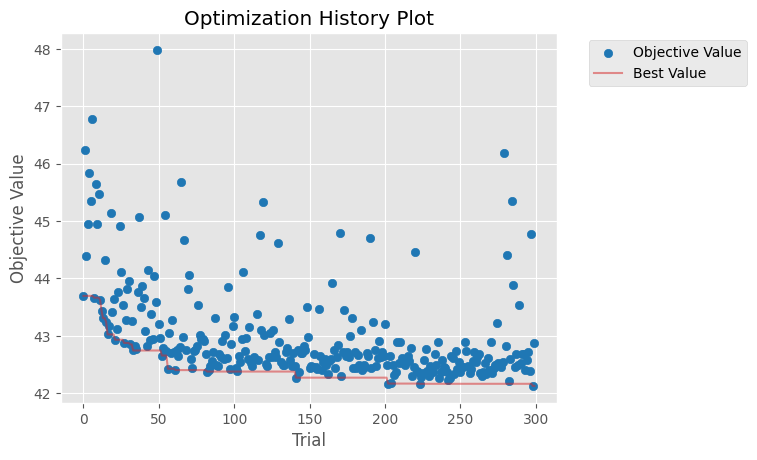

Parameter Importance


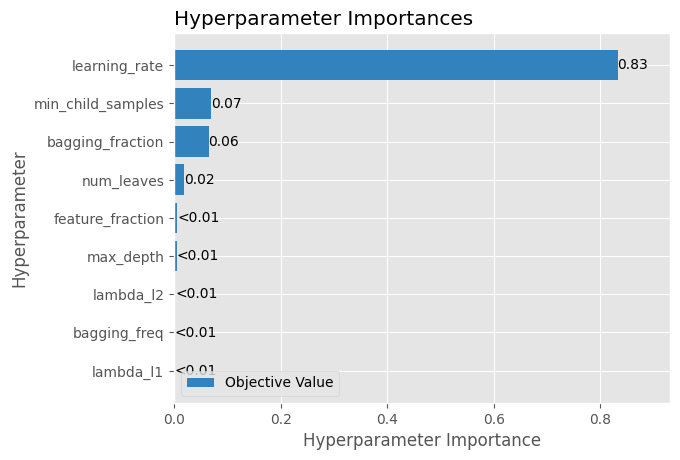


Training final model with cross-validation...
Fold: 1
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[594]	valid_0's rmse: 43.4577
Fold 1 RMSE: 43.4577
Fold: 2
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[549]	valid_0's rmse: 40.165
Fold 2 RMSE: 40.1650
Fold: 3
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[307]	valid_0's rmse: 42.8832
Fold 3 RMSE: 42.8832
Fold: 4
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[712]	valid_0's rmse: 40.0977
Fold 4 RMSE: 40.0977
Fold: 5
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[979]	valid_0's rmse: 44.0349
Fold 5 RMSE: 44.0349

Overall OOF RMSE: 42.1606
CV Score (mean ± std): 42.1277 ± 1.6703
OOF predictions saved to oof_predictions.csv
Submission file created and saved.
Final submissi

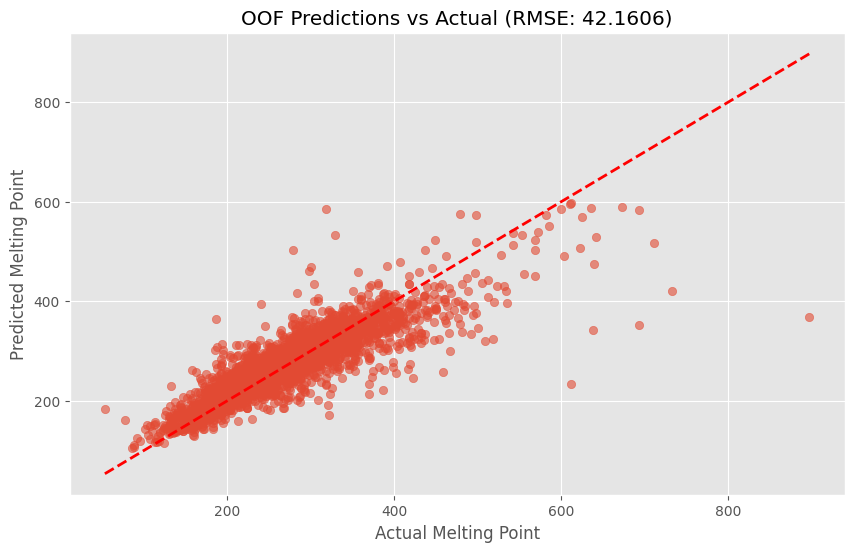


Prediction statistics:
Train target range: 53.54 to 897.15
OOF predictions range: 105.21 to 598.01
Test predictions range: 115.37 to 597.87


In [5]:
# --- Optuna Hyperparameter Tuning ---
def objective(trial, X, y):
    """Optuna objective function for hyperparameter tuning with K-Fold CV."""
    kf = KFold(n_splits=5, random_state=42, shuffle=True)
    rmse_scores = []
    
    param = {
        'objective': 'regression',
        'metric': 'rmse',
        'boosting_type': 'gbdt',
        'lambda_l1': trial.suggest_float('lambda_l1', 1e-8, 10.0, log=True),
        'lambda_l2': trial.suggest_float('lambda_l2', 1e-8, 10.0, log=True),
        'num_leaves': trial.suggest_int('num_leaves', 10, 300),
        'feature_fraction': trial.suggest_float('feature_fraction', 0.4, 1.0),
        'bagging_fraction': trial.suggest_float('bagging_fraction', 0.4, 1.0),
        'bagging_freq': trial.suggest_int('bagging_freq', 1, 7),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'max_depth': trial.suggest_int('max_depth', 3, 12),
        'random_state': 42,
        'n_estimators': 1000,
        'verbosity': -1,
    }
    
    for fold, (trn_idx, val_idx) in enumerate(kf.split(X, y)):
        X_tr, X_val = X.iloc[trn_idx], X.iloc[val_idx]
        y_tr, y_val = y.iloc[trn_idx], y.iloc[val_idx]
        
        model = lgb.LGBMRegressor(**param)
        model.fit(
            X_tr, y_tr,
            eval_set=[(X_val, y_val)],
            eval_metric='rmse',
            callbacks=[lgb.early_stopping(100), lgb.log_evaluation(0)]
        )
        
        val_preds = model.predict(X_val)
        rmse = mean_squared_error(y_val, val_preds, squared=False)
        rmse_scores.append(rmse)
    
    return np.mean(rmse_scores)

# Run hyperparameter optimization
print("Starting hyperparameter optimization...")
study = optuna.create_study(direction='minimize')
study.optimize(lambda trial: objective(trial, trainX[feature_columns], trainY), n_trials=300)

print('Number of finished trials:', len(study.trials))
print('Best trial:', study.best_trial.params)
print('Best RMSE:', study.best_trial.value)

# Save best parameters
best_params = study.best_trial.params
with open("best_params.yaml", "w") as yaml_file:
    yaml.dump(best_params, yaml_file)

# Add fixed parameters
best_params.update({
    'objective': 'regression',
    'metric': 'rmse',
    'boosting_type': 'gbdt',
    'random_state': 42,
    'n_estimators': 1000,
    'verbosity': -1,
})

# --- Visualization ---
try:
    print("\n" + "="*50)
    print("Optimization History")
    optuna.visualization.matplotlib.plot_optimization_history(study)
    plt.show()
    
    print("Parameter Importance")
    optuna.visualization.matplotlib.plot_param_importances(study)
    plt.show()
except ImportError:
    print("Matplotlib visualization not available. Install optuna[plotly] for interactive plots.")

# --- Final Model Training and Prediction ---
print("\nTraining final model with cross-validation...")

kf = KFold(n_splits=5, random_state=42, shuffle=True)
oof_predictions = np.zeros(len(trainX))
test_predictions = np.zeros(len(testX))
fold_scores = []

for fold, (trn_idx, val_idx) in enumerate(kf.split(trainX[feature_columns], trainY)):
    print(f'Fold: {fold+1}')
    
    X_tr, X_val = trainX[feature_columns].iloc[trn_idx], trainX[feature_columns].iloc[val_idx]
    y_tr, y_val = trainY.iloc[trn_idx], trainY.iloc[val_idx]
    
    model = lgb.LGBMRegressor(**best_params)
    model.fit(
        X_tr, y_tr,
        eval_set=[(X_val, y_val)],
        eval_metric='rmse',
        callbacks=[lgb.early_stopping(100), lgb.log_evaluation(0)]
    )
    
    # Out-of-fold predictions
    oof_preds = model.predict(X_val)
    oof_predictions[val_idx] = oof_preds
    
    # Test predictions
    test_preds = model.predict(testX[feature_columns])
    test_predictions += test_preds / kf.n_splits
    
    # Calculate fold score
    rmse = mean_squared_error(y_val, oof_preds, squared=False)
    fold_scores.append(rmse)
    print(f'Fold {fold+1} RMSE: {rmse:.4f}')

# --- Evaluation and Submission ---
overall_rmse = mean_squared_error(trainY, oof_predictions, squared=False)
print(f"\nOverall OOF RMSE: {overall_rmse:.4f}")
print(f"CV Score (mean ± std): {np.mean(fold_scores):.4f} ± {np.std(fold_scores):.4f}")

# Save OOF predictions
oof_df = pd.DataFrame({
    'actual': trainY,
    'predicted': oof_predictions
})
oof_df.to_csv('oof_predictions.csv', index=False)
print("OOF predictions saved to oof_predictions.csv")

# Create submission file
if target in submit.columns:
    submit[target] = test_predictions
else:
    # If target column doesn't exist, assume it's the second column
    submit.iloc[:, 1] = test_predictions

submit.to_csv('submission.csv', index=False)
print("Submission file created and saved.")
print("Final submission preview:")
print(submit.head())

# Feature importance
print("\nTop 10 Feature Importances:")
feature_importance = model.feature_importances_
importance_df = pd.DataFrame({
    'feature': feature_columns,
    'importance': feature_importance
}).sort_values('importance', ascending=False)
print(importance_df.head(10))

# Plot predictions vs actual
plt.figure(figsize=(10, 6))
plt.scatter(trainY, oof_predictions, alpha=0.6)
plt.plot([trainY.min(), trainY.max()], [trainY.min(), trainY.max()], 'r--', lw=2)
plt.xlabel('Actual Melting Point')
plt.ylabel('Predicted Melting Point')
plt.title(f'OOF Predictions vs Actual (RMSE: {overall_rmse:.4f})')
plt.show()

print("\nPrediction statistics:")
print(f"Train target range: {trainY.min():.2f} to {trainY.max():.2f}")
print(f"OOF predictions range: {oof_predictions.min():.2f} to {oof_predictions.max():.2f}")
print(f"Test predictions range: {test_predictions.min():.2f} to {test_predictions.max():.2f}")